In [1]:
import numpy as np
import pandas as pd
#import wfdb
import os
from glob import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import scipy.signal as signal
from scipy.signal import butter, lfilter
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.models.alexnet import alexnet


seed=2020
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
reclist=glob("./seg/*")
dtlist=glob("./seg/*/*.npy*")
reclist.sort()
dtlist.sort()
lab_list=[seg.split('_')[0][-1] for seg in dtlist]#shuffle by idx
(dtlist[0].split('_')[1]+'_'+dtlist[0].split('_')[-1].split('.')[0])

'a01_100'

In [3]:
def cheb_bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):    # 
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        #b, a = butter(filter_order, [low, high], btype="band")
        b, a = signal.cheby2(filter_order, 40, [low, high], 'band', analog=False)
        y = lfilter(b, a, data)
        return y

In [4]:
subjects=[['a11'],['a15'],['a17'],['b01'],['c07'],
          ['a11','a15','a17','b01','c07'],
          ['a14','a19','b05','c01','c07'],
          ['a04','a19','b05','c01','c09'],['b02','b03'],['x16','x21']]
len(subjects)

10

In [5]:
from sklearn.model_selection import KFold
def getTrainTestList(reclist,opt='rec_cv',fold=1):
    train_dtlist=[]
    test_dtlist=[]
    if opt=='rec_cv':#reclist is rec list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(reclist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_rec,test_rec=list(np.array(reclist)[train_idx]),list(np.array(reclist)[test_idx])
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        test_rec=[rec for rec in reclist if rec[-3]=='x']
        print(len(train_rec),len(test_rec))
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet_train':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        #print(len(train_rec),len(test_rec))
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
    elif opt=='blind':
        subjects=[['a11'],
                  ['a15','x27','x28'],
                  ['a17','x12'],
                  ['b01','x03'],
                  ['c07','x34'],
                  ['a11','a15','x27','x28','a17','x12','b01','x03','c07','x34'],
                  ['a14','a19','x05','x08','x25','b05','x11','c01','x35','c07','x34'],
                  ['a04','a19','x05','x08','x25','b05','x11','c01','x35','c09'],
                  ['b02','b03','x16','x21']]
        train_rec=[rec for rec in reclist if rec.split('/')[-1] not in subjects[fold-1]]
        test_rec=[rec for rec in reclist if rec.split('/')[-1] in subjects[fold-1]]
        print(len(train_rec),len(test_rec),test_rec)
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')

    else:#reclist is npy data list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
         
    return train_dtlist,test_dtlist

def dtclean(dt_path):
    dt=np.load(dt_path)
    if dt.std()<0.1:
#        print(dt_path)
        return 1      
    else:
        return 0

#train_rec,test_rec=reclist[train_idx],reclist[test_idx]
#train_dtlist,test_dtlist=getTrainTestList(reclist,opt='kfold',fold=1)#fold 1-10
#print('*********')
#print(len(train_dtlist),len(test_dtlist))
#train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
#np.random.shuffle(train_dtlist)
#test_dtlist=[file for file in test_dtlist if dtclean(file)==0]

#print(len(train_dtlist),len(test_dtlist))


In [6]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
ApneaECGDict={'N':0,
              'A':1}
class ApneaECGDataset(Dataset):
    def __init__(self, filelist, istrain=False):
        # Get the filelist and img data
        self.filelist = filelist
        self.istrain = istrain
        
    def getFeature(self, dt):
#         dt=dt.reshape(-1,100)
#         if self.istrain:
#             shift=np.random.randint(0,5)
#             shift=0
#         else:
#             shift=0
#         dt=dt[:,shift::]
#         dt_flag=dt[:,20::]*dt[:,0:-20]
#         pd_dt=pd.DataFrame(dt)
#         pd_dt_flag=pd.DataFrame(dt_flag)
#scipy.signal.stft(x,fs=1.0,window='hann',nperseg=256,noverlap=None,nfft=None,detrend=False,return_onesided=True,boundary='zeros',padded=True,axis=-1)
        dt=cheb_bandpass_filter(dt, 0.01, 28, 100, 4)
    
    
        f, t, Sxx=signal.spectrogram(dt, fs=100.0, window=('hamming'), nperseg=128, noverlap=64, nfft=128, detrend='constant',
        return_onesided=True, scaling='density', axis=-1, mode='psd')
        return Sxx[0:20]
        
#         return np.concatenate((dt_flag.max(axis=1,keepdims=True),
#                                dt_flag.min(axis=1,keepdims=True),
#                                dt_flag.std(axis=1,keepdims=True),
#                                dt.std(axis=1,keepdims=True),
#             abs(dt).sum(axis=1,keepdims=True)/100,
#             abs(dt_flag).sum(axis=1,keepdims=True)/100,
#             (dt.argmax(axis=1)-dt.argmax(axis=1)[0])[:,np.newaxis]/100,
#             (dt.argmin(axis=1)-dt.argmin(axis=1)[0])[:,np.newaxis]/100,
#             (dt_flag.argmin(axis=1)-dt_flag.argmin(axis=1)[0])[:,np.newaxis]/100,
#             (dt_flag.argmax(axis=1)-dt_flag.argmax(axis=1)[0])[:,np.newaxis]/100,
#                                dt.mean(axis=1,keepdims=True),#
#                                dt.min(axis=1,keepdims=True),
#                                dt.max(axis=1,keepdims=True),
#                                #pd_dt.skew(axis=1).values[:,np.newaxis],
#                                #pd_dt.kurt(axis=1).values[:,np.newaxis],
#                                #pd_dt_flag.skew(axis=1).values[:,np.newaxis],
#                                #pd_dt_flag.kurt(axis=1).values[:,np.newaxis]
#                                ),axis=1)
    def __getitem__(self, index):
        # return to the data of a Picture
        dt_path = self.filelist[index]
        label = ApneaECGDict.__getitem__(dt_path.split('_')[0][-1])
        data = np.load(dt_path)
        seg_id= dt_path.split('_')[1]+'_'+ dt_path.split('_')[-1].split('.')[0]

        if self.istrain:
            noise = np.random.normal(0, 0.1, data.shape[0])
            data = noise+data
        data=self.getFeature(data)
        return data, label,seg_id

    def __len__(self):
        return len(self.filelist)

class conv3x3(nn.Module):#ACNet

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, 
                 padding=1, dilation=1, groups=1, padding_mode='zeros', bias=False, deploy=False):
        super(conv3x3, self).__init__()
        self.deploy=deploy
        if self.deploy:
            self.fused_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(kernel_size,kernel_size), stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=False, padding_mode=padding_mode)
# c=a.square_conv.weight.data.numpy().copy()
# c[:,:,1:2,:]=a.square_conv.weight.data[:,:,1:2,:,].numpy().copy()+a.hor_conv.weight.data[:,:,0:1,:,].numpy().copy()
# c[:,:,:,1:2]+=a.ver_conv.weight.data[:,:,:,0:1].numpy().copy()
# c-a.square_conv.weight.data.numpy()
# b.fused_conv.weight.data=torch.FloatTensor(c)    
        else:
            self.square_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=(kernel_size, kernel_size), stride=stride,
                                         padding=padding, dilation=dilation, groups=groups, bias=False,
                                         padding_mode=padding_mode)

            center_offset_from_origin_border = padding - kernel_size // 2 #1-3//2=0
            ver_pad_or_crop = (center_offset_from_origin_border + 1, center_offset_from_origin_border)
            hor_pad_or_crop = (center_offset_from_origin_border, center_offset_from_origin_border + 1)
            if center_offset_from_origin_border >= 0:
                self.ver_conv_crop_layer = nn.Identity()
                ver_conv_padding = ver_pad_or_crop
                self.hor_conv_crop_layer = nn.Identity()
                hor_conv_padding = hor_pad_or_crop

            self.ver_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 1),
                                      stride=stride,
                                      padding=ver_conv_padding, dilation=dilation, groups=groups, bias=False,
                                      padding_mode=padding_mode)

            self.hor_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 3),
                                      stride=stride,
                                      padding=hor_conv_padding, dilation=dilation, groups=groups, bias=False,
                                      padding_mode=padding_mode)

    # forward函数
    def forward(self, input):
        if self.deploy:
            #assert self.square_conv
            print("True")
            return self.fused_conv(input)
        square_outputs = self.square_conv(input)
        # print(square_outputs.size())
        # return square_outputs
        vertical_outputs = self.ver_conv(input)
        # print(vertical_outputs.size())
        #horizontal_outputs = self.hor_conv_crop_layer(input)
        horizontal_outputs = self.hor_conv(input)
        # print(horizontal_outputs.size())
        return square_outputs + vertical_outputs + horizontal_outputs
    
class MyLSTM(nn.Module):
    def __init__(self, class_num,fs):
        super(MyLSTM, self).__init__()
        #self.bn=nn.BatchNorm1d(60)
#         self.conv10=nn.Sequential(nn.Conv1d(1,64,kernel_size=10,stride=10,padding=0, bias=False),
#                   nn.Conv1d(64,32,kernel_size=3,stride=2,padding=0, bias=False),
#                   nn.MaxPool1d(kernel_size=3,stride=2),
#                   nn.Conv1d(32,32,kernel_size=3,stride=2,padding=0, bias=False),
#                   nn.MaxPool1d(kernel_size=3,stride=2),
#                                nn.ReLU())1200
#25 * 65
#12* 32
#b*64*6*16
#b*6*64*16
        self.branch1=nn.Sequential(nn.Conv2d(1,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(32,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(64,64,kernel_size=(3,1),dilation=1,stride=1,padding=0, bias=False),
                                #nn.ReLU(),                               
                                nn.LayerNorm([fs,20,92],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.25),
                                #nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                #nn.Dropout(p=0.25),
                                
#                                 nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 nn.ReLU(),
#                                 nn.Dropout(p=0.25),
                                nn.LayerNorm([fs,10,46],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.5),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(64,64,kernel_size=(5,1),dilation=1,stride=1,padding=0, bias=False),
                                                          
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                #nn.Dropout(p=0.5),
                                nn.LayerNorm([fs,5,23],elementwise_affine=False),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                #nn.Conv2d(64,64,kernel_size=(1,3),dilation=1,stride=1,padding=0, bias=False),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False))
        
#         self.branch2=nn.Sequential(nn.Conv2d(1,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 #nn.Conv2d(32,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 #nn.Conv2d(64,64,kernel_size=(3,1),dilation=1,stride=1,padding=0, bias=False),
#                                 #nn.ReLU(),                               
#                                 nn.LayerNorm([32,25,92]),
#                                 nn.ReLU(), 
#                                 nn.Dropout(p=0.25),
#                                 #nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 nn.MaxPool2d(kernel_size=2,stride=2),
#                                 #nn.Dropout(p=0.25),
                                
# #                                 nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
# #                                 nn.ReLU(),
# #                                 nn.Dropout(p=0.25),
#                                 nn.LayerNorm([32,12,46]),
#                                 nn.ReLU(), 
#                                 nn.Dropout(p=0.25),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 #nn.Conv2d(64,64,kernel_size=(5,1),dilation=1,stride=1,padding=0, bias=False),
                                                          
#                                 nn.MaxPool2d(kernel_size=2,stride=2),
#                                 #nn.Dropout(p=0.5),
#                                 nn.LayerNorm([32,6,23]),
#                                 nn.ReLU(),
#                                 nn.Dropout(p=0.5),
#                                 #nn.Conv2d(64,64,kernel_size=(1,3),dilation=1,stride=1,padding=0, bias=False),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False))
        
        self.avg = nn.Sequential(nn.AdaptiveMaxPool2d((8,8)),nn.LayerNorm([5,8,8],elementwise_affine=False))
    
        self.lstm = nn.LSTM(64, 8, 2,
                            bias=False,
                            batch_first=True,
                            dropout=0.5,
                            bidirectional=True)
        #self.conv2=nn.Sequential(nn.Conv1d(64,64,kernel_size=1,stride=1,padding=0, bias=False))
        
        self.fc=nn.Sequential(nn.Linear(16*2,class_num))
    def attention_net(self,lstm_output, final_state):
        hidden = final_state.view(-1, 16, 2)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        #print('hi',hidden.shape)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        #print('att',attn_weights.shape)
        soft_attn_weights = F.softmax(attn_weights, 1)
        #print('sft',soft_attn_weights.shape)
        #print('yimr',torch.bmm(lstm_output.transpose(1, 2),soft_attn_weights).shape)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)
        return context#, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    def forward(self, x):
        x=x.unsqueeze(dim=1)#x.reshape(x.shape[0],1,-1)
        #x1=self.conv10(x)
        out=self.branch1(x)
        #out_1=self.branch1(x)
        #out_2=self.branch2(x)
        #out=torch.cat((out_1,out_2),1)
        #print(out.shape)
        out=out.permute(0,2,1,3)
        out=self.avg(out)
        #print(out.shape)
        out=out.view(out.shape[0],out.shape[1],-1)
        #print(x2.shape)
        #print(x1.shape,x2.shape)
        #x=torch.cat((x1,x2),dim=1)
        #print(x.shape)
        out,(h,c) = self.lstm(out)
        out=self.attention_net(out, h)
        
        #out = self.conv2(out)
        #print(out.shape)
        out = self.fc(out.reshape(out.shape[0],-1))
        return out

In [7]:
def eval(model,test_dtlist,criterion,my_device):
    test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    test_loader=DataLoader(test_dataset, batch_size=128, shuffle=False, sampler=None, num_workers=0)
    #train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
        #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    #train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
    sft=nn.Softmax().to(my_device)
    all_pred_prob=torch.Tensor([]).to(my_device)
    all_label=torch.Tensor([]).long().to(my_device)
    all_seg=[]#torch.Tensor([]).to(my_device)
    flag=0
    with torch.no_grad():
        for fe, label,seg_id in test_loader:
            fe=fe.float().to(my_device)
            #fe=(fe-fe_mean)/fe_std
            label=label.long().to(my_device)
            pred_prob_no_softmax=model(fe)
            all_pred_prob=torch.cat((all_pred_prob,pred_prob_no_softmax),0)
            all_label=torch.cat((all_label,label),0)
            all_seg+=list(seg_id)
            loss=criterion(pred_prob_no_softmax,label)
            flag+=1
            if flag%8==0:
                print('Eval Loss: ',loss.item())
            #pos=(sft(pred_prob_no_softmax)[:,1]>0.5)
            #print("Acc: ", sum(label==pos).detach().numpy()/len(label))
    all_pred=sft(all_pred_prob)[:,1].detach().cpu().numpy()
    all_pred[all_pred>0.5]=1
    all_pred[all_pred<=0.5]=0
    all_label=all_label.detach().cpu().numpy()
    #all_seg=all_seg.detach().cpu().numpy()
    print(confusion_matrix(all_label,all_pred))
    print(classification_report(all_label,all_pred))
    print("acc: ",accuracy_score(all_label,all_pred))
    print("pre: ",precision_score(all_label,all_pred))
    print("rec: ",recall_score(all_label,all_pred))
    print("ma F1: ",f1_score(all_label,all_pred, average='macro'))
    print("mi F1: ",f1_score(all_label,all_pred, average='micro'))
    print("we F1: ",f1_score(all_label,all_pred, average='weighted'))
    return sft(all_pred_prob)[:,1].detach().cpu().numpy(),all_label, accuracy_score(all_label,all_pred),all_seg

  
kernel: 128
  
*********
29459 3432
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.16827286779880524
Loss:  0.15400761365890503
Loss:  0.1668827384710312
0 **********
Epoch:  69.85222911834717  fold:  1  kers:  128
epoch:  1
29459 461
Loss:  0.1361810863018036
Loss:  0.13710737228393555
Loss:  0.12114819884300232
1 **********
Epoch:  123.0380208492279  fold:  1  kers:  128
epoch:  2
29459 461
Loss:  0.10052928328514099
Loss:  0.11523830890655518
Loss:  0.09965768456459045
2 **********
Epoch:  177.66994619369507  fold:  1  kers:  128
epoch:  3
Eval Loss:  0.4002053439617157
Eval Loss:  0.6910831928253174
Eval Loss:  0.26847705245018005


D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 880  159]
 [ 898 1495]]
              precision    recall  f1-score   support

           0       0.49      0.85      0.62      1039
           1       0.90      0.62      0.74      2393

    accuracy                           0.69      3432
   macro avg       0.70      0.74      0.68      3432
weighted avg       0.78      0.69      0.70      3432

acc:  0.692016317016317
pre:  0.903869407496977
rec:  0.6247388215628917
ma F1:  0.6817985054733611
mi F1:  0.692016317016317
we F1:  0.7042943051955763
update!  Acc:  0.692016317016317
Eval Loss:  0.4328390955924988
Eval Loss:  0.4830372929573059
Eval Loss:  0.4970913529396057
Eval Loss:  0.5380541086196899
Eval Loss:  0.44366008043289185
Eval Loss:  0.4926806688308716
Eval Loss:  0.4254724085330963
Eval Loss:  0.415473610162735
Eval Loss:  0.43978872895240784
Eval Loss:  0.40788447856903076
Eval Loss:  0.37723684310913086
Eval Loss:  0.4905098080635071
Eval Loss:  0.42432069778442383
Eval Loss:  0.45054659247398376
Eval Loss:  0.4201377

Eval Loss:  0.29561102390289307
Eval Loss:  0.359205961227417
Eval Loss:  0.2196313738822937
Eval Loss:  0.31920647621154785
Eval Loss:  0.24949035048484802
Eval Loss:  0.21522913873195648
Eval Loss:  0.324390709400177
Eval Loss:  0.31833216547966003
Eval Loss:  0.3225296437740326
Eval Loss:  0.2873270511627197
Eval Loss:  0.4280637800693512
Eval Loss:  0.3757375478744507
Eval Loss:  0.3711549937725067
Eval Loss:  0.3781222999095917
Eval Loss:  0.3183671534061432
Eval Loss:  0.25919780135154724
Eval Loss:  0.2515551745891571
Eval Loss:  0.23727035522460938
Eval Loss:  0.382465124130249
Eval Loss:  0.2849618196487427
Eval Loss:  0.40087181329727173
Eval Loss:  0.2959759533405304
Eval Loss:  0.3249933421611786
[[18448   677]
 [ 2836  7498]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     19125
           1       0.92      0.73      0.81     10334

    accuracy                           0.88     29459
   macro avg       0.89      0.85

Eval Loss:  0.24130070209503174
Eval Loss:  0.2521783411502838
[[18007  1118]
 [ 1691  8643]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     19125
           1       0.89      0.84      0.86     10334

    accuracy                           0.90     29459
   macro avg       0.90      0.89      0.89     29459
weighted avg       0.90      0.90      0.90     29459

acc:  0.9046471366984623
pre:  0.8854625550660793
rec:  0.8363653957809174
ma F1:  0.8939299833146442
mi F1:  0.9046471366984623
we F1:  0.9039913348094268
29459 461
Loss:  0.06695583462715149
Loss:  0.08594270050525665
Loss:  0.04526104778051376
21 **********
Epoch:  1474.114516735077  fold:  1  kers:  128
epoch:  22
29459 461
Loss:  0.06750817596912384
Loss:  0.07363305240869522
Loss:  0.07412374019622803
22 **********
Epoch:  1527.5955193042755  fold:  1  kers:  128
epoch:  23
29459 461
Loss:  0.07364506274461746
Loss:  0.08371371775865555
Loss:  0.057724494487047195
23

Loss:  0.07529456168413162
Loss:  0.033212557435035706
Loss:  0.06411895155906677
31 **********
Epoch:  2122.490890979767  fold:  1  kers:  128
epoch:  32
29459 461
Loss:  0.04850369691848755
Loss:  0.05767451599240303
Loss:  0.0458349771797657
32 **********
Epoch:  2175.3276154994965  fold:  1  kers:  128
epoch:  33
Eval Loss:  1.2987034320831299
Eval Loss:  0.2483641356229782
Eval Loss:  0.1753360629081726
[[ 732  307]
 [ 291 2102]]
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1039
           1       0.87      0.88      0.88      2393

    accuracy                           0.83      3432
   macro avg       0.79      0.79      0.79      3432
weighted avg       0.83      0.83      0.83      3432

acc:  0.8257575757575758
pre:  0.8725612287256123
rec:  0.878395319682407
ma F1:  0.7927294277238994
mi F1:  0.8257575757575757
we F1:  0.825371845561562
Eval Loss:  0.12688949704170227
Eval Loss:  0.19698403775691986
Eval Loss:  0.36

Eval Loss:  0.1184656098484993
Eval Loss:  0.1787809431552887
Eval Loss:  0.32668861746788025
Eval Loss:  0.2573794722557068
Eval Loss:  0.1556028425693512
Eval Loss:  0.20505386590957642
Eval Loss:  0.26408782601356506
Eval Loss:  0.13626906275749207
Eval Loss:  0.1832864135503769
Eval Loss:  0.18328770995140076
Eval Loss:  0.11774086207151413
Eval Loss:  0.17866459488868713
Eval Loss:  0.23623058199882507
Eval Loss:  0.25204190611839294
Eval Loss:  0.19675129652023315
Eval Loss:  0.22611241042613983
Eval Loss:  0.20479734241962433
Eval Loss:  0.22259381413459778
Eval Loss:  0.24910564720630646
Eval Loss:  0.25630420446395874
Eval Loss:  0.14620360732078552
Eval Loss:  0.11307740211486816
Eval Loss:  0.16245999932289124
Eval Loss:  0.20031684637069702
Eval Loss:  0.17029361426830292
Eval Loss:  0.24803036451339722
Eval Loss:  0.19708241522312164
Eval Loss:  0.18800044059753418
[[18057  1068]
 [ 1141  9193]]
              precision    recall  f1-score   support

           0       0.94

Eval Loss:  0.12378954887390137
Eval Loss:  0.22881127893924713
Eval Loss:  0.15774793922901154
Eval Loss:  0.21662192046642303
Eval Loss:  0.15859480202198029
Eval Loss:  0.1942986696958542
[[18258   867]
 [ 1109  9225]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     19125
           1       0.91      0.89      0.90     10334

    accuracy                           0.93     29459
   macro avg       0.93      0.92      0.93     29459
weighted avg       0.93      0.93      0.93     29459

acc:  0.9329237244984555
pre:  0.914090368608799
rec:  0.8926843429456164
ma F1:  0.925962603935122
mi F1:  0.9329237244984555
we F1:  0.9327372315087149
29459 461
Loss:  0.060034457594156265
Loss:  0.03967553749680519
Loss:  0.05932500958442688
51 **********
Epoch:  3455.2344048023224  fold:  1  kers:  128
epoch:  52
29459 461
Loss:  0.04861249774694443
Loss:  0.07280371338129044
Loss:  0.05963095277547836
52 **********
Epoch:  3507.9434716701508

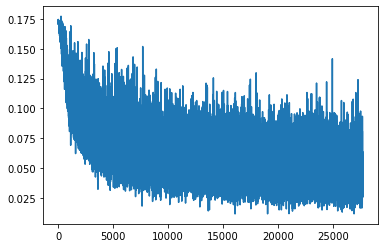

------
*********
29797 3094
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.16766300797462463
Loss:  0.1634133756160736
Loss:  0.1605810821056366
0 **********
Epoch:  65.9237322807312  fold:  2  kers:  128
epoch:  1
29797 466
Loss:  0.16199582815170288
Loss:  0.11213541775941849
Loss:  0.1067516878247261
1 **********
Epoch:  119.68299150466919  fold:  2  kers:  128
epoch:  2
29797 466
Loss:  0.10587312281131744
Loss:  0.09906651824712753
Loss:  0.10002750158309937
2 **********
Epoch:  173.3385272026062  fold:  2  kers:  128
epoch:  3
Eval Loss:  1.0346250534057617
Eval Loss:  0.10620489716529846
Eval Loss:  0.9071074724197388
[[1283  147]
 [ 851  813]]
              precis

10 **********
Epoch:  722.2309000492096  fold:  2  kers:  128
epoch:  11
29797 466
Loss:  0.060611043125391006
Loss:  0.046098824590444565
Loss:  0.07185445725917816
11 **********
Epoch:  775.6470761299133  fold:  2  kers:  128
epoch:  12
Eval Loss:  0.4894852042198181
Eval Loss:  0.3353460729122162
Eval Loss:  0.3426971435546875
[[1207  223]
 [ 522 1142]]
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1430
           1       0.84      0.69      0.75      1664

    accuracy                           0.76      3094
   macro avg       0.77      0.77      0.76      3094
weighted avg       0.77      0.76      0.76      3094

acc:  0.7592113768584356
pre:  0.8366300366300367
rec:  0.6862980769230769
ma F1:  0.7591050571498832
mi F1:  0.7592113768584355
we F1:  0.7587223061990938
update!  Acc:  0.7592113768584356
Eval Loss:  0.2633025646209717
Eval Loss:  0.23789586126804352
Eval Loss:  0.2676266133785248
Eval Loss:  0.2350049018859863

Eval Loss:  0.25060856342315674
Eval Loss:  0.2016974538564682
Eval Loss:  0.22967927157878876
Eval Loss:  0.19271236658096313
Eval Loss:  0.19843879342079163
Eval Loss:  0.23942255973815918
Eval Loss:  0.2466888129711151
Eval Loss:  0.2147296518087387
Eval Loss:  0.1907063126564026
Eval Loss:  0.25244051218032837
Eval Loss:  0.21055516600608826
Eval Loss:  0.15550753474235535
Eval Loss:  0.24885748326778412
Eval Loss:  0.225590780377388
Eval Loss:  0.17205306887626648
Eval Loss:  0.2389092594385147
Eval Loss:  0.17187367379665375
Eval Loss:  0.1852681040763855
Eval Loss:  0.2420567274093628
Eval Loss:  0.14186640083789825
Eval Loss:  0.20030924677848816
Eval Loss:  0.15748851001262665
Eval Loss:  0.254974365234375
Eval Loss:  0.4332365393638611
Eval Loss:  0.237501859664917
Eval Loss:  0.20794661343097687
Eval Loss:  0.22330082952976227
Eval Loss:  0.17971886694431305
Eval Loss:  0.15254926681518555
[[17839   895]
 [ 1687  9376]]
              precision    recall  f1-score   support



Eval Loss:  0.20274825394153595
Eval Loss:  0.1876317858695984
Eval Loss:  0.1975715458393097
Eval Loss:  0.15987563133239746
Eval Loss:  0.24509495496749878
Eval Loss:  0.3253837823867798
Eval Loss:  0.186287522315979
Eval Loss:  0.18124116957187653
Eval Loss:  0.24499143660068512
Eval Loss:  0.15648910403251648
Eval Loss:  0.16340696811676025
[[17497  1237]
 [  981 10082]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     18734
           1       0.89      0.91      0.90     11063

    accuracy                           0.93     29797
   macro avg       0.92      0.92      0.92     29797
weighted avg       0.93      0.93      0.93     29797

acc:  0.9255629761385374
pre:  0.8907147274494214
rec:  0.9113260417608243
ma F1:  0.9206490411336876
mi F1:  0.9255629761385374
we F1:  0.9257326278393119
29797 466
Loss:  0.059593312442302704
Loss:  0.044047463685274124
Loss:  0.05152008682489395
30 **********
Epoch:  2075.4337112903595  fold

Loss:  0.03670603781938553
Loss:  0.0472576767206192
Loss:  0.02544613927602768
39 **********
Epoch:  2678.137204647064  fold:  2  kers:  128
epoch:  40
29797 466
Loss:  0.05139566957950592
Loss:  0.046836890280246735
Loss:  0.0689789354801178
40 **********
Epoch:  2731.61621260643  fold:  2  kers:  128
epoch:  41
29797 466
Loss:  0.06945061683654785
Loss:  0.05804010480642319
Loss:  0.03951002657413483
41 **********
Epoch:  2785.2129056453705  fold:  2  kers:  128
epoch:  42
Eval Loss:  0.7849262356758118
Eval Loss:  0.12733913958072662
Eval Loss:  0.9274497032165527
[[1264  166]
 [ 700  964]]
              precision    recall  f1-score   support

           0       0.64      0.88      0.74      1430
           1       0.85      0.58      0.69      1664

    accuracy                           0.72      3094
   macro avg       0.75      0.73      0.72      3094
weighted avg       0.76      0.72      0.72      3094

acc:  0.7201034259857789
pre:  0.8530973451327434
rec:  0.5793269230769

Eval Loss:  0.17230401933193207
Eval Loss:  0.14507557451725006
Eval Loss:  0.1552383303642273
Eval Loss:  0.15543590486049652
Eval Loss:  0.14155875146389008
Eval Loss:  0.17472349107265472
Eval Loss:  0.1621190905570984
Eval Loss:  0.19019748270511627
Eval Loss:  0.12890376150608063
Eval Loss:  0.1665622591972351
Eval Loss:  0.1762482225894928
Eval Loss:  0.08476921170949936
Eval Loss:  0.18397590517997742
Eval Loss:  0.23148709535598755
Eval Loss:  0.13212443888187408
Eval Loss:  0.15150411427021027
Eval Loss:  0.08053964376449585
Eval Loss:  0.129822239279747
Eval Loss:  0.1641382873058319
Eval Loss:  0.13347123563289642
Eval Loss:  0.171014666557312
Eval Loss:  0.11259748041629791
Eval Loss:  0.20733985304832458
Eval Loss:  0.2753883898258209
Eval Loss:  0.15705180168151855
Eval Loss:  0.11648215353488922
Eval Loss:  0.21739962697029114
Eval Loss:  0.13563323020935059
Eval Loss:  0.12478692084550858
[[17878   856]
 [ 1065  9998]]
              precision    recall  f1-score   suppo

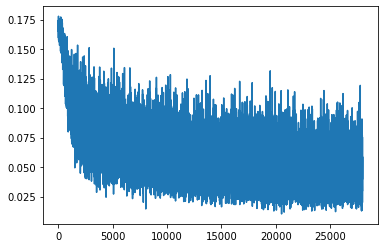

------
*********
29460 3431
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.16601401567459106
Loss:  0.16001424193382263
Loss:  0.1590544879436493
0 **********
Epoch:  65.25452327728271  fold:  3  kers:  128
epoch:  1
29460 461
Loss:  0.1514359414577484
Loss:  0.1318374127149582
Loss:  0.12387124449014664
1 **********
Epoch:  118.32262992858887  fold:  3  kers:  128
epoch:  2
29460 461
Loss:  0.12379796802997589
Loss:  0.10251650214195251
Loss:  0.08616722375154495
2 **********
Epoch:  171.32391500473022  fold:  3  kers:  128
epoch:  3
Eval Loss:  1.1286873817443848
Eval Loss:  1.0486525297164917
Eval Loss:  0.4210711419582367
[[1427  109]
 [ 819 1076]]
              preci

Loss:  0.06357401609420776
Loss:  0.08626914769411087
Loss:  0.07891053706407547
11 **********
Epoch:  770.4390029907227  fold:  3  kers:  128
epoch:  12
Eval Loss:  0.9779435396194458
Eval Loss:  0.2308444082736969
Eval Loss:  0.7136959433555603
[[1341  195]
 [ 681 1214]]
              precision    recall  f1-score   support

           0       0.66      0.87      0.75      1536
           1       0.86      0.64      0.73      1895

    accuracy                           0.74      3431
   macro avg       0.76      0.76      0.74      3431
weighted avg       0.77      0.74      0.74      3431

acc:  0.7446808510638298
pre:  0.8616039744499645
rec:  0.6406332453825857
ma F1:  0.7443305472644941
mi F1:  0.7446808510638298
we F1:  0.7433403184144037
Eval Loss:  0.40816113352775574
Eval Loss:  0.5023683309555054
Eval Loss:  0.19881227612495422
Eval Loss:  0.2814231812953949
Eval Loss:  0.2552594542503357
Eval Loss:  0.31406694650650024
Eval Loss:  0.4124833345413208
Eval Loss:  0.355056464

Eval Loss:  0.2804911136627197
Eval Loss:  0.2966570258140564
Eval Loss:  0.17565970122814178
Eval Loss:  0.18756279349327087
Eval Loss:  0.20250387489795685
Eval Loss:  0.19323280453681946
Eval Loss:  0.24328644573688507
Eval Loss:  0.2631164789199829
Eval Loss:  0.21100157499313354
Eval Loss:  0.23083782196044922
Eval Loss:  0.2858407199382782
Eval Loss:  0.25196439027786255
Eval Loss:  0.3412070870399475
Eval Loss:  0.16287876665592194
Eval Loss:  0.2040044665336609
Eval Loss:  0.19678761065006256
Eval Loss:  0.1904139369726181
Eval Loss:  0.18747906386852264
Eval Loss:  0.2207174003124237
Eval Loss:  0.26129236817359924
Eval Loss:  0.1708858162164688
Eval Loss:  0.2976900637149811
Eval Loss:  0.30521610379219055
Eval Loss:  0.14171361923217773
Eval Loss:  0.24892088770866394
Eval Loss:  0.22435565292835236
Eval Loss:  0.2869516611099243
Eval Loss:  0.23263880610466003
[[17698   930]
 [ 1666  9166]]
              precision    recall  f1-score   support

           0       0.91      

Eval Loss:  0.289910227060318
Eval Loss:  0.1371787041425705
Eval Loss:  0.22295573353767395
Eval Loss:  0.2027951031923294
Eval Loss:  0.25270092487335205
Eval Loss:  0.21305979788303375
[[17687   941]
 [ 1378  9454]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     18628
           1       0.91      0.87      0.89     10832

    accuracy                           0.92     29460
   macro avg       0.92      0.91      0.91     29460
weighted avg       0.92      0.92      0.92     29460

acc:  0.9212830957230143
pre:  0.9094757094757094
rec:  0.8727843426883308
ma F1:  0.9146144919690855
mi F1:  0.9212830957230143
we F1:  0.9209291324240385
29460 461
Loss:  0.06726610660552979
Loss:  0.07374277710914612
Loss:  0.037634678184986115
30 **********
Epoch:  2060.4816908836365  fold:  3  kers:  128
epoch:  31
29460 461
Loss:  0.050806041806936264
Loss:  0.04873849079012871
Loss:  0.06264350563287735
31 **********
Epoch:  2113.4500644207  f

Loss:  0.04561590030789375
Loss:  0.06902298331260681
Loss:  0.040047623217105865
39 **********
Epoch:  2657.708827018738  fold:  3  kers:  128
epoch:  40
29460 461
Loss:  0.07212211936712265
Loss:  0.06094101443886757
Loss:  0.05845861881971359
40 **********
Epoch:  2710.5106451511383  fold:  3  kers:  128
epoch:  41
29460 461
Loss:  0.025120703503489494
Loss:  0.04309934005141258
Loss:  0.09288595616817474
41 **********
Epoch:  2763.3164536952972  fold:  3  kers:  128
epoch:  42
Eval Loss:  0.374208003282547
Eval Loss:  0.05793905258178711
Eval Loss:  0.9575427174568176
[[1206  330]
 [ 551 1344]]
              precision    recall  f1-score   support

           0       0.69      0.79      0.73      1536
           1       0.80      0.71      0.75      1895

    accuracy                           0.74      3431
   macro avg       0.74      0.75      0.74      3431
weighted avg       0.75      0.74      0.74      3431

acc:  0.743223549985427
pre:  0.8028673835125448
rec:  0.7092348284

Eval Loss:  0.22368884086608887
Eval Loss:  0.18650662899017334
Eval Loss:  0.16030217707157135
Eval Loss:  0.15599706768989563
Eval Loss:  0.17299142479896545
Eval Loss:  0.1448906660079956
Eval Loss:  0.1854291558265686
Eval Loss:  0.1922634243965149
Eval Loss:  0.18308402597904205
Eval Loss:  0.17911797761917114
Eval Loss:  0.2668110132217407
Eval Loss:  0.19874286651611328
Eval Loss:  0.2411646544933319
Eval Loss:  0.11402663588523865
Eval Loss:  0.17447307705879211
Eval Loss:  0.15080472826957703
Eval Loss:  0.16904336214065552
Eval Loss:  0.1757926642894745
Eval Loss:  0.15721522271633148
Eval Loss:  0.19311220943927765
Eval Loss:  0.16639919579029083
Eval Loss:  0.22889888286590576
Eval Loss:  0.25681525468826294
Eval Loss:  0.1298586130142212
Eval Loss:  0.2051354944705963
Eval Loss:  0.20141874253749847
Eval Loss:  0.26531434059143066
Eval Loss:  0.15394634008407593
[[17642   986]
 [ 1085  9747]]
              precision    recall  f1-score   support

           0       0.94   

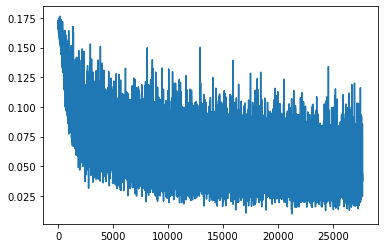

------
*********
29520 3371
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.18200930953025818
Loss:  0.16054746508598328
Loss:  0.15680460631847382
0 **********
Epoch:  65.47692775726318  fold:  4  kers:  128
epoch:  1
29520 462
Loss:  0.14740204811096191
Loss:  0.13014499843120575
Loss:  0.11538656800985336
1 **********
Epoch:  118.75746583938599  fold:  4  kers:  128
epoch:  2
29520 462
Loss:  0.14247992634773254
Loss:  0.09408252686262131
Loss:  0.10448414087295532
2 **********
Epoch:  171.89039993286133  fold:  4  kers:  128
epoch:  3
Eval Loss:  0.15642504394054413
Eval Loss:  0.1720067709684372
Eval Loss:  0.07944568991661072
[[3035  102]
 [ 219   15]]
              

Loss:  0.10938998311758041
Loss:  0.0747605562210083
Loss:  0.07121029496192932
11 **********
Epoch:  770.5636689662933  fold:  4  kers:  128
epoch:  12
Eval Loss:  0.0984237864613533
Eval Loss:  0.10981782525777817
Eval Loss:  0.024335458874702454
[[3087   50]
 [ 214   20]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3137
           1       0.29      0.09      0.13       234

    accuracy                           0.92      3371
   macro avg       0.61      0.53      0.55      3371
weighted avg       0.89      0.92      0.90      3371

acc:  0.9216849599525363
pre:  0.2857142857142857
rec:  0.08547008547008547
ma F1:  0.5452862118016384
mi F1:  0.9216849599525363
we F1:  0.9015579972212852
Eval Loss:  0.2799142897129059
Eval Loss:  0.3468072712421417
Eval Loss:  0.23743991553783417
Eval Loss:  0.3443920314311981
Eval Loss:  0.283614844083786
Eval Loss:  0.2919338345527649
Eval Loss:  0.37102267146110535
Eval Loss:  0.25887641

Eval Loss:  0.23024341464042664
Eval Loss:  0.2329375445842743
Eval Loss:  0.18679696321487427
Eval Loss:  0.258331835269928
Eval Loss:  0.21099618077278137
Eval Loss:  0.25554779171943665
Eval Loss:  0.21795159578323364
Eval Loss:  0.23554253578186035
Eval Loss:  0.2615520656108856
Eval Loss:  0.31516799330711365
Eval Loss:  0.34858784079551697
Eval Loss:  0.2323429137468338
Eval Loss:  0.3158555328845978
Eval Loss:  0.23695753514766693
Eval Loss:  0.20046980679035187
Eval Loss:  0.22250418365001678
Eval Loss:  0.23445773124694824
Eval Loss:  0.19806094467639923
Eval Loss:  0.30259501934051514
Eval Loss:  0.2951332628726959
Eval Loss:  0.16372643411159515
Eval Loss:  0.32014966011047363
Eval Loss:  0.24953843653202057
Eval Loss:  0.26814988255500793
Eval Loss:  0.2577248513698578
Eval Loss:  0.2131415456533432
Eval Loss:  0.2002960741519928
Eval Loss:  0.15750610828399658
[[16084   943]
 [ 2020 10473]]
              precision    recall  f1-score   support

           0       0.89     

Eval Loss:  0.262890100479126
Eval Loss:  0.2605149745941162
Eval Loss:  0.1860279142856598
Eval Loss:  0.19995710253715515
Eval Loss:  0.16152828931808472
[[16173   854]
 [ 1923 10570]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     17027
           1       0.93      0.85      0.88     12493

    accuracy                           0.91     29520
   macro avg       0.91      0.90      0.90     29520
weighted avg       0.91      0.91      0.91     29520

acc:  0.9059281842818429
pre:  0.9252450980392157
rec:  0.8460738013287441
ma F1:  0.9024125599279854
mi F1:  0.9059281842818429
we F1:  0.9052574360337127
29520 462
Loss:  0.05134831741452217
Loss:  0.05869108438491821
Loss:  0.0744553804397583
30 **********
Epoch:  2066.3259947299957  fold:  4  kers:  128
epoch:  31
29520 462
Loss:  0.052244704216718674
Loss:  0.045569922775030136
Loss:  0.05947897583246231
31 **********
Epoch:  2119.2694351673126  fold:  4  kers:  128
epoch:  32

Loss:  0.054417312145233154
Loss:  0.026442190632224083
39 **********
Epoch:  2664.942416191101  fold:  4  kers:  128
epoch:  40
29520 462
Loss:  0.050890762358903885
Loss:  0.060442931950092316
Loss:  0.09162731468677521
40 **********
Epoch:  2717.892838001251  fold:  4  kers:  128
epoch:  41
29520 462
Loss:  0.04528442770242691
Loss:  0.07124115526676178
Loss:  0.05713323503732681
41 **********
Epoch:  2770.8372750282288  fold:  4  kers:  128
epoch:  42
Eval Loss:  0.11398101598024368
Eval Loss:  0.17622560262680054
Eval Loss:  0.015697594732046127
[[3021  116]
 [ 191   43]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3137
           1       0.27      0.18      0.22       234

    accuracy                           0.91      3371
   macro avg       0.61      0.57      0.59      3371
weighted avg       0.89      0.91      0.90      3371

acc:  0.9089291011569267
pre:  0.27044025157232704
rec:  0.18376068376068377
ma F1:  0.58

Eval Loss:  0.18251349031925201
Eval Loss:  0.18614661693572998
Eval Loss:  0.1345382183790207
Eval Loss:  0.22144098579883575
Eval Loss:  0.14876234531402588
Eval Loss:  0.18710343539714813
Eval Loss:  0.17203551530838013
Eval Loss:  0.15036410093307495
Eval Loss:  0.15930117666721344
Eval Loss:  0.16143004596233368
Eval Loss:  0.29760104417800903
Eval Loss:  0.1385653167963028
Eval Loss:  0.23919880390167236
Eval Loss:  0.20211374759674072
Eval Loss:  0.1210625171661377
Eval Loss:  0.1598137468099594
Eval Loss:  0.16542911529541016
Eval Loss:  0.1564197689294815
Eval Loss:  0.19092369079589844
Eval Loss:  0.2756776809692383
Eval Loss:  0.1347101777791977
Eval Loss:  0.26448050141334534
Eval Loss:  0.11351770162582397
Eval Loss:  0.19081395864486694
Eval Loss:  0.16812963783740997
Eval Loss:  0.1517844796180725
Eval Loss:  0.15941065549850464
Eval Loss:  0.14099588990211487
[[16126   901]
 [ 1295 11198]]
              precision    recall  f1-score   support

           0       0.93   

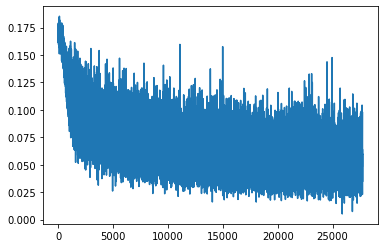

------
*********
29673 3218
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.1729276031255722
Loss:  0.17096871137619019
Loss:  0.16169506311416626
0 **********
Epoch:  65.91176462173462  fold:  5  kers:  128
epoch:  1
29673 464
Loss:  0.15075142681598663
Loss:  0.13901111483573914
Loss:  0.1300032138824463
1 **********
Epoch:  119.40872430801392  fold:  5  kers:  128
epoch:  2
29673 464
Loss:  0.11672918498516083
Loss:  0.12700015306472778
Loss:  0.10974466055631638
2 **********
Epoch:  172.7540898323059  fold:  5  kers:  128
epoch:  3
Eval Loss:  0.15718796849250793
Eval Loss:  0.30836349725723267
Eval Loss:  0.23542244732379913
[[2832  265]
 [  50   71]]
              pr

Loss:  0.08938643336296082
Loss:  0.07742989808320999
10 **********
Epoch:  723.1753752231598  fold:  5  kers:  128
epoch:  11
29673 464
Loss:  0.0574246346950531
Loss:  0.10011559724807739
Loss:  0.11341537535190582
11 **********
Epoch:  776.2803831100464  fold:  5  kers:  128
epoch:  12
Eval Loss:  0.07744960486888885
Eval Loss:  0.1281317174434662
Eval Loss:  0.06625586003065109
[[3052   45]
 [  66   55]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3097
           1       0.55      0.45      0.50       121

    accuracy                           0.97      3218
   macro avg       0.76      0.72      0.74      3218
weighted avg       0.96      0.97      0.96      3218

acc:  0.9655065257924177
pre:  0.55
rec:  0.45454545454545453
ma F1:  0.7399387702354907
mi F1:  0.9655065257924177
we F1:  0.9639259709486754
update!  Acc:  0.9655065257924177
Eval Loss:  0.42298424243927
Eval Loss:  0.3327619135379791
Eval Loss:  0.4010472595

Eval Loss:  0.3083556592464447
Eval Loss:  0.22530575096607208
Eval Loss:  0.2954109311103821
Eval Loss:  0.17668062448501587
Eval Loss:  0.35399383306503296
Eval Loss:  0.2277771532535553
Eval Loss:  0.2677192687988281
Eval Loss:  0.18693944811820984
Eval Loss:  0.30969956517219543
Eval Loss:  0.30261608958244324
Eval Loss:  0.3016059398651123
Eval Loss:  0.3115694522857666
Eval Loss:  0.22282513976097107
Eval Loss:  0.33389225602149963
Eval Loss:  0.16699817776679993
Eval Loss:  0.2930324971675873
Eval Loss:  0.27455973625183105
Eval Loss:  0.25253984332084656
Eval Loss:  0.279541015625
Eval Loss:  0.27032583951950073
Eval Loss:  0.22469186782836914
Eval Loss:  0.2929055094718933
Eval Loss:  0.22155717015266418
Eval Loss:  0.21399244666099548
Eval Loss:  0.2846214771270752
Eval Loss:  0.2285495549440384
Eval Loss:  0.33228349685668945
Eval Loss:  0.4081234335899353
Eval Loss:  0.28609323501586914
[[16134   933]
 [ 2269 10337]]
              precision    recall  f1-score   support

  

Eval Loss:  0.2145242691040039
Eval Loss:  0.2733518183231354
Eval Loss:  0.23376117646694183
Eval Loss:  0.17348875105381012
Eval Loss:  0.26235824823379517
Eval Loss:  0.20286814868450165
Eval Loss:  0.3039033114910126
Eval Loss:  0.3412725031375885
Eval Loss:  0.28506019711494446
[[16281   786]
 [ 2130 10476]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     17067
           1       0.93      0.83      0.88     12606

    accuracy                           0.90     29673
   macro avg       0.91      0.89      0.90     29673
weighted avg       0.90      0.90      0.90     29673

acc:  0.9017288444040037
pre:  0.9302077783697389
rec:  0.8310328415040457
ma F1:  0.8978181367383622
mi F1:  0.9017288444040037
we F1:  0.9008234195801238
29673 464
Loss:  0.0793122798204422
Loss:  0.05662180110812187
Loss:  0.05490223318338394
30 **********
Epoch:  2071.614921569824  fold:  5  kers:  128
epoch:  31
29673 464
Loss:  0.0848703533411026
Los

Loss:  0.051436897367239
Loss:  0.04716268926858902
Loss:  0.059977203607559204
39 **********
Epoch:  2677.066068649292  fold:  5  kers:  128
epoch:  40
29673 464
Loss:  0.03724776953458786
Loss:  0.08030720055103302
Loss:  0.027096733450889587
40 **********
Epoch:  2730.294746160507  fold:  5  kers:  128
epoch:  41
29673 464
Loss:  0.074002206325531
Loss:  0.07341831177473068
Loss:  0.0959847941994667
41 **********
Epoch:  2783.550351381302  fold:  5  kers:  128
epoch:  42
Eval Loss:  0.06062053143978119
Eval Loss:  0.0630926564335823
Eval Loss:  0.03269030153751373
[[3077   20]
 [  27   94]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.82      0.78      0.80       121

    accuracy                           0.99      3218
   macro avg       0.91      0.89      0.90      3218
weighted avg       0.99      0.99      0.99      3218

acc:  0.9853946550652579
pre:  0.8245614035087719
rec:  0.77685950413223

[[3072   25]
 [  22   99]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.80      0.82      0.81       121

    accuracy                           0.99      3218
   macro avg       0.90      0.91      0.90      3218
weighted avg       0.99      0.99      0.99      3218

acc:  0.9853946550652579
pre:  0.7983870967741935
rec:  0.8181818181818182
ma F1:  0.9002857999927478
mi F1:  0.9853946550652579
we F1:  0.9854805368564511
Eval Loss:  0.22048218548297882
Eval Loss:  0.1847531795501709
Eval Loss:  0.21582739055156708
Eval Loss:  0.14704114198684692
Eval Loss:  0.2732875943183899
Eval Loss:  0.20900952816009521
Eval Loss:  0.2275606393814087
Eval Loss:  0.1304437816143036
Eval Loss:  0.29579630494117737
Eval Loss:  0.19434477388858795
Eval Loss:  0.2499706745147705
Eval Loss:  0.2430025190114975
Eval Loss:  0.12583859264850616
Eval Loss:  0.30261680483818054
Eval Loss:  0.14052587747573853
Eval Loss:  0.25

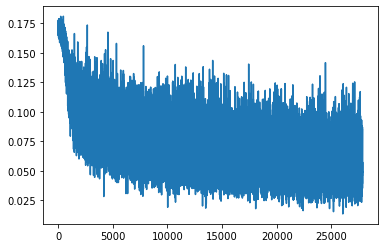

------
*********
29479 3412
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.17684751749038696
Loss:  0.17259196937084198
Loss:  0.1701730638742447
0 **********
Epoch:  65.41309833526611  fold:  6  kers:  128
epoch:  1
29479 461
Loss:  0.14792686700820923
Loss:  0.13327907025814056
Loss:  0.12616947293281555
1 **********
Epoch:  118.60786581039429  fold:  6  kers:  128
epoch:  2
29479 461
Loss:  0.12156448513269424
Loss:  0.0856056958436966
Loss:  0.11672988533973694
2 **********
Epoch:  171.76573300361633  fold:  6  kers:  128
epoch:  3
Eval Loss:  0.06631883233785629
Eval Loss:  0.32469624280929565
Eval Loss:  0.5449470281600952
[[2007  225]
 [ 176 1004]]
              pr

Loss:  0.08658813685178757
Loss:  0.09828490763902664
11 **********
Epoch:  772.3568737506866  fold:  6  kers:  128
epoch:  12
Eval Loss:  0.0187936220318079
Eval Loss:  0.35321542620658875
Eval Loss:  0.5220750570297241
[[2174   58]
 [ 437  743]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2232
           1       0.93      0.63      0.75      1180

    accuracy                           0.85      3412
   macro avg       0.88      0.80      0.82      3412
weighted avg       0.87      0.85      0.85      3412

acc:  0.8549237983587339
pre:  0.9275905118601748
rec:  0.6296610169491526
ma F1:  0.8239584122673556
mi F1:  0.8549237983587339
we F1:  0.8467226234260767
Eval Loss:  0.3306324779987335
Eval Loss:  0.36836084723472595
Eval Loss:  0.34601178765296936
Eval Loss:  0.337266743183136
Eval Loss:  0.31885409355163574
Eval Loss:  0.31358858942985535
Eval Loss:  0.4705897867679596
Eval Loss:  0.4032137095928192
Eval Loss:  0.3677

Eval Loss:  0.17333175241947174
Eval Loss:  0.25665977597236633
Eval Loss:  0.21251659095287323
Eval Loss:  0.22852183878421783
Eval Loss:  0.2381061464548111
Eval Loss:  0.20182786881923676
Eval Loss:  0.38233742117881775
Eval Loss:  0.26418405771255493
Eval Loss:  0.24962320923805237
Eval Loss:  0.2610766589641571
Eval Loss:  0.2490100860595703
Eval Loss:  0.17960214614868164
Eval Loss:  0.2586773931980133
Eval Loss:  0.25775283575057983
Eval Loss:  0.2893264591693878
Eval Loss:  0.16444315016269684
Eval Loss:  0.2611001431941986
Eval Loss:  0.28423160314559937
Eval Loss:  0.20241357386112213
Eval Loss:  0.4293637275695801
Eval Loss:  0.2405635118484497
Eval Loss:  0.23864203691482544
Eval Loss:  0.2619176208972931
Eval Loss:  0.213209331035614
Eval Loss:  0.2539050281047821
Eval Loss:  0.3269540071487427
Eval Loss:  0.2565130889415741
Eval Loss:  0.21715377271175385
[[17227   705]
 [ 2274  9273]]
              precision    recall  f1-score   support

           0       0.88      0.9

Eval Loss:  0.17132440209388733
Eval Loss:  0.21128307282924652
Eval Loss:  0.269000768661499
Eval Loss:  0.19160540401935577
Eval Loss:  0.1632317751646042
[[16996   936]
 [ 1584  9963]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     17932
           1       0.91      0.86      0.89     11547

    accuracy                           0.91     29479
   macro avg       0.91      0.91      0.91     29479
weighted avg       0.91      0.91      0.91     29479

acc:  0.914515417755012
pre:  0.9141205615194055
rec:  0.8628215120810601
ma F1:  0.909356074210006
mi F1:  0.914515417755012
we F1:  0.9140400509674159
29479 461
Loss:  0.05555393919348717
Loss:  0.07800941914319992
Loss:  0.05240539833903313
30 **********
Epoch:  2073.242570400238  fold:  6  kers:  128
epoch:  31
29479 461
Loss:  0.04826424643397331
Loss:  0.08113168925046921
Loss:  0.0812310129404068
31 **********
Epoch:  2126.2039618492126  fold:  6  kers:  128
epoch:  32
2947

Loss:  0.046491894870996475
39 **********
Epoch:  2672.311780691147  fold:  6  kers:  128
epoch:  40
29479 461
Loss:  0.0811830535531044
Loss:  0.031608156859874725
Loss:  0.0444357767701149
40 **********
Epoch:  2725.3938496112823  fold:  6  kers:  128
epoch:  41
29479 461
Loss:  0.07996596395969391
Loss:  0.05616309121251106
Loss:  0.09347870945930481
41 **********
Epoch:  2778.3831672668457  fold:  6  kers:  128
epoch:  42
Eval Loss:  0.008837088011205196
Eval Loss:  0.21678811311721802
Eval Loss:  0.4604329764842987
[[2179   53]
 [ 456  724]]
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2232
           1       0.93      0.61      0.74      1180

    accuracy                           0.85      3412
   macro avg       0.88      0.79      0.82      3412
weighted avg       0.86      0.85      0.84      3412

acc:  0.8508206330597889
pre:  0.9317889317889317
rec:  0.6135593220338983
ma F1:  0.8176630722649141
mi F1:  0.85082063

Eval Loss:  0.1345110684633255
Eval Loss:  0.27417701482772827
Eval Loss:  0.16526897251605988
Eval Loss:  0.20961757004261017
Eval Loss:  0.16908960044384003
Eval Loss:  0.16271139681339264
Eval Loss:  0.2621033787727356
Eval Loss:  0.19867190718650818
Eval Loss:  0.17802447080612183
Eval Loss:  0.22831858694553375
Eval Loss:  0.1783106029033661
Eval Loss:  0.1680149883031845
Eval Loss:  0.17501933872699738
Eval Loss:  0.18946240842342377
Eval Loss:  0.2028365582227707
Eval Loss:  0.11533069610595703
Eval Loss:  0.22040590643882751
Eval Loss:  0.2547987997531891
Eval Loss:  0.13903236389160156
Eval Loss:  0.2343391478061676
Eval Loss:  0.16945640742778778
Eval Loss:  0.12134268879890442
Eval Loss:  0.1805274337530136
Eval Loss:  0.11826687306165695
Eval Loss:  0.1838354468345642
Eval Loss:  0.22452500462532043
Eval Loss:  0.17621932923793793
Eval Loss:  0.12310238927602768
[[16535  1397]
 [  829 10718]]
              precision    recall  f1-score   support

           0       0.95    

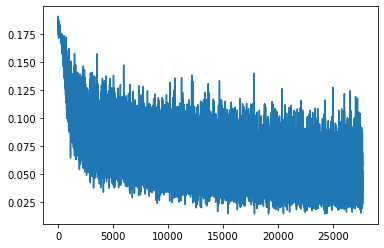

------
*********
29460 3431
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.15866532921791077
Loss:  0.1618976593017578
Loss:  0.13957884907722473
0 **********
Epoch:  65.49787163734436  fold:  7  kers:  128
epoch:  1
29460 461
Loss:  0.11615493148565292
Loss:  0.12697699666023254
Loss:  0.1024334505200386
1 **********
Epoch:  118.6986231803894  fold:  7  kers:  128
epoch:  2
29460 461
Loss:  0.10878762602806091
Loss:  0.10980191081762314
Loss:  0.10539527982473373
2 **********
Epoch:  171.93228721618652  fold:  7  kers:  128
epoch:  3
Eval Loss:  0.7342475056648254
Eval Loss:  0.13004712760448456
Eval Loss:  2.144118070602417
[[1718  409]
 [ 673  631]]
              preci

Loss:  0.11249860376119614
Loss:  0.10914643853902817
Loss:  0.0681770071387291
11 **********
Epoch:  772.2411835193634  fold:  7  kers:  128
epoch:  12
Eval Loss:  0.8720381259918213
Eval Loss:  0.051106907427310944
Eval Loss:  3.2562341690063477
[[2060   67]
 [ 882  422]]
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      2127
           1       0.86      0.32      0.47      1304

    accuracy                           0.72      3431
   macro avg       0.78      0.65      0.64      3431
weighted avg       0.76      0.72      0.68      3431

acc:  0.723404255319149
pre:  0.8629856850715747
rec:  0.3236196319018405
ma F1:  0.6417515255453548
mi F1:  0.723404255319149
we F1:  0.6827772865977557
update!  Acc:  0.723404255319149
Eval Loss:  0.22890359163284302
Eval Loss:  0.2640700936317444
Eval Loss:  0.33880937099456787
Eval Loss:  0.37368243932724
Eval Loss:  0.38399797677993774
Eval Loss:  0.3678799569606781
Eval Loss:  0.3233483135

Eval Loss:  0.2026398479938507
Eval Loss:  0.22578135132789612
Eval Loss:  0.26966121792793274
Eval Loss:  0.31699615716934204
Eval Loss:  0.32848283648490906
Eval Loss:  0.2733500897884369
Eval Loss:  0.27084779739379883
Eval Loss:  0.28536418080329895
Eval Loss:  0.2591775357723236
Eval Loss:  0.3421744108200073
Eval Loss:  0.26606589555740356
Eval Loss:  0.18121802806854248
Eval Loss:  0.25890785455703735
Eval Loss:  0.2627158761024475
Eval Loss:  0.18261882662773132
Eval Loss:  0.2628554701805115
Eval Loss:  0.2934000492095947
Eval Loss:  0.28736355900764465
Eval Loss:  0.3817232847213745
Eval Loss:  0.20910564064979553
Eval Loss:  0.2226097583770752
Eval Loss:  0.20830607414245605
Eval Loss:  0.2727811932563782
Eval Loss:  0.24416790902614594
Eval Loss:  0.33007267117500305
Eval Loss:  0.2999882698059082
Eval Loss:  0.26665931940078735
Eval Loss:  0.2916876971721649
[[17525   512]
 [ 2823  8600]]
              precision    recall  f1-score   support

           0       0.86      0

Eval Loss:  0.21756860613822937
Eval Loss:  0.21074514091014862
Eval Loss:  0.2842360734939575
Eval Loss:  0.2638092637062073
Eval Loss:  0.19887134432792664
Eval Loss:  0.2630457580089569
[[17479   558]
 [ 2091  9332]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     18037
           1       0.94      0.82      0.88     11423

    accuracy                           0.91     29460
   macro avg       0.92      0.89      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.910081466395112
pre:  0.9435793731041456
rec:  0.8169482622778604
ma F1:  0.9026353233785367
mi F1:  0.910081466395112
we F1:  0.9086803448479892
29460 461
Loss:  0.04893103241920471
Loss:  0.05522831529378891
Loss:  0.061493948101997375
30 **********
Epoch:  2070.7562177181244  fold:  7  kers:  128
epoch:  31
29460 461
Loss:  0.07150077074766159
Loss:  0.036405399441719055
Loss:  0.033021487295627594
31 **********
Epoch:  2123.7325694561005

Loss:  0.045377153903245926
Loss:  0.057699427008628845
Loss:  0.05288983881473541
39 **********
Epoch:  2668.9647300243378  fold:  7  kers:  128
epoch:  40
29460 461
Loss:  0.031012579798698425
Loss:  0.0404304563999176
Loss:  0.04037646949291229
40 **********
Epoch:  2721.883236885071  fold:  7  kers:  128
epoch:  41
29460 461
Loss:  0.04139764606952667
Loss:  0.04314742609858513
Loss:  0.04857780411839485
41 **********
Epoch:  2774.7987518310547  fold:  7  kers:  128
epoch:  42
Eval Loss:  0.38635724782943726
Eval Loss:  0.07630883157253265
Eval Loss:  1.6831893920898438
[[1881  246]
 [ 544  760]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      2127
           1       0.76      0.58      0.66      1304

    accuracy                           0.77      3431
   macro avg       0.77      0.73      0.74      3431
weighted avg       0.77      0.77      0.76      3431

acc:  0.769746429612358
pre:  0.7554671968190855
rec:  0.58282208

Eval Loss:  0.1583082228899002
Eval Loss:  0.13503894209861755
Eval Loss:  0.1453268975019455
Eval Loss:  0.19530518352985382
Eval Loss:  0.1770210713148117
Eval Loss:  0.18987056612968445
Eval Loss:  0.20578224956989288
Eval Loss:  0.16793301701545715
Eval Loss:  0.17600414156913757
Eval Loss:  0.1954033225774765
Eval Loss:  0.23735682666301727
Eval Loss:  0.09585629403591156
Eval Loss:  0.1683778464794159
Eval Loss:  0.17456753551959991
Eval Loss:  0.13729603588581085
Eval Loss:  0.23864540457725525
Eval Loss:  0.17092999815940857
Eval Loss:  0.19489577412605286
Eval Loss:  0.1830906867980957
Eval Loss:  0.13989810645580292
Eval Loss:  0.17916961014270782
Eval Loss:  0.1619928926229477
Eval Loss:  0.16470836102962494
Eval Loss:  0.16419728100299835
Eval Loss:  0.24041025340557098
Eval Loss:  0.2515479326248169
Eval Loss:  0.18513299524784088
Eval Loss:  0.20896384119987488
[[17045   992]
 [ 1142 10281]]
              precision    recall  f1-score   support

           0       0.94   

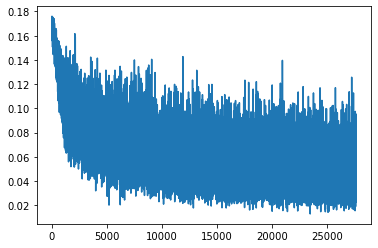

------
*********
29817 3074
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.17291001975536346
Loss:  0.16838914155960083
Loss:  0.16278892755508423
0 **********
Epoch:  65.97160458564758  fold:  8  kers:  128
epoch:  1
29817 466
Loss:  0.1337420791387558
Loss:  0.13590490818023682
Loss:  0.11816318333148956
1 **********
Epoch:  119.76178002357483  fold:  8  kers:  128
epoch:  2
29817 466
Loss:  0.11229433119297028
Loss:  0.13745608925819397
Loss:  0.08970680087804794
2 **********
Epoch:  173.36844730377197  fold:  8  kers:  128
epoch:  3
Eval Loss:  0.3697338402271271
Eval Loss:  0.8003073930740356
Eval Loss:  0.30688756704330444
[[1803  270]
 [ 262  739]]
              pr

10 **********
Epoch:  724.6105382442474  fold:  8  kers:  128
epoch:  11
29817 466
Loss:  0.07101625949144363
Loss:  0.07430063188076019
Loss:  0.07153020799160004
11 **********
Epoch:  778.03568983078  fold:  8  kers:  128
epoch:  12
Eval Loss:  0.6271085143089294
Eval Loss:  1.2157909870147705
Eval Loss:  0.11777196079492569
[[1584  489]
 [ 304  697]]
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      2073
           1       0.59      0.70      0.64      1001

    accuracy                           0.74      3074
   macro avg       0.71      0.73      0.72      3074
weighted avg       0.76      0.74      0.75      3074

acc:  0.7420299284320104
pre:  0.5876897133220911
rec:  0.6963036963036963
ma F1:  0.718600432867001
mi F1:  0.7420299284320104
we F1:  0.7469165763232468
Eval Loss:  0.3612699508666992
Eval Loss:  0.2539438307285309
Eval Loss:  0.17151959240436554
Eval Loss:  0.27911320328712463
Eval Loss:  0.21364207565784454
Eval

Eval Loss:  0.2848629653453827
Eval Loss:  0.24868200719356537
Eval Loss:  0.1444597989320755
Eval Loss:  0.24960826337337494
Eval Loss:  0.17589153349399567
Eval Loss:  0.1882849633693695
Eval Loss:  0.3164598345756531
Eval Loss:  0.24481868743896484
Eval Loss:  0.2691479027271271
Eval Loss:  0.13112469017505646
Eval Loss:  0.19288276135921478
Eval Loss:  0.1525408774614334
Eval Loss:  0.20351654291152954
Eval Loss:  0.23791296780109406
Eval Loss:  0.26542869210243225
Eval Loss:  0.24187365174293518
Eval Loss:  0.24120953679084778
Eval Loss:  0.22463084757328033
Eval Loss:  0.21895553171634674
Eval Loss:  0.20627768337726593
Eval Loss:  0.23934981226921082
Eval Loss:  0.19983826577663422
Eval Loss:  0.2615862786769867
Eval Loss:  0.2755529582500458
Eval Loss:  0.3011086881160736
Eval Loss:  0.35319003462791443
Eval Loss:  0.19037176668643951
Eval Loss:  0.1860656440258026
Eval Loss:  0.2360493242740631
[[16892  1199]
 [ 1484 10242]]
              precision    recall  f1-score   suppor

Eval Loss:  0.22342237830162048
Eval Loss:  0.20154458284378052
Eval Loss:  0.19721949100494385
Eval Loss:  0.20059898495674133
Eval Loss:  0.23075178265571594
Eval Loss:  0.20985737442970276
Eval Loss:  0.27101701498031616
Eval Loss:  0.3006863296031952
Eval Loss:  0.3384833335876465
Eval Loss:  0.36204788088798523
Eval Loss:  0.1746201515197754
Eval Loss:  0.15718144178390503
Eval Loss:  0.22063139081001282
[[16461  1630]
 [ 1071 10655]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     18091
           1       0.87      0.91      0.89     11726

    accuracy                           0.91     29817
   macro avg       0.90      0.91      0.91     29817
weighted avg       0.91      0.91      0.91     29817

acc:  0.9094140926317201
pre:  0.8673178673178673
rec:  0.9086645062254818
ma F1:  0.9058440453888432
mi F1:  0.9094140926317201
we F1:  0.9097578157472505
29817 466
Loss:  0.07183882594108582
Loss:  0.05465921014547348
Loss:  0.

Loss:  0.05121386796236038
Loss:  0.05594203248620033
Loss:  0.03832175210118294
39 **********
Epoch:  2691.762772321701  fold:  8  kers:  128
epoch:  40
29817 466
Loss:  0.07566969096660614
Loss:  0.06537731736898422
Loss:  0.047097884118556976
40 **********
Epoch:  2745.2886548042297  fold:  8  kers:  128
epoch:  41
29817 466
Loss:  0.04989781975746155
Loss:  0.03521367907524109
Loss:  0.06350623071193695
41 **********
Epoch:  2798.9910657405853  fold:  8  kers:  128
epoch:  42
Eval Loss:  0.590155839920044
Eval Loss:  1.1343982219696045
Eval Loss:  0.08214446902275085
[[1896  177]
 [ 295  706]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2073
           1       0.80      0.71      0.75      1001

    accuracy                           0.85      3074
   macro avg       0.83      0.81      0.82      3074
weighted avg       0.84      0.85      0.84      3074

acc:  0.8464541314248536
pre:  0.7995469988674971
rec:  0.7052947052

Eval Loss:  0.2237449437379837
Eval Loss:  0.19006337225437164
Eval Loss:  0.14140568673610687
Eval Loss:  0.1374512016773224
Eval Loss:  0.18257901072502136
Eval Loss:  0.1514497995376587
Eval Loss:  0.28508901596069336
Eval Loss:  0.23424865305423737
Eval Loss:  0.21108898520469666
Eval Loss:  0.09325845539569855
Eval Loss:  0.12148168683052063
Eval Loss:  0.17915403842926025
Eval Loss:  0.17460785806179047
Eval Loss:  0.1756783276796341
Eval Loss:  0.21874207258224487
Eval Loss:  0.26432469487190247
Eval Loss:  0.2243032455444336
Eval Loss:  0.16376729309558868
Eval Loss:  0.17296265065670013
Eval Loss:  0.2122957706451416
Eval Loss:  0.21445339918136597
Eval Loss:  0.16031157970428467
Eval Loss:  0.23493194580078125
Eval Loss:  0.281314879655838
Eval Loss:  0.2643403112888336
Eval Loss:  0.29632270336151123
Eval Loss:  0.13988438248634338
Eval Loss:  0.1431092768907547
Eval Loss:  0.18771934509277344
[[16960  1131]
 [ 1135 10591]]
              precision    recall  f1-score   suppo

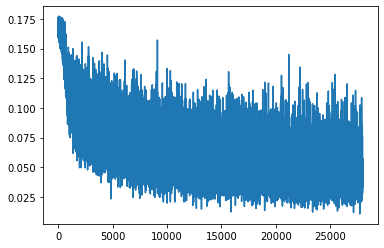

------
*********
29483 3408
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.16908271610736847
Loss:  0.16566535830497742
Loss:  0.160798579454422
0 **********
Epoch:  65.40212726593018  fold:  9  kers:  128
epoch:  1
29483 461
Loss:  0.1492086946964264
Loss:  0.14039811491966248
Loss:  0.11628784984350204
1 **********
Epoch:  118.524090051651  fold:  9  kers:  128
epoch:  2
29483 461
Loss:  0.11676986515522003
Loss:  0.09178820252418518
Loss:  0.08996215462684631
2 **********
Epoch:  171.54033589363098  fold:  9  kers:  128
epoch:  3
Eval Loss:  0.16407990455627441
Eval Loss:  1.3854403495788574
Eval Loss:  0.39195674657821655
[[1626  116]
 [ 581 1085]]
              preci

Loss:  0.08707727491855621
Loss:  0.06280108541250229
Loss:  0.06969244033098221
11 **********
Epoch:  769.11155128479  fold:  9  kers:  128
epoch:  12
Eval Loss:  0.04311279207468033
Eval Loss:  2.101079225540161
Eval Loss:  0.2798062562942505
[[1693   49]
 [ 679  987]]
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      1742
           1       0.95      0.59      0.73      1666

    accuracy                           0.79      3408
   macro avg       0.83      0.78      0.78      3408
weighted avg       0.83      0.79      0.78      3408

acc:  0.7863849765258216
pre:  0.9527027027027027
rec:  0.592436974789916
ma F1:  0.7768066075400313
mi F1:  0.7863849765258216
we F1:  0.7778377067509663
Eval Loss:  0.3012029230594635
Eval Loss:  0.3263109028339386
Eval Loss:  0.31761032342910767
Eval Loss:  0.29712048172950745
Eval Loss:  0.4052899181842804
Eval Loss:  0.28529059886932373
Eval Loss:  0.3998371958732605
Eval Loss:  0.378267318010

Eval Loss:  0.23826497793197632
Eval Loss:  0.3219217360019684
Eval Loss:  0.2362232804298401
Eval Loss:  0.25812992453575134
Eval Loss:  0.30887535214424133
Eval Loss:  0.22328996658325195
Eval Loss:  0.327978253364563
Eval Loss:  0.3496011197566986
Eval Loss:  0.2412179857492447
Eval Loss:  0.27673932909965515
Eval Loss:  0.29380157589912415
Eval Loss:  0.24011310935020447
Eval Loss:  0.2729051411151886
Eval Loss:  0.34602445363998413
Eval Loss:  0.28131338953971863
Eval Loss:  0.3000951409339905
Eval Loss:  0.29763954877853394
Eval Loss:  0.17801961302757263
Eval Loss:  0.28147149085998535
Eval Loss:  0.331788033246994
Eval Loss:  0.21510818600654602
Eval Loss:  0.2749193012714386
Eval Loss:  0.23998616635799408
Eval Loss:  0.26357904076576233
Eval Loss:  0.2245449274778366
Eval Loss:  0.2100062370300293
Eval Loss:  0.2576735019683838
Eval Loss:  0.2306899130344391
[[17696   726]
 [ 2369  8692]]
              precision    recall  f1-score   support

           0       0.88      0.96

Eval Loss:  0.17573679983615875
Eval Loss:  0.22639013826847076
Eval Loss:  0.23239752650260925
Eval Loss:  0.18171074986457825
Eval Loss:  0.17390921711921692
Eval Loss:  0.2085256576538086
[[17516   906]
 [ 1638  9423]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     18422
           1       0.91      0.85      0.88     11061

    accuracy                           0.91     29483
   macro avg       0.91      0.90      0.91     29483
weighted avg       0.91      0.91      0.91     29483

acc:  0.9137129871451345
pre:  0.9122857972698228
rec:  0.8519121236777868
ma F1:  0.906681564819656
mi F1:  0.9137129871451345
we F1:  0.9130770052914029
29483 461
Loss:  0.07454202324151993
Loss:  0.017911601811647415
Loss:  0.04468369483947754
30 **********
Epoch:  2065.2678928375244  fold:  9  kers:  128
epoch:  31
29483 461
Loss:  0.04557741805911064
Loss:  0.057850539684295654
Loss:  0.05230400338768959
31 **********
Epoch:  2118.26618599891

Loss:  0.04621906578540802
Loss:  0.07087936997413635
Loss:  0.04598904773592949
39 **********
Epoch:  2663.7008044719696  fold:  9  kers:  128
epoch:  40
29483 461
Loss:  0.058462489396333694
Loss:  0.03930460661649704
Loss:  0.028598953038454056
40 **********
Epoch:  2716.6921162605286  fold:  9  kers:  128
epoch:  41
29483 461
Loss:  0.07999680191278458
Loss:  0.08009416610002518
Loss:  0.06418716907501221
41 **********
Epoch:  2769.6574976444244  fold:  9  kers:  128
epoch:  42
Eval Loss:  0.04705654829740524
Eval Loss:  0.8822224140167236
Eval Loss:  0.18525806069374084
[[1582  160]
 [ 356 1310]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1742
           1       0.89      0.79      0.84      1666

    accuracy                           0.85      3408
   macro avg       0.85      0.85      0.85      3408
weighted avg       0.85      0.85      0.85      3408

acc:  0.8485915492957746
pre:  0.891156462585034
rec:  0.7863145

Eval Loss:  0.1484057903289795
Eval Loss:  0.2709520757198334
Eval Loss:  0.16549715399742126
Eval Loss:  0.19185759127140045
Eval Loss:  0.14797355234622955
Eval Loss:  0.13584794104099274
Eval Loss:  0.20253314077854156
Eval Loss:  0.23627176880836487
Eval Loss:  0.13439688086509705
Eval Loss:  0.167933389544487
Eval Loss:  0.1823214739561081
Eval Loss:  0.19572164118289948
Eval Loss:  0.1767854392528534
Eval Loss:  0.20198610424995422
Eval Loss:  0.2177746593952179
Eval Loss:  0.21471194922924042
Eval Loss:  0.24488505721092224
Eval Loss:  0.15839913487434387
Eval Loss:  0.21012167632579803
Eval Loss:  0.21452385187149048
Eval Loss:  0.12190603464841843
Eval Loss:  0.17477235198020935
Eval Loss:  0.1347496211528778
Eval Loss:  0.2050105482339859
Eval Loss:  0.19549037516117096
Eval Loss:  0.16284820437431335
Eval Loss:  0.1473466157913208
Eval Loss:  0.15924715995788574
[[17439   983]
 [ 1133  9928]]
              precision    recall  f1-score   support

           0       0.94     

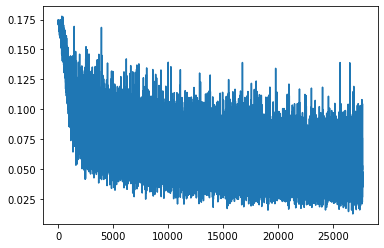

------
*********
29871 3020
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.16106022894382477
Loss:  0.16315191984176636
Loss:  0.15196692943572998
0 **********
Epoch:  66.34460687637329  fold:  10  kers:  128
epoch:  1
29871 467
Loss:  0.1283532679080963
Loss:  0.1451466679573059
Loss:  0.11504610627889633
1 **********
Epoch:  120.2634391784668  fold:  10  kers:  128
epoch:  2
29871 467
Loss:  0.10290665179491043
Loss:  0.09179035574197769
Loss:  0.09300676733255386
2 **********
Epoch:  174.06658029556274  fold:  10  kers:  128
epoch:  3
Eval Loss:  0.578580915927887
Eval Loss:  0.20355366170406342
Eval Loss:  0.12155631929636002
[[1600  151]
 [ 225 1044]]
              p

Loss:  0.040043238550424576
Loss:  0.07986024767160416
10 **********
Epoch:  728.6357753276825  fold:  10  kers:  128
epoch:  11
29871 467
Loss:  0.09913235902786255
Loss:  0.09670507162809372
Loss:  0.058847907930612564
11 **********
Epoch:  782.324223279953  fold:  10  kers:  128
epoch:  12
Eval Loss:  0.4009101986885071
Eval Loss:  0.11418996006250381
Eval Loss:  0.06256453692913055
[[1680   71]
 [ 249 1020]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1751
           1       0.93      0.80      0.86      1269

    accuracy                           0.89      3020
   macro avg       0.90      0.88      0.89      3020
weighted avg       0.90      0.89      0.89      3020

acc:  0.8940397350993378
pre:  0.9349220898258478
rec:  0.8037825059101655
ma F1:  0.8887251289609434
mi F1:  0.8940397350993377
we F1:  0.89260640192868
Eval Loss:  0.28547403216362
Eval Loss:  0.33058688044548035
Eval Loss:  0.27131617069244385
Eval Loss:

Eval Loss:  0.23356159031391144
Eval Loss:  0.3340109586715698
Eval Loss:  0.20861387252807617
Eval Loss:  0.24506796896457672
Eval Loss:  0.27210450172424316
Eval Loss:  0.2420024573802948
Eval Loss:  0.2918214797973633
Eval Loss:  0.28461921215057373
Eval Loss:  0.17978468537330627
Eval Loss:  0.26269403100013733
Eval Loss:  0.15290097892284393
Eval Loss:  0.27216970920562744
Eval Loss:  0.33613818883895874
Eval Loss:  0.33434122800827026
Eval Loss:  0.25220179557800293
Eval Loss:  0.23445484042167664
Eval Loss:  0.22298328578472137
Eval Loss:  0.20641465485095978
Eval Loss:  0.19669567048549652
Eval Loss:  0.3047233819961548
Eval Loss:  0.2562330663204193
Eval Loss:  0.17912191152572632
Eval Loss:  0.24678455293178558
Eval Loss:  0.27898719906806946
Eval Loss:  0.2031799703836441
Eval Loss:  0.19614621996879578
Eval Loss:  0.2827785909175873
Eval Loss:  0.2390580177307129
Eval Loss:  0.2738487124443054
[[17387  1026]
 [ 1959  9499]]
              precision    recall  f1-score   supp

Eval Loss:  0.2014511376619339
Eval Loss:  0.17008012533187866
Eval Loss:  0.309742271900177
Eval Loss:  0.21680934727191925
Eval Loss:  0.17185723781585693
Eval Loss:  0.19563530385494232
Eval Loss:  0.21280328929424286
Eval Loss:  0.17992419004440308
Eval Loss:  0.21487507224082947
Eval Loss:  0.21681171655654907
Eval Loss:  0.24812544882297516
Eval Loss:  0.22701770067214966
[[17259  1154]
 [ 1574  9884]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18413
           1       0.90      0.86      0.88     11458

    accuracy                           0.91     29871
   macro avg       0.91      0.90      0.90     29871
weighted avg       0.91      0.91      0.91     29871

acc:  0.9086739647149409
pre:  0.8954520746512049
rec:  0.8626287310176296
ma F1:  0.902745616415682
mi F1:  0.9086739647149409
we F1:  0.908336350303322
29871 467
Loss:  0.0718466266989708
Loss:  0.06471309065818787
Loss:  0.06030575931072235
30 **********
Epo

Loss:  0.04784002900123596
Loss:  0.048557765781879425
Loss:  0.060728155076503754
39 **********
Epoch:  2693.024299144745  fold:  10  kers:  128
epoch:  40
29871 467
Loss:  0.032129306346178055
Loss:  0.055251289159059525
Loss:  0.04859500750899315
40 **********
Epoch:  2746.701776742935  fold:  10  kers:  128
epoch:  41
29871 467
Loss:  0.04568713158369064
Loss:  0.07170258462429047
Loss:  0.07599787414073944
41 **********
Epoch:  2800.3692803382874  fold:  10  kers:  128
epoch:  42
Eval Loss:  0.3813977837562561
Eval Loss:  0.12928548455238342
Eval Loss:  0.02161078155040741
[[1648  103]
 [ 114 1155]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1751
           1       0.92      0.91      0.91      1269

    accuracy                           0.93      3020
   macro avg       0.93      0.93      0.93      3020
weighted avg       0.93      0.93      0.93      3020

acc:  0.9281456953642384
pre:  0.9181240063593005
rec:  0.910

Eval Loss:  0.17408375442028046
Eval Loss:  0.23634961247444153
Eval Loss:  0.14429320394992828
Eval Loss:  0.23318523168563843
Eval Loss:  0.20993231236934662
Eval Loss:  0.12740099430084229
Eval Loss:  0.21241699159145355
Eval Loss:  0.196391299366951
Eval Loss:  0.08012104034423828
Eval Loss:  0.1473412960767746
Eval Loss:  0.14938777685165405
Eval Loss:  0.12901736795902252
Eval Loss:  0.18273676931858063
Eval Loss:  0.2636982798576355
Eval Loss:  0.21582531929016113
Eval Loss:  0.10781903564929962
Eval Loss:  0.1469832956790924
Eval Loss:  0.17715834081172943
Eval Loss:  0.12792454659938812
Eval Loss:  0.20314405858516693
Eval Loss:  0.18282532691955566
Eval Loss:  0.13016141951084137
Eval Loss:  0.21418790519237518
Eval Loss:  0.1598609983921051
Eval Loss:  0.17524868249893188
Eval Loss:  0.15612134337425232
Eval Loss:  0.20981614291667938
Eval Loss:  0.1935313493013382
Eval Loss:  0.1723049432039261
[[17183  1230]
 [  969 10489]]
              precision    recall  f1-score   sup

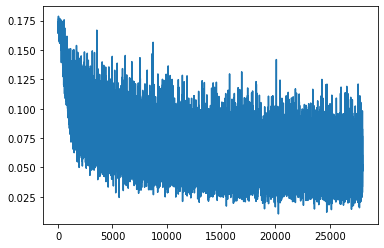

------
  
kernel: 64
  
*********
29459 3432
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.16132888197898865
Loss:  0.15579402446746826
Loss:  0.1442093849182129
0 **********
Epoch:  54.845354080200195  fold:  1  kers:  64
epoch:  1
29459 461
Loss:  0.14491046965122223
Loss:  0.10505252331495285
Loss:  0.11218127608299255
1 **********
Epoch:  97.40256476402283  fold:  1  kers:  64
epoch:  2
29459 461
Loss:  0.10461951792240143
Loss:  0.10105080902576447
Loss:  0.11203077435493469
2 **********
Epoch:  139.8341109752655  fold:  1  kers:  64
epoch:  3
Eval Loss:  0.4233071804046631
Eval Loss:  0.4816530644893646
Eval Loss:  0.20588961243629456
[[ 843  196]
 [ 726 1667]]
          

Loss:  0.09146663546562195
Loss:  0.09056150168180466
11 **********
Epoch:  642.1350607872009  fold:  1  kers:  64
epoch:  12
Eval Loss:  0.6123988628387451
Eval Loss:  0.5485507845878601
Eval Loss:  0.09388793259859085
[[ 907  132]
 [ 673 1720]]
              precision    recall  f1-score   support

           0       0.57      0.87      0.69      1039
           1       0.93      0.72      0.81      2393

    accuracy                           0.77      3432
   macro avg       0.75      0.80      0.75      3432
weighted avg       0.82      0.77      0.77      3432

acc:  0.7654428904428905
pre:  0.9287257019438445
rec:  0.7187630589218554
ma F1:  0.7514979552792382
mi F1:  0.7654428904428905
we F1:  0.7747223614435494
update!  Acc:  0.7654428904428905
Eval Loss:  0.335782915353775
Eval Loss:  0.37828582525253296
Eval Loss:  0.26716434955596924
Eval Loss:  0.24204158782958984
Eval Loss:  0.3478619456291199
Eval Loss:  0.2834284007549286
Eval Loss:  0.39562177658081055
Eval Loss:  0.26

Eval Loss:  0.25256237387657166
Eval Loss:  0.3065626323223114
Eval Loss:  0.22111400961875916
Eval Loss:  0.18526282906532288
Eval Loss:  0.3009074926376343
Eval Loss:  0.27275311946868896
Eval Loss:  0.32955244183540344
Eval Loss:  0.257525771856308
Eval Loss:  0.2637341618537903
Eval Loss:  0.3002556264400482
Eval Loss:  0.39642438292503357
Eval Loss:  0.19165697693824768
Eval Loss:  0.3381785750389099
Eval Loss:  0.3380619287490845
Eval Loss:  0.2889847457408905
Eval Loss:  0.29181715846061707
Eval Loss:  0.32195353507995605
Eval Loss:  0.3010871708393097
Eval Loss:  0.2831955850124359
Eval Loss:  0.2642204463481903
Eval Loss:  0.3930903375148773
Eval Loss:  0.28896746039390564
Eval Loss:  0.23885098099708557
Eval Loss:  0.2773424983024597
Eval Loss:  0.2760380804538727
Eval Loss:  0.3091348111629486
Eval Loss:  0.261148065328598
Eval Loss:  0.3085308074951172
[[18442   683]
 [ 2775  7559]]
              precision    recall  f1-score   support

           0       0.87      0.96    

Eval Loss:  0.18501831591129303
Eval Loss:  0.2189130336046219
Eval Loss:  0.217064768075943
Eval Loss:  0.24772559106349945
Eval Loss:  0.23015935719013214
Eval Loss:  0.23215632140636444
[[18203   922]
 [ 1846  8488]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     19125
           1       0.90      0.82      0.86     10334

    accuracy                           0.91     29459
   macro avg       0.90      0.89      0.89     29459
weighted avg       0.91      0.91      0.90     29459

acc:  0.9060389015241522
pre:  0.90201912858661
rec:  0.8213663634604219
ma F1:  0.8945731999501207
mi F1:  0.9060389015241522
we F1:  0.9049483911531377
29459 461
Loss:  0.09930142760276794
Loss:  0.06249520182609558
Loss:  0.0876886397600174
30 **********
Epoch:  1733.7716817855835  fold:  1  kers:  64
epoch:  31
29459 461
Loss:  0.06902027875185013
Loss:  0.04816341772675514
Loss:  0.06502139568328857
31 **********
Epoch:  1778.430273771286  fold

Loss:  0.05035567283630371
Loss:  0.05245837941765785
Loss:  0.06558508425951004
39 **********
Epoch:  2267.14243888855  fold:  1  kers:  64
epoch:  40
29459 461
Loss:  0.04922940209507942
Loss:  0.038215093314647675
Loss:  0.05927372723817825
40 **********
Epoch:  2309.2518470287323  fold:  1  kers:  64
epoch:  41
29459 461
Loss:  0.03879382088780403
Loss:  0.07746326923370361
Loss:  0.04502493515610695
41 **********
Epoch:  2351.3991537094116  fold:  1  kers:  64
epoch:  42
Eval Loss:  1.5644822120666504
Eval Loss:  0.258512407541275
Eval Loss:  0.1835586279630661
[[ 703  336]
 [ 204 2189]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.72      1039
           1       0.87      0.91      0.89      2393

    accuracy                           0.84      3432
   macro avg       0.82      0.80      0.81      3432
weighted avg       0.84      0.84      0.84      3432

acc:  0.8426573426573427
pre:  0.8669306930693069
rec:  0.914751358127873

Eval Loss:  0.21354562044143677
Eval Loss:  0.23233181238174438
Eval Loss:  0.17310656607151031
Eval Loss:  0.16084949672222137
Eval Loss:  0.18875399231910706
Eval Loss:  0.23764625191688538
Eval Loss:  0.2560373544692993
Eval Loss:  0.20944678783416748
Eval Loss:  0.18342837691307068
Eval Loss:  0.2276822179555893
Eval Loss:  0.32215455174446106
Eval Loss:  0.11904144287109375
Eval Loss:  0.22549009323120117
Eval Loss:  0.2598128616809845
Eval Loss:  0.252248615026474
Eval Loss:  0.2256470024585724
Eval Loss:  0.2266777902841568
Eval Loss:  0.20139992237091064
Eval Loss:  0.16555164754390717
Eval Loss:  0.17211106419563293
Eval Loss:  0.28259289264678955
Eval Loss:  0.23746807873249054
Eval Loss:  0.18883904814720154
Eval Loss:  0.21602772176265717
Eval Loss:  0.21015062928199768
Eval Loss:  0.22759909927845
Eval Loss:  0.20874328911304474
Eval Loss:  0.23456937074661255
[[18302   823]
 [ 1587  8747]]
              precision    recall  f1-score   support

           0       0.92     

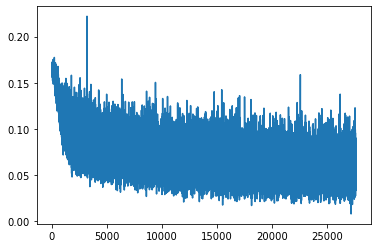

------
*********
29797 3094
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.16796597838401794
Loss:  0.16163432598114014
Loss:  0.16095997393131256
0 **********
Epoch:  55.12061810493469  fold:  2  kers:  64
epoch:  1
29797 466
Loss:  0.1491450071334839
Loss:  0.1360141485929489
Loss:  0.13052405416965485
1 **********
Epoch:  98.8756263256073  fold:  2  kers:  64
epoch:  2
29797 466
Loss:  0.10670167207717896
Loss:  0.14084912836551666
Loss:  0.11842162907123566
2 **********
Epoch:  277.7950813770294  fold:  2  kers:  64
epoch:  3
Eval Loss:  1.2631655931472778
Eval Loss:  0.061026688665151596
Eval Loss:  1.155139684677124
[[1308  122]
 [ 965  699]]
              precision    rec

Loss:  0.06035277247428894
Loss:  0.06708958745002747
Loss:  0.0776333212852478
11 **********
Epoch:  876.1631700992584  fold:  2  kers:  64
epoch:  12
Eval Loss:  0.8262110352516174
Eval Loss:  0.13778823614120483
Eval Loss:  0.5668264627456665
[[1341   89]
 [ 778  886]]
              precision    recall  f1-score   support

           0       0.63      0.94      0.76      1430
           1       0.91      0.53      0.67      1664

    accuracy                           0.72      3094
   macro avg       0.77      0.74      0.71      3094
weighted avg       0.78      0.72      0.71      3094

acc:  0.7197802197802198
pre:  0.9087179487179488
rec:  0.5324519230769231
ma F1:  0.7135861485994113
mi F1:  0.7197802197802198
we F1:  0.7104006262778525
Eval Loss:  0.27741971611976624
Eval Loss:  0.23032380640506744
Eval Loss:  0.26424044370651245
Eval Loss:  0.35922881960868835
Eval Loss:  0.30334779620170593
Eval Loss:  0.2641352117061615
Eval Loss:  0.31235435605049133
Eval Loss:  0.3542986

Eval Loss:  0.2856721580028534
Eval Loss:  0.1903621107339859
Eval Loss:  0.19169726967811584
Eval Loss:  0.2655157148838043
Eval Loss:  0.24665507674217224
Eval Loss:  0.2609511613845825
Eval Loss:  0.28937456011772156
Eval Loss:  0.30561918020248413
Eval Loss:  0.23288823664188385
Eval Loss:  0.23944728076457977
Eval Loss:  0.2652822732925415
Eval Loss:  0.2091110199689865
Eval Loss:  0.33475521206855774
Eval Loss:  0.12067610770463943
Eval Loss:  0.24019496142864227
Eval Loss:  0.31680169701576233
Eval Loss:  0.22578006982803345
Eval Loss:  0.21985945105552673
Eval Loss:  0.2871066927909851
Eval Loss:  0.24801456928253174
Eval Loss:  0.23304033279418945
Eval Loss:  0.288774698972702
Eval Loss:  0.34635311365127563
Eval Loss:  0.20163670182228088
Eval Loss:  0.23147957026958466
Eval Loss:  0.3253086805343628
Eval Loss:  0.38884371519088745
Eval Loss:  0.22121623158454895
Eval Loss:  0.21066522598266602
[[18102   632]
 [ 2497  8566]]
              precision    recall  f1-score   suppo

Eval Loss:  0.18044179677963257
Eval Loss:  0.2542590796947479
Eval Loss:  0.32054024934768677
Eval Loss:  0.16558344662189484
Eval Loss:  0.1832430213689804
Eval Loss:  0.29967543482780457
Eval Loss:  0.3632892668247223
Eval Loss:  0.2152094542980194
Eval Loss:  0.18459883332252502
[[18016   718]
 [ 2072  8991]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     18734
           1       0.93      0.81      0.87     11063

    accuracy                           0.91     29797
   macro avg       0.91      0.89      0.90     29797
weighted avg       0.91      0.91      0.90     29797

acc:  0.9063664127261134
pre:  0.926047996704089
rec:  0.8127090301003345
ma F1:  0.8969090539615239
mi F1:  0.9063664127261134
we F1:  0.9049475469347278
29797 466
Loss:  0.07882636785507202
Loss:  0.03983483463525772
Loss:  0.08818056434392929
30 **********
Epoch:  1997.5980920791626  fold:  2  kers:  64
epoch:  31
29797 466
Loss:  0.04143790900707245
Lo

Loss:  0.061359673738479614
Loss:  0.06927288323640823
Loss:  0.03450625762343407
39 **********
Epoch:  2516.321158885956  fold:  2  kers:  64
epoch:  40
29797 466
Loss:  0.05978669971227646
Loss:  0.052077990025281906
Loss:  0.05177704617381096
40 **********
Epoch:  2560.52197432518  fold:  2  kers:  64
epoch:  41
29797 466
Loss:  0.06986326724290848
Loss:  0.05537818372249603
Loss:  0.037058696150779724
41 **********
Epoch:  2604.571195602417  fold:  2  kers:  64
epoch:  42
Eval Loss:  0.5014936327934265
Eval Loss:  0.23655134439468384
Eval Loss:  0.891647219657898
[[1258  172]
 [ 590 1074]]
              precision    recall  f1-score   support

           0       0.68      0.88      0.77      1430
           1       0.86      0.65      0.74      1664

    accuracy                           0.75      3094
   macro avg       0.77      0.76      0.75      3094
weighted avg       0.78      0.75      0.75      3094

acc:  0.7537168713639302
pre:  0.8619582664526485
rec:  0.64543269230769

Eval Loss:  0.2926919162273407
Eval Loss:  0.11779917031526566
Eval Loss:  0.1197555735707283
Eval Loss:  0.20302559435367584
Eval Loss:  0.179756298661232
Eval Loss:  0.14631016552448273
Eval Loss:  0.20136071741580963
Eval Loss:  0.20922936499118805
Eval Loss:  0.14684756100177765
Eval Loss:  0.18787230551242828
Eval Loss:  0.23725980520248413
Eval Loss:  0.13478577136993408
Eval Loss:  0.27286502718925476
Eval Loss:  0.10405712574720383
Eval Loss:  0.17916809022426605
Eval Loss:  0.16990289092063904
Eval Loss:  0.1858006715774536
Eval Loss:  0.14799487590789795
Eval Loss:  0.1939806193113327
Eval Loss:  0.14824983477592468
Eval Loss:  0.12474469840526581
Eval Loss:  0.21668171882629395
Eval Loss:  0.2706484794616699
Eval Loss:  0.11366789788007736
Eval Loss:  0.15927967429161072
Eval Loss:  0.26111677289009094
Eval Loss:  0.29913175106048584
Eval Loss:  0.15407614409923553
Eval Loss:  0.16091394424438477
[[17973   761]
 [ 1502  9561]]
              precision    recall  f1-score   su

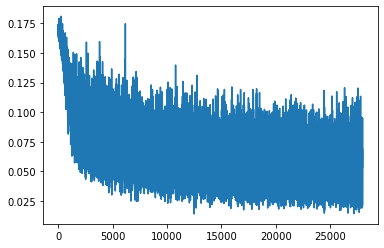

------
*********
29460 3431
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1692742258310318
Loss:  0.16327667236328125
Loss:  0.1539754420518875
0 **********
Epoch:  64.35193514823914  fold:  3  kers:  64
epoch:  1
29460 461
Loss:  0.14103253185749054
Loss:  0.1500866711139679
Loss:  0.12195885181427002
1 **********
Epoch:  108.19869780540466  fold:  3  kers:  64
epoch:  2
29460 461
Loss:  0.1221524327993393
Loss:  0.10506720095872879
Loss:  0.14766350388526917
2 **********
Epoch:  151.99958276748657  fold:  3  kers:  64
epoch:  3
Eval Loss:  0.9357452988624573
Eval Loss:  0.9027650952339172
Eval Loss:  0.3454551100730896
[[1322  214]
 [ 625 1270]]
              precision    rec

Loss:  0.08401267230510712
Loss:  0.058215245604515076
Loss:  0.08214226365089417
11 **********
Epoch:  669.799230337143  fold:  3  kers:  64
epoch:  12
Eval Loss:  1.2575609683990479
Eval Loss:  0.3754345774650574
Eval Loss:  0.715817391872406
[[1414  122]
 [ 791 1104]]
              precision    recall  f1-score   support

           0       0.64      0.92      0.76      1536
           1       0.90      0.58      0.71      1895

    accuracy                           0.73      3431
   macro avg       0.77      0.75      0.73      3431
weighted avg       0.78      0.73      0.73      3431

acc:  0.7338968230836491
pre:  0.9004893964110929
rec:  0.5825857519788918
ma F1:  0.73170658175156
mi F1:  0.7338968230836491
we F1:  0.7291701409831084
Eval Loss:  0.2845573425292969
Eval Loss:  0.4735051989555359
Eval Loss:  0.44531768560409546
Eval Loss:  0.4028710424900055
Eval Loss:  0.41287973523139954
Eval Loss:  0.3534962832927704
Eval Loss:  0.35253268480300903
Eval Loss:  0.3866593539714

Eval Loss:  0.19470544159412384
Eval Loss:  0.2773257791996002
Eval Loss:  0.2894067168235779
Eval Loss:  0.22880296409130096
Eval Loss:  0.2746853828430176
Eval Loss:  0.20342454314231873
Eval Loss:  0.21630799770355225
Eval Loss:  0.24633829295635223
Eval Loss:  0.3361438512802124
Eval Loss:  0.24140650033950806
Eval Loss:  0.2185530662536621
Eval Loss:  0.2673623859882355
Eval Loss:  0.27485719323158264
Eval Loss:  0.24455080926418304
Eval Loss:  0.2287365347146988
Eval Loss:  0.25421059131622314
Eval Loss:  0.2765916883945465
Eval Loss:  0.1943926066160202
Eval Loss:  0.23109732568264008
Eval Loss:  0.22686165571212769
Eval Loss:  0.2845243513584137
Eval Loss:  0.22406898438930511
Eval Loss:  0.3079472780227661
Eval Loss:  0.24405428767204285
Eval Loss:  0.3256787359714508
Eval Loss:  0.29066017270088196
Eval Loss:  0.2412489950656891
Eval Loss:  0.17934323847293854
[[17405  1223]
 [ 1664  9168]]
              precision    recall  f1-score   support

           0       0.91      0.

Eval Loss:  0.24233651161193848
Eval Loss:  0.3514406979084015
Eval Loss:  0.3164931833744049
Eval Loss:  0.2258674055337906
Eval Loss:  0.15294340252876282
[[16658  1970]
 [  905  9927]]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     18628
           1       0.83      0.92      0.87     10832

    accuracy                           0.90     29460
   macro avg       0.89      0.91      0.90     29460
weighted avg       0.91      0.90      0.90     29460

acc:  0.9024100475220638
pre:  0.8344120366478944
rec:  0.9164512555391433
ma F1:  0.8970349867899831
mi F1:  0.9024100475220638
we F1:  0.9032605065444477
29460 461
Loss:  0.04064643755555153
Loss:  0.0808725655078888
Loss:  0.04865574836730957
30 **********
Epoch:  1785.1507670879364  fold:  3  kers:  64
epoch:  31
29460 461
Loss:  0.050434011965990067
Loss:  0.050440382212400436
Loss:  0.09148585796356201
31 **********
Epoch:  1828.5918543338776  fold:  3  kers:  64
epoch:  32


Loss:  0.03862834349274635
Loss:  0.06260540336370468
39 **********
Epoch:  2299.086541891098  fold:  3  kers:  64
epoch:  40
29460 461
Loss:  0.06707850843667984
Loss:  0.06738662719726562
Loss:  0.03450535237789154
40 **********
Epoch:  2342.759918689728  fold:  3  kers:  64
epoch:  41
29460 461
Loss:  0.07178597897291183
Loss:  0.03976865112781525
Loss:  0.036307670176029205
41 **********
Epoch:  2386.4707622528076  fold:  3  kers:  64
epoch:  42
Eval Loss:  0.30530786514282227
Eval Loss:  0.08411525189876556
Eval Loss:  0.6939490437507629
[[1151  385]
 [ 443 1452]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      1536
           1       0.79      0.77      0.78      1895

    accuracy                           0.76      3431
   macro avg       0.76      0.76      0.76      3431
weighted avg       0.76      0.76      0.76      3431

acc:  0.7586709414164966
pre:  0.7904191616766467
rec:  0.7662269129287599
ma F1:  0.756799153508

Eval Loss:  0.1806587129831314
Eval Loss:  0.14864151179790497
Eval Loss:  0.22625206410884857
Eval Loss:  0.14343775808811188
Eval Loss:  0.2319495528936386
Eval Loss:  0.1583729386329651
Eval Loss:  0.17256568372249603
Eval Loss:  0.14330697059631348
Eval Loss:  0.2265043556690216
Eval Loss:  0.16297365725040436
Eval Loss:  0.15187528729438782
Eval Loss:  0.20467565953731537
Eval Loss:  0.21525712311267853
Eval Loss:  0.16771343350410461
Eval Loss:  0.15759900212287903
Eval Loss:  0.22964002192020416
Eval Loss:  0.23859089612960815
Eval Loss:  0.18035273253917694
Eval Loss:  0.15285183489322662
Eval Loss:  0.16309703886508942
Eval Loss:  0.2316868007183075
Eval Loss:  0.22433693706989288
Eval Loss:  0.2596254348754883
Eval Loss:  0.1955239623785019
Eval Loss:  0.25106802582740784
Eval Loss:  0.27846425771713257
Eval Loss:  0.19085286557674408
Eval Loss:  0.11649211496114731
[[17387  1241]
 [ 1042  9790]]
              precision    recall  f1-score   support

           0       0.94  

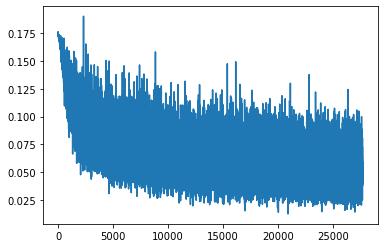

------
*********
29520 3371
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.17029014229774475
Loss:  0.16691747307777405
Loss:  0.16163873672485352
0 **********
Epoch:  56.50491666793823  fold:  4  kers:  64
epoch:  1
29520 462
Loss:  0.1510513573884964
Loss:  0.12880265712738037
Loss:  0.12221792340278625
1 **********
Epoch:  100.38060212135315  fold:  4  kers:  64
epoch:  2
29520 462
Loss:  0.10673146694898605
Loss:  0.09953870624303818
Loss:  0.0971193015575409
2 **********
Epoch:  144.25927877426147  fold:  4  kers:  64
epoch:  3
Eval Loss:  0.4851263463497162
Eval Loss:  0.40126457810401917
Eval Loss:  0.11534677445888519
[[2689  448]
 [ 148   86]]
              precision   

Loss:  0.11128748953342438
Loss:  0.08656901866197586
Loss:  0.05298846587538719
11 **********
Epoch:  661.8204255104065  fold:  4  kers:  64
epoch:  12
Eval Loss:  0.028743524104356766
Eval Loss:  0.13895025849342346
Eval Loss:  0.03884027898311615
[[3076   61]
 [ 218   16]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      3137
           1       0.21      0.07      0.10       234

    accuracy                           0.92      3371
   macro avg       0.57      0.52      0.53      3371
weighted avg       0.88      0.92      0.90      3371

acc:  0.9172352417680214
pre:  0.2077922077922078
rec:  0.06837606837606838
ma F1:  0.5297551400196295
mi F1:  0.9172352417680214
we F1:  0.8973547267436758
Eval Loss:  0.29783132672309875
Eval Loss:  0.3591923713684082
Eval Loss:  0.3352407217025757
Eval Loss:  0.21866251528263092
Eval Loss:  0.24711638689041138
Eval Loss:  0.228504478931427
Eval Loss:  0.2812517583370209
Eval Loss:  0.336581

Eval Loss:  0.2953416407108307
Eval Loss:  0.2754749357700348
Eval Loss:  0.2589183747768402
Eval Loss:  0.15408848226070404
Eval Loss:  0.18415148556232452
Eval Loss:  0.18561038374900818
Eval Loss:  0.19729828834533691
Eval Loss:  0.25959697365760803
Eval Loss:  0.2293921262025833
Eval Loss:  0.2850068509578705
Eval Loss:  0.22865915298461914
Eval Loss:  0.2956671118736267
Eval Loss:  0.28916826844215393
Eval Loss:  0.26822298765182495
Eval Loss:  0.22346116602420807
Eval Loss:  0.25331631302833557
Eval Loss:  0.1759406179189682
Eval Loss:  0.2632487714290619
Eval Loss:  0.22386129200458527
Eval Loss:  0.34559082984924316
Eval Loss:  0.2067459374666214
Eval Loss:  0.2706902325153351
Eval Loss:  0.2973172664642334
Eval Loss:  0.22843244671821594
Eval Loss:  0.28822067379951477
Eval Loss:  0.2910906970500946
Eval Loss:  0.2962729036808014
Eval Loss:  0.27260205149650574
[[15829  1198]
 [ 1829 10664]]
              precision    recall  f1-score   support

           0       0.90      0.

Eval Loss:  0.20217624306678772
Eval Loss:  0.3018087148666382
Eval Loss:  0.272352397441864
Eval Loss:  0.2883571982383728
Eval Loss:  0.21523363888263702
[[16062   965]
 [ 1820 10673]]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     17027
           1       0.92      0.85      0.88     12493

    accuracy                           0.91     29520
   macro avg       0.91      0.90      0.90     29520
weighted avg       0.91      0.91      0.91     29520

acc:  0.9056571815718157
pre:  0.9170819728475683
rec:  0.854318418314256
ma F1:  0.9024047176660989
mi F1:  0.9056571815718157
we F1:  0.9051411569588286
29520 462
Loss:  0.06334812194108963
Loss:  0.08744069933891296
Loss:  0.04193483293056488
30 **********
Epoch:  1783.9234738349915  fold:  4  kers:  64
epoch:  31
29520 462
Loss:  0.04946322739124298
Loss:  0.04400407895445824
Loss:  0.08574401587247849
31 **********
Epoch:  1827.668508052826  fold:  4  kers:  64
epoch:  32
2952

Loss:  0.050137922167778015
39 **********
Epoch:  2299.72332906723  fold:  4  kers:  64
epoch:  40
29520 462
Loss:  0.07234103232622147
Loss:  0.02839195728302002
Loss:  0.06500238925218582
40 **********
Epoch:  2343.5092544555664  fold:  4  kers:  64
epoch:  41
29520 462
Loss:  0.05819166824221611
Loss:  0.07188442349433899
Loss:  0.04222925007343292
41 **********
Epoch:  2387.4537556171417  fold:  4  kers:  64
epoch:  42
Eval Loss:  0.34629058837890625
Eval Loss:  0.19717703759670258
Eval Loss:  0.00939076580107212
[[2979  158]
 [ 218   16]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3137
           1       0.09      0.07      0.08       234

    accuracy                           0.89      3371
   macro avg       0.51      0.51      0.51      3371
weighted avg       0.87      0.89      0.88      3371

acc:  0.8884603975081579
pre:  0.09195402298850575
rec:  0.06837606837606838
ma F1:  0.5095346000730574
mi F1:  0.888460397

Eval Loss:  0.24733757972717285
Eval Loss:  0.22159342467784882
Eval Loss:  0.2091800570487976
Eval Loss:  0.1321888417005539
Eval Loss:  0.15566317737102509
Eval Loss:  0.1439763605594635
Eval Loss:  0.18123528361320496
Eval Loss:  0.19829000532627106
Eval Loss:  0.20360299944877625
Eval Loss:  0.21363230049610138
Eval Loss:  0.19058731198310852
Eval Loss:  0.2502875030040741
Eval Loss:  0.18486908078193665
Eval Loss:  0.22040370106697083
Eval Loss:  0.15038181841373444
Eval Loss:  0.21176482737064362
Eval Loss:  0.1871621310710907
Eval Loss:  0.197956383228302
Eval Loss:  0.22321000695228577
Eval Loss:  0.22124561667442322
Eval Loss:  0.1584094762802124
Eval Loss:  0.215431809425354
Eval Loss:  0.23326469957828522
Eval Loss:  0.22400212287902832
Eval Loss:  0.2429022341966629
Eval Loss:  0.25798261165618896
Eval Loss:  0.2594677805900574
Eval Loss:  0.18497656285762787
[[15791  1236]
 [ 1276 11217]]
              precision    recall  f1-score   support

           0       0.93      0

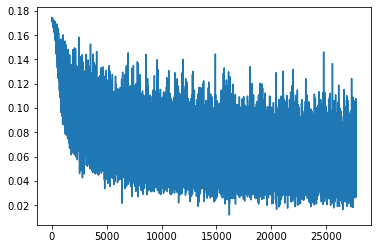

------
*********
29673 3218
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.17216897010803223
Loss:  0.16597811877727509
Loss:  0.15697763860225677
0 **********
Epoch:  56.8819100856781  fold:  5  kers:  64
epoch:  1
29673 464
Loss:  0.14137254655361176
Loss:  0.14431317150592804
Loss:  0.12834222614765167
1 **********
Epoch:  101.04981327056885  fold:  5  kers:  64
epoch:  2
29673 464
Loss:  0.1195196732878685
Loss:  0.12537026405334473
Loss:  0.10794138163328171
2 **********
Epoch:  145.15089583396912  fold:  5  kers:  64
epoch:  3
Eval Loss:  0.1788640022277832
Eval Loss:  0.37000572681427
Eval Loss:  0.29124587774276733
[[2742  355]
 [  33   88]]
              precision    re

Loss:  0.08900798857212067
Loss:  0.09476111084222794
10 **********
Epoch:  621.7565491199493  fold:  5  kers:  64
epoch:  11
29673 464
Loss:  0.0783526673913002
Loss:  0.10099383443593979
Loss:  0.1055571660399437
11 **********
Epoch:  665.878576040268  fold:  5  kers:  64
epoch:  12
Eval Loss:  0.09899690747261047
Eval Loss:  0.28617241978645325
Eval Loss:  0.05584665387868881
[[3007   90]
 [  27   94]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3097
           1       0.51      0.78      0.62       121

    accuracy                           0.96      3218
   macro avg       0.75      0.87      0.80      3218
weighted avg       0.97      0.96      0.97      3218

acc:  0.9636420136730889
pre:  0.5108695652173914
rec:  0.7768595041322314
ma F1:  0.7986550478487451
mi F1:  0.9636420136730889
we F1:  0.9672102178773229
update!  Acc:  0.9636420136730889
Eval Loss:  0.29521453380584717
Eval Loss:  0.3772188723087311
Eval Loss: 

Eval Loss:  0.24445313215255737
Eval Loss:  0.38507702946662903
Eval Loss:  0.24279898405075073
Eval Loss:  0.2573867440223694
Eval Loss:  0.3373316526412964
Eval Loss:  0.2424667328596115
Eval Loss:  0.21415868401527405
Eval Loss:  0.2804758846759796
Eval Loss:  0.21158762276172638
Eval Loss:  0.2802545428276062
Eval Loss:  0.29689592123031616
Eval Loss:  0.23136310279369354
Eval Loss:  0.3122371435165405
Eval Loss:  0.2944508194923401
Eval Loss:  0.22566592693328857
Eval Loss:  0.23583897948265076
Eval Loss:  0.32410335540771484
Eval Loss:  0.32374119758605957
Eval Loss:  0.2661815583705902
Eval Loss:  0.3009659945964813
Eval Loss:  0.30580154061317444
Eval Loss:  0.33411315083503723
Eval Loss:  0.28603681921958923
Eval Loss:  0.347929447889328
Eval Loss:  0.25205299258232117
Eval Loss:  0.3142993748188019
Eval Loss:  0.3529804050922394
Eval Loss:  0.31606757640838623
Eval Loss:  0.3015967309474945
[[16360   707]
 [ 3153  9453]]
              precision    recall  f1-score   support



Eval Loss:  0.3099837005138397
Eval Loss:  0.24680474400520325
Eval Loss:  0.31396302580833435
Eval Loss:  0.31917575001716614
Eval Loss:  0.358474463224411
Eval Loss:  0.3040141761302948
Eval Loss:  0.34282317757606506
Eval Loss:  0.2790512144565582
Eval Loss:  0.3388845920562744
Eval Loss:  0.362076073884964
Eval Loss:  0.3468879759311676
Eval Loss:  0.30943918228149414
[[16582   485]
 [ 3451  9155]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     17067
           1       0.95      0.73      0.82     12606

    accuracy                           0.87     29673
   macro avg       0.89      0.85      0.86     29673
weighted avg       0.88      0.87      0.86     29673

acc:  0.8673541603477909
pre:  0.9496887966804979
rec:  0.7262414723147708
ma F1:  0.858488835813604
mi F1:  0.8673541603477909
we F1:  0.8638137601096869
29673 464
Loss:  0.063650943338871
Loss:  0.06269650161266327
Loss:  0.06960313767194748
30 **********
Epoch:  1

Loss:  0.07835027575492859
Loss:  0.05263790488243103
Loss:  0.0703079029917717
39 **********
Epoch:  2313.440597295761  fold:  5  kers:  64
epoch:  40
29673 464
Loss:  0.08121863752603531
Loss:  0.08486060053110123
Loss:  0.0575544536113739
40 **********
Epoch:  2357.44394159317  fold:  5  kers:  64
epoch:  41
29673 464
Loss:  0.07509753853082657
Loss:  0.07630477845668793
Loss:  0.10374534875154495
41 **********
Epoch:  2401.424346923828  fold:  5  kers:  64
epoch:  42
Eval Loss:  0.05758441984653473
Eval Loss:  0.05005260929465294
Eval Loss:  0.024821842089295387
[[3081   16]
 [  51   70]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3097
           1       0.81      0.58      0.68       121

    accuracy                           0.98      3218
   macro avg       0.90      0.79      0.83      3218
weighted avg       0.98      0.98      0.98      3218

acc:  0.9791796146674954
pre:  0.813953488372093
rec:  0.5785123966942148

 [  76   45]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3097
           1       0.73      0.37      0.49       121

    accuracy                           0.97      3218
   macro avg       0.85      0.68      0.74      3218
weighted avg       0.97      0.97      0.97      3218

acc:  0.971100062150404
pre:  0.7258064516129032
rec:  0.371900826446281
ma F1:  0.7384652088309087
mi F1:  0.971100062150404
we F1:  0.9665776712621502
Eval Loss:  0.22387275099754333
Eval Loss:  0.3277823328971863
Eval Loss:  0.22805118560791016
Eval Loss:  0.21234457194805145
Eval Loss:  0.305595725774765
Eval Loss:  0.23892971873283386
Eval Loss:  0.21982437372207642
Eval Loss:  0.2842733561992645
Eval Loss:  0.22430501878261566
Eval Loss:  0.2415294647216797
Eval Loss:  0.2686420679092407
Eval Loss:  0.23565372824668884
Eval Loss:  0.2526213526725769
Eval Loss:  0.28825297951698303
Eval Loss:  0.16654585301876068
Eval Loss:  0.22293801605701447
E

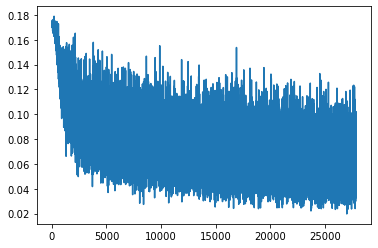

------
*********
29479 3412
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.16376829147338867
Loss:  0.16542237997055054
Loss:  0.1703963577747345
0 **********
Epoch:  56.587695360183716  fold:  6  kers:  64
epoch:  1
29479 461
Loss:  0.15462327003479004
Loss:  0.14560984075069427
Loss:  0.12713757157325745
1 **********
Epoch:  100.57607936859131  fold:  6  kers:  64
epoch:  2
29479 461
Loss:  0.139032244682312
Loss:  0.10697974264621735
Loss:  0.1222558468580246
2 **********
Epoch:  144.62431478500366  fold:  6  kers:  64
epoch:  3
Eval Loss:  0.09686534106731415
Eval Loss:  0.35690194368362427
Eval Loss:  0.5847145318984985
[[1897  335]
 [ 160 1020]]
              precision    

Loss:  0.0683475211262703
Loss:  0.081648088991642
Loss:  0.09674070030450821
11 **********
Epoch:  661.5850865840912  fold:  6  kers:  64
epoch:  12
Eval Loss:  0.032339029014110565
Eval Loss:  0.27516064047813416
Eval Loss:  0.4046888053417206
[[2086  146]
 [ 244  936]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2232
           1       0.87      0.79      0.83      1180

    accuracy                           0.89      3412
   macro avg       0.88      0.86      0.87      3412
weighted avg       0.88      0.89      0.88      3412

acc:  0.8856975381008206
pre:  0.8650646950092421
rec:  0.7932203389830509
ma F1:  0.8710486931019366
mi F1:  0.8856975381008206
we F1:  0.8844492017443939
update!  Acc:  0.8856975381008206
Eval Loss:  0.3113957345485687
Eval Loss:  0.30117282271385193
Eval Loss:  0.3642456829547882
Eval Loss:  0.3318505585193634
Eval Loss:  0.27469196915626526
Eval Loss:  0.2855260670185089
Eval Loss:  0.47562819

Eval Loss:  0.25210633873939514
Eval Loss:  0.24849069118499756
Eval Loss:  0.3052586615085602
Eval Loss:  0.32788586616516113
Eval Loss:  0.22462047636508942
Eval Loss:  0.2666938304901123
Eval Loss:  0.3983553946018219
Eval Loss:  0.26302236318588257
Eval Loss:  0.34084856510162354
Eval Loss:  0.4068398177623749
Eval Loss:  0.23173488676548004
Eval Loss:  0.3546220064163208
Eval Loss:  0.3303180932998657
Eval Loss:  0.3238900303840637
Eval Loss:  0.20781689882278442
Eval Loss:  0.26476991176605225
Eval Loss:  0.3172987997531891
Eval Loss:  0.4087575674057007
Eval Loss:  0.33788979053497314
Eval Loss:  0.2885213792324066
Eval Loss:  0.19341853260993958
Eval Loss:  0.24885901808738708
Eval Loss:  0.3054371178150177
Eval Loss:  0.28267890214920044
Eval Loss:  0.24275630712509155
Eval Loss:  0.2709766626358032
Eval Loss:  0.24144503474235535
Eval Loss:  0.3134053945541382
[[17397   535]
 [ 3254  8293]]
              precision    recall  f1-score   support

           0       0.84      0.

Eval Loss:  0.23271125555038452
Eval Loss:  0.22750011086463928
Eval Loss:  0.1940990537405014
Eval Loss:  0.1578993946313858
Eval Loss:  0.25201213359832764
[[17190   742]
 [ 2313  9234]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     17932
           1       0.93      0.80      0.86     11547

    accuracy                           0.90     29479
   macro avg       0.90      0.88      0.89     29479
weighted avg       0.90      0.90      0.89     29479

acc:  0.8963669052545881
pre:  0.9256214915797915
rec:  0.7996882307092751
ma F1:  0.8882253500268684
mi F1:  0.8963669052545881
we F1:  0.8947592653271436
29479 461
Loss:  0.06562264263629913
Loss:  0.05906664952635765
Loss:  0.0799616202712059
30 **********
Epoch:  1778.6834971904755  fold:  6  kers:  64
epoch:  31
29479 461
Loss:  0.06506197154521942
Loss:  0.07370559126138687
Loss:  0.06256061792373657
31 **********
Epoch:  1822.4225482940674  fold:  6  kers:  64
epoch:  32
2

Loss:  0.05635882914066315
Loss:  0.11597996205091476
39 **********
Epoch:  2294.3965849876404  fold:  6  kers:  64
epoch:  40
29479 461
Loss:  0.04103963449597359
Loss:  0.03239286690950394
Loss:  0.05706159397959709
40 **********
Epoch:  2338.1166863441467  fold:  6  kers:  64
epoch:  41
29479 461
Loss:  0.07712407410144806
Loss:  0.04823921620845795
Loss:  0.04587782174348831
41 **********
Epoch:  2381.8477590084076  fold:  6  kers:  64
epoch:  42
Eval Loss:  0.007043694145977497
Eval Loss:  0.17355464398860931
Eval Loss:  0.2934514880180359
[[2099  133]
 [ 301  879]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2232
           1       0.87      0.74      0.80      1180

    accuracy                           0.87      3412
   macro avg       0.87      0.84      0.85      3412
weighted avg       0.87      0.87      0.87      3412

acc:  0.8728018757327081
pre:  0.8685770750988142
rec:  0.7449152542372881
ma F1:  0.8541556358

Eval Loss:  0.1334172934293747
Eval Loss:  0.17060144245624542
Eval Loss:  0.18795998394489288
Eval Loss:  0.23888131976127625
Eval Loss:  0.14417579770088196
Eval Loss:  0.18017491698265076
Eval Loss:  0.23450249433517456
Eval Loss:  0.18888795375823975
Eval Loss:  0.1850605458021164
Eval Loss:  0.24982020258903503
Eval Loss:  0.2027091234922409
Eval Loss:  0.19539520144462585
Eval Loss:  0.25688159465789795
Eval Loss:  0.23014988005161285
Eval Loss:  0.11962371319532394
Eval Loss:  0.17080862820148468
Eval Loss:  0.19561386108398438
Eval Loss:  0.23637855052947998
Eval Loss:  0.18862780928611755
Eval Loss:  0.17891830205917358
Eval Loss:  0.154351606965065
Eval Loss:  0.17999768257141113
Eval Loss:  0.18964649736881256
Eval Loss:  0.19730672240257263
Eval Loss:  0.19639834761619568
Eval Loss:  0.13799700140953064
Eval Loss:  0.1487235575914383
Eval Loss:  0.1779433786869049
[[17096   836]
 [ 1577  9970]]
              precision    recall  f1-score   support

           0       0.92  

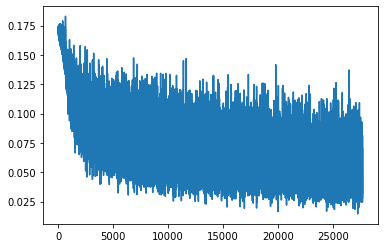

------
*********
29460 3431
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.16980792582035065
Loss:  0.16336099803447723
Loss:  0.14710186421871185
0 **********
Epoch:  56.668479204177856  fold:  7  kers:  64
epoch:  1
29460 461
Loss:  0.13028527796268463
Loss:  0.13771285116672516
Loss:  0.09815096110105515
1 **********
Epoch:  100.60699653625488  fold:  7  kers:  64
epoch:  2
29460 461
Loss:  0.09484244138002396
Loss:  0.09589570760726929
Loss:  0.10328377038240433
2 **********
Epoch:  144.44777536392212  fold:  7  kers:  64
epoch:  3
Eval Loss:  0.7062596082687378
Eval Loss:  0.21134448051452637
Eval Loss:  1.400739073753357
[[1580  547]
 [ 531  773]]
              precision  

Loss:  0.07533161342144012
Loss:  0.07147708535194397
Loss:  0.10204943269491196
11 **********
Epoch:  661.8433468341827  fold:  7  kers:  64
epoch:  12
Eval Loss:  1.005646824836731
Eval Loss:  0.08281362801790237
Eval Loss:  2.8746001720428467
[[2070   57]
 [ 928  376]]
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      2127
           1       0.87      0.29      0.43      1304

    accuracy                           0.71      3431
   macro avg       0.78      0.63      0.62      3431
weighted avg       0.76      0.71      0.67      3431

acc:  0.7129116875546488
pre:  0.8683602771362586
rec:  0.2883435582822086
ma F1:  0.6203676088574357
mi F1:  0.7129116875546487
we F1:  0.6653285160403202
Eval Loss:  0.4670485556125641
Eval Loss:  0.3401625454425812
Eval Loss:  0.41791272163391113
Eval Loss:  0.4149775803089142
Eval Loss:  0.28113648295402527
Eval Loss:  0.46136870980262756
Eval Loss:  0.4567681849002838
Eval Loss:  0.3330108225

Eval Loss:  0.3379649519920349
Eval Loss:  0.21836385130882263
Eval Loss:  0.1636641025543213
Eval Loss:  0.21288998425006866
Eval Loss:  0.24791577458381653
Eval Loss:  0.30131492018699646
Eval Loss:  0.281747967004776
Eval Loss:  0.17163300514221191
Eval Loss:  0.24395111203193665
Eval Loss:  0.22724542021751404
Eval Loss:  0.17798541486263275
Eval Loss:  0.1785229742527008
Eval Loss:  0.2873977720737457
Eval Loss:  0.2434203326702118
Eval Loss:  0.24617761373519897
Eval Loss:  0.29574844241142273
Eval Loss:  0.26143890619277954
Eval Loss:  0.2785983383655548
Eval Loss:  0.25701776146888733
Eval Loss:  0.28612637519836426
Eval Loss:  0.23169808089733124
Eval Loss:  0.2420782446861267
Eval Loss:  0.2037985920906067
Eval Loss:  0.2656099796295166
Eval Loss:  0.20389424264431
Eval Loss:  0.2555772662162781
Eval Loss:  0.29662805795669556
Eval Loss:  0.2510731518268585
[[16980  1057]
 [ 1907  9516]]
              precision    recall  f1-score   support

           0       0.90      0.94 

Eval Loss:  0.15425720810890198
Eval Loss:  0.2487364411354065
Eval Loss:  0.1827702671289444
Eval Loss:  0.24421149492263794
Eval Loss:  0.25887447595596313
Eval Loss:  0.2316236048936844
[[16933  1104]
 [ 1558  9865]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18037
           1       0.90      0.86      0.88     11423

    accuracy                           0.91     29460
   macro avg       0.91      0.90      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9096401900882553
pre:  0.8993527213054973
rec:  0.8636085091482097
ma F1:  0.9041213271212405
mi F1:  0.9096401900882554
we F1:  0.9092856960606627
29460 461
Loss:  0.052311889827251434
Loss:  0.09920202940702438
Loss:  0.05951973795890808
30 **********
Epoch:  1783.092730998993  fold:  7  kers:  64
epoch:  31
29460 461
Loss:  0.036597855389118195
Loss:  0.0739327222108841
Loss:  0.07603208720684052
31 **********
Epoch:  1826.8417546749115  

Loss:  0.06555237621068954
Loss:  0.04276733472943306
Loss:  0.05099937319755554
39 **********
Epoch:  2299.5248963832855  fold:  7  kers:  64
epoch:  40
29460 461
Loss:  0.08319881558418274
Loss:  0.03665397688746452
Loss:  0.021779173985123634
40 **********
Epoch:  2343.169200181961  fold:  7  kers:  64
epoch:  41
29460 461
Loss:  0.043868064880371094
Loss:  0.06181439384818077
Loss:  0.07146953046321869
41 **********
Epoch:  2386.9072535037994  fold:  7  kers:  64
epoch:  42
Eval Loss:  0.5774862170219421
Eval Loss:  0.1369742602109909
Eval Loss:  1.3408631086349487
[[1822  305]
 [ 500  804]]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2127
           1       0.72      0.62      0.67      1304

    accuracy                           0.77      3431
   macro avg       0.75      0.74      0.74      3431
weighted avg       0.76      0.77      0.76      3431

acc:  0.7653745263771495
pre:  0.7249774571686204
rec:  0.616564417177

Eval Loss:  0.2578619718551636
Eval Loss:  0.20104598999023438
Eval Loss:  0.14379943907260895
Eval Loss:  0.21909289062023163
Eval Loss:  0.19913476705551147
Eval Loss:  0.293770968914032
Eval Loss:  0.22575345635414124
Eval Loss:  0.12522318959236145
Eval Loss:  0.21560071408748627
Eval Loss:  0.1667931228876114
Eval Loss:  0.14237111806869507
Eval Loss:  0.18852904438972473
Eval Loss:  0.2352864295244217
Eval Loss:  0.2084944248199463
Eval Loss:  0.1774602234363556
Eval Loss:  0.23969291150569916
Eval Loss:  0.227195605635643
Eval Loss:  0.2620939612388611
Eval Loss:  0.2021111100912094
Eval Loss:  0.23056840896606445
Eval Loss:  0.16097848117351532
Eval Loss:  0.1955801099538803
Eval Loss:  0.12963534891605377
Eval Loss:  0.23240403831005096
Eval Loss:  0.1405145227909088
Eval Loss:  0.2182619720697403
Eval Loss:  0.1860032081604004
Eval Loss:  0.20914995670318604
[[17176   861]
 [ 1501  9922]]
              precision    recall  f1-score   support

           0       0.92      0.95

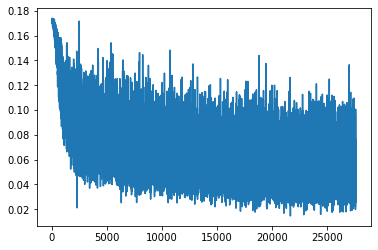

------
*********
29817 3074
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.16911372542381287
Loss:  0.17005234956741333
Loss:  0.1557096391916275
0 **********
Epoch:  57.04547119140625  fold:  8  kers:  64
epoch:  1
29817 466
Loss:  0.1302487850189209
Loss:  0.122116319835186
Loss:  0.11512050032615662
1 **********
Epoch:  101.53152465820312  fold:  8  kers:  64
epoch:  2
29817 466
Loss:  0.12102889269590378
Loss:  0.11309485137462616
Loss:  0.09848809987306595
2 **********
Epoch:  145.8769543170929  fold:  8  kers:  64
epoch:  3
Eval Loss:  0.27534228563308716
Eval Loss:  0.8643774390220642
Eval Loss:  0.2726857364177704
[[1831  242]
 [ 362  639]]
              precision    rec

Loss:  0.0760444924235344
Loss:  0.070900559425354
Loss:  0.09660707414150238
11 **********
Epoch:  667.0202486515045  fold:  8  kers:  64
epoch:  12
Eval Loss:  0.17324818670749664
Eval Loss:  1.8718178272247314
Eval Loss:  0.08983691036701202
[[1957  116]
 [ 629  372]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      2073
           1       0.76      0.37      0.50      1001

    accuracy                           0.76      3074
   macro avg       0.76      0.66      0.67      3074
weighted avg       0.76      0.76      0.73      3074

acc:  0.7576447625243982
pre:  0.7622950819672131
rec:  0.37162837162837165
ma F1:  0.6698793225155036
mi F1:  0.7576447625243982
we F1:  0.7292386611208884
Eval Loss:  0.31932133436203003
Eval Loss:  0.346249520778656
Eval Loss:  0.42072877287864685
Eval Loss:  0.4259393811225891
Eval Loss:  0.43069154024124146
Eval Loss:  0.4779238700866699
Eval Loss:  0.5257004499435425
Eval Loss:  0.41869953274

Eval Loss:  0.22364845871925354
Eval Loss:  0.2847341001033783
Eval Loss:  0.28426891565322876
Eval Loss:  0.30103206634521484
Eval Loss:  0.261675626039505
Eval Loss:  0.3119480311870575
Eval Loss:  0.38631895184516907
Eval Loss:  0.27049413323402405
Eval Loss:  0.28736910223960876
Eval Loss:  0.23791910707950592
Eval Loss:  0.19429254531860352
Eval Loss:  0.22003436088562012
Eval Loss:  0.3155369162559509
Eval Loss:  0.21207791566848755
Eval Loss:  0.302561491727829
Eval Loss:  0.2663593590259552
Eval Loss:  0.24939027428627014
Eval Loss:  0.2994096875190735
Eval Loss:  0.21215848624706268
Eval Loss:  0.24697330594062805
Eval Loss:  0.4093221426010132
Eval Loss:  0.33760058879852295
Eval Loss:  0.25438788533210754
Eval Loss:  0.2666023373603821
Eval Loss:  0.3839925527572632
Eval Loss:  0.3007858693599701
Eval Loss:  0.3144912123680115
Eval Loss:  0.28068944811820984
Eval Loss:  0.23448792099952698
[[17443   648]
 [ 2689  9037]]
              precision    recall  f1-score   support



Eval Loss:  0.22637256979942322
Eval Loss:  0.3690928518772125
Eval Loss:  0.289098858833313
Eval Loss:  0.21823422610759735
Eval Loss:  0.26083850860595703
Eval Loss:  0.3299342393875122
Eval Loss:  0.234502375125885
Eval Loss:  0.27704817056655884
Eval Loss:  0.2615375518798828
Eval Loss:  0.19848507642745972
[[17261   830]
 [ 2033  9693]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     18091
           1       0.92      0.83      0.87     11726

    accuracy                           0.90     29817
   macro avg       0.91      0.89      0.90     29817
weighted avg       0.91      0.90      0.90     29817

acc:  0.9039809504645001
pre:  0.9211251544236434
rec:  0.8266245949172778
ma F1:  0.897369271338723
mi F1:  0.9039809504645001
we F1:  0.902929966058011
29817 466
Loss:  0.07673262059688568
Loss:  0.04527795687317848
Loss:  0.044990237802267075
30 **********
Epoch:  1784.0639388561249  fold:  8  kers:  64
epoch:  31
29817 466


Loss:  0.05813371762633324
Loss:  0.06819701939821243
Loss:  0.0658591017127037
39 **********
Epoch:  2288.1371495723724  fold:  8  kers:  64
epoch:  40
29817 466
Loss:  0.035736121237277985
Loss:  0.08807644993066788
Loss:  0.04224063828587532
40 **********
Epoch:  2330.8778698444366  fold:  8  kers:  64
epoch:  41
29817 466
Loss:  0.07166460156440735
Loss:  0.0716838389635086
Loss:  0.042143747210502625
41 **********
Epoch:  2373.6594808101654  fold:  8  kers:  64
epoch:  42
Eval Loss:  0.590151846408844
Eval Loss:  1.0874782800674438
Eval Loss:  0.09803299605846405
[[1861  212]
 [ 228  773]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2073
           1       0.78      0.77      0.78      1001

    accuracy                           0.86      3074
   macro avg       0.84      0.83      0.84      3074
weighted avg       0.86      0.86      0.86      3074

acc:  0.8568640208197787
pre:  0.7847715736040609
rec:  0.7722277722277

Eval Loss:  0.17953930795192719
Eval Loss:  0.19647245109081268
Eval Loss:  0.19390209019184113
Eval Loss:  0.2338121086359024
Eval Loss:  0.14505380392074585
Eval Loss:  0.24156956374645233
Eval Loss:  0.3019551932811737
Eval Loss:  0.1742546260356903
Eval Loss:  0.23259033262729645
Eval Loss:  0.1528976708650589
Eval Loss:  0.14021487534046173
Eval Loss:  0.19146043062210083
Eval Loss:  0.25586915016174316
Eval Loss:  0.17792262136936188
Eval Loss:  0.21779537200927734
Eval Loss:  0.19218701124191284
Eval Loss:  0.18355317413806915
Eval Loss:  0.25768351554870605
Eval Loss:  0.2084498107433319
Eval Loss:  0.18375547230243683
Eval Loss:  0.2560573220252991
Eval Loss:  0.2594585120677948
Eval Loss:  0.15875472128391266
Eval Loss:  0.23714226484298706
Eval Loss:  0.23398657143115997
Eval Loss:  0.2177732139825821
Eval Loss:  0.2337655872106552
Eval Loss:  0.22418707609176636
Eval Loss:  0.19435207545757294
[[17101   990]
 [ 1374 10352]]
              precision    recall  f1-score   supp

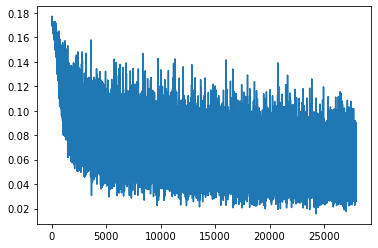

------
*********
29483 3408
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.16792096197605133
Loss:  0.15348957479000092
Loss:  0.15342146158218384
0 **********
Epoch:  55.081340312957764  fold:  9  kers:  64
epoch:  1
29483 461
Loss:  0.13399724662303925
Loss:  0.12158320099115372
Loss:  0.12857994437217712
1 **********
Epoch:  97.59966111183167  fold:  9  kers:  64
epoch:  2
29483 461
Loss:  0.12717671692371368
Loss:  0.12849728763103485
Loss:  0.09826672822237015
2 **********
Epoch:  139.90582394599915  fold:  9  kers:  64
epoch:  3
Eval Loss:  0.20430967211723328
Eval Loss:  0.881584644317627
Eval Loss:  0.36363232135772705
[[1497  245]
 [ 376 1290]]
              precision  

Loss:  0.07622473686933517
Loss:  0.09344494342803955
11 **********
Epoch:  640.7666244506836  fold:  9  kers:  64
epoch:  12
Eval Loss:  0.038476377725601196
Eval Loss:  1.9052586555480957
Eval Loss:  0.2825358808040619
[[1677   65]
 [ 639 1027]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.83      1742
           1       0.94      0.62      0.74      1666

    accuracy                           0.79      3408
   macro avg       0.83      0.79      0.79      3408
weighted avg       0.83      0.79      0.79      3408

acc:  0.7934272300469484
pre:  0.9404761904761905
rec:  0.6164465786314526
ma F1:  0.7856290459833501
mi F1:  0.7934272300469484
we F1:  0.7865408336584785
Eval Loss:  0.3480004370212555
Eval Loss:  0.3285049796104431
Eval Loss:  0.32981377840042114
Eval Loss:  0.30605947971343994
Eval Loss:  0.31381678581237793
Eval Loss:  0.20951279997825623
Eval Loss:  0.3403733968734741
Eval Loss:  0.38897377252578735
Eval Loss:  0.28

Eval Loss:  0.28015750646591187
Eval Loss:  0.2859055995941162
Eval Loss:  0.26459434628486633
Eval Loss:  0.23730072379112244
Eval Loss:  0.1918538212776184
Eval Loss:  0.30711817741394043
Eval Loss:  0.34454411268234253
Eval Loss:  0.26623719930648804
Eval Loss:  0.2719302475452423
Eval Loss:  0.2541506886482239
Eval Loss:  0.3007906973361969
Eval Loss:  0.22463679313659668
Eval Loss:  0.22203028202056885
Eval Loss:  0.34401825070381165
Eval Loss:  0.2373894304037094
Eval Loss:  0.2522040903568268
Eval Loss:  0.2823171317577362
Eval Loss:  0.2983989119529724
Eval Loss:  0.2705555260181427
Eval Loss:  0.3375576138496399
Eval Loss:  0.17578043043613434
Eval Loss:  0.2142634391784668
Eval Loss:  0.24421989917755127
Eval Loss:  0.24968332052230835
Eval Loss:  0.29147079586982727
Eval Loss:  0.218969464302063
Eval Loss:  0.2099153697490692
[[17493   929]
 [ 2065  8996]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     18422
           

Eval Loss:  0.2760140299797058
Eval Loss:  0.2130025178194046
Eval Loss:  0.19273293018341064
[[17733   689]
 [ 2116  8945]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     18422
           1       0.93      0.81      0.86     11061

    accuracy                           0.90     29483
   macro avg       0.91      0.89      0.90     29483
weighted avg       0.91      0.90      0.90     29483

acc:  0.9048604280432792
pre:  0.9284824579613867
rec:  0.8086972244824157
ma F1:  0.8955834602543202
mi F1:  0.9048604280432792
we F1:  0.9033540291999879
29483 461
Loss:  0.062272150069475174
Loss:  0.05181843787431717
Loss:  0.07120970636606216
30 **********
Epoch:  1728.3980660438538  fold:  9  kers:  64
epoch:  31
29483 461
Loss:  0.109364353120327
Loss:  0.09562010318040848
Loss:  0.06043791398406029
31 **********
Epoch:  1770.812658071518  fold:  9  kers:  64
epoch:  32
29483 461
Loss:  0.07365070283412933
Loss:  0.06670736521482468
Lo

Loss:  0.052869297564029694
Loss:  0.04888242483139038
Loss:  0.03256550431251526
40 **********
Epoch:  2271.7760581970215  fold:  9  kers:  64
epoch:  41
29483 461
Loss:  0.060513801872730255
Loss:  0.04667713865637779
Loss:  0.07620388269424438
41 **********
Epoch:  2314.1906502246857  fold:  9  kers:  64
epoch:  42
Eval Loss:  0.03232462704181671
Eval Loss:  1.3161444664001465
Eval Loss:  0.26954469084739685
[[1655   87]
 [ 693  973]]
              precision    recall  f1-score   support

           0       0.70      0.95      0.81      1742
           1       0.92      0.58      0.71      1666

    accuracy                           0.77      3408
   macro avg       0.81      0.77      0.76      3408
weighted avg       0.81      0.77      0.76      3408

acc:  0.7711267605633803
pre:  0.9179245283018868
rec:  0.5840336134453782
ma F1:  0.7615787122825208
mi F1:  0.7711267605633803
we F1:  0.7626427176627926
Eval Loss:  0.29838648438453674
Eval Loss:  0.2512942850589752
Eval Loss:  

Eval Loss:  0.2801763117313385
Eval Loss:  0.258817195892334
Eval Loss:  0.2752237319946289
Eval Loss:  0.19850222766399384
Eval Loss:  0.23311257362365723
Eval Loss:  0.12571047246456146
Eval Loss:  0.21590128540992737
Eval Loss:  0.23508615791797638
Eval Loss:  0.24220597743988037
Eval Loss:  0.22390329837799072
Eval Loss:  0.22523736953735352
Eval Loss:  0.27258485555648804
Eval Loss:  0.16966357827186584
Eval Loss:  0.16661140322685242
Eval Loss:  0.26003098487854004
Eval Loss:  0.2284291833639145
Eval Loss:  0.22793011367321014
Eval Loss:  0.21097028255462646
Eval Loss:  0.19457222521305084
Eval Loss:  0.22392715513706207
Eval Loss:  0.27650314569473267
Eval Loss:  0.1549546718597412
Eval Loss:  0.13528072834014893
Eval Loss:  0.18429552018642426
Eval Loss:  0.19080789387226105
Eval Loss:  0.28091323375701904
Eval Loss:  0.2196129411458969
Eval Loss:  0.18256887793540955
[[16731  1691]
 [  794 10267]]
              precision    recall  f1-score   support

           0       0.95  

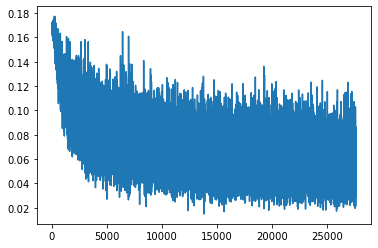

------
*********
29871 3020
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.16776318848133087
Loss:  0.16900795698165894
Loss:  0.16073457896709442
0 **********
Epoch:  55.53152012825012  fold:  10  kers:  64
epoch:  1
29871 467
Loss:  0.12961120903491974
Loss:  0.15182767808437347
Loss:  0.1340007781982422
1 **********
Epoch:  98.80381917953491  fold:  10  kers:  64
epoch:  2
29871 467
Loss:  0.10332539677619934
Loss:  0.1042264997959137
Loss:  0.12156767398118973
2 **********
Epoch:  142.1040427684784  fold:  10  kers:  64
epoch:  3
Eval Loss:  0.5702024698257446
Eval Loss:  0.26620155572891235
Eval Loss:  0.1123906597495079
[[1533  218]
 [ 202 1067]]
              precision   

Loss:  0.11070123314857483
10 **********
Epoch:  606.3830902576447  fold:  10  kers:  64
epoch:  11
29871 467
Loss:  0.07760748267173767
Loss:  0.07719200849533081
Loss:  0.08042396605014801
11 **********
Epoch:  649.4489405155182  fold:  10  kers:  64
epoch:  12
Eval Loss:  0.7310223579406738
Eval Loss:  0.09743665903806686
Eval Loss:  0.06172218918800354
[[1705   46]
 [ 362  907]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1751
           1       0.95      0.71      0.82      1269

    accuracy                           0.86      3020
   macro avg       0.89      0.84      0.85      3020
weighted avg       0.88      0.86      0.86      3020

acc:  0.8649006622516556
pre:  0.9517313746065058
rec:  0.7147360126083531
ma F1:  0.8547597033144907
mi F1:  0.8649006622516556
we F1:  0.8608849441762871
Eval Loss:  0.39551010727882385
Eval Loss:  0.35135263204574585
Eval Loss:  0.44048288464546204
Eval Loss:  0.3035067617893219
Eval

Eval Loss:  0.2528230547904968
Eval Loss:  0.22303752601146698
Eval Loss:  0.27421167492866516
Eval Loss:  0.2027658373117447
Eval Loss:  0.3103684186935425
Eval Loss:  0.20592546463012695
Eval Loss:  0.2554878890514374
Eval Loss:  0.24611885845661163
Eval Loss:  0.2920393645763397
Eval Loss:  0.28109386563301086
Eval Loss:  0.2117430567741394
Eval Loss:  0.36831966042518616
Eval Loss:  0.17818103730678558
Eval Loss:  0.23255975544452667
Eval Loss:  0.3434772491455078
Eval Loss:  0.33699220418930054
Eval Loss:  0.2737869620323181
Eval Loss:  0.3613404631614685
Eval Loss:  0.23540404438972473
Eval Loss:  0.23473477363586426
Eval Loss:  0.19363875687122345
Eval Loss:  0.2562406063079834
Eval Loss:  0.24921287596225739
Eval Loss:  0.305707722902298
Eval Loss:  0.22189204394817352
Eval Loss:  0.22874712944030762
Eval Loss:  0.2418992519378662
Eval Loss:  0.2927035689353943
Eval Loss:  0.25892892479896545
[[17520   893]
 [ 2342  9116]]
              precision    recall  f1-score   support



Eval Loss:  0.224660724401474
Eval Loss:  0.20923180878162384
Eval Loss:  0.272315114736557
Eval Loss:  0.24962420761585236
Eval Loss:  0.3128686249256134
Eval Loss:  0.23247231543064117
Eval Loss:  0.22706200182437897
Eval Loss:  0.2458311915397644
Eval Loss:  0.2908652722835541
Eval Loss:  0.2674475610256195
[[17620   793]
 [ 2293  9165]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     18413
           1       0.92      0.80      0.86     11458

    accuracy                           0.90     29871
   macro avg       0.90      0.88      0.89     29871
weighted avg       0.90      0.90      0.90     29871

acc:  0.8966890964480599
pre:  0.9203655352480418
rec:  0.7998778146273346
ma F1:  0.8876911888222523
mi F1:  0.8966890964480599
we F1:  0.895092779305693
29871 467
Loss:  0.07017200440168381
Loss:  0.08407227694988251
Loss:  0.06448041647672653
30 **********
Epoch:  1743.2061419487  fold:  10  kers:  64
epoch:  31
29871 467
Los

Loss:  0.06893227249383926
Loss:  0.05605100095272064
Loss:  0.048691023141145706
39 **********
Epoch:  2254.125026702881  fold:  10  kers:  64
epoch:  40
29871 467
Loss:  0.08230071514844894
Loss:  0.05877736210823059
Loss:  0.03856464475393295
40 **********
Epoch:  2297.3045732975006  fold:  10  kers:  64
epoch:  41
29871 467
Loss:  0.03673318773508072
Loss:  0.06747226417064667
Loss:  0.08304627984762192
41 **********
Epoch:  2340.4172728061676  fold:  10  kers:  64
epoch:  42
Eval Loss:  0.13939805328845978
Eval Loss:  0.24417538940906525
Eval Loss:  0.014856982044875622
[[1681   70]
 [ 121 1148]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1751
           1       0.94      0.90      0.92      1269

    accuracy                           0.94      3020
   macro avg       0.94      0.93      0.93      3020
weighted avg       0.94      0.94      0.94      3020

acc:  0.9367549668874172
pre:  0.9425287356321839
rec:  0.904649

Eval Loss:  0.20426343381404877
Eval Loss:  0.2056242674589157
Eval Loss:  0.2457641065120697
Eval Loss:  0.15749140083789825
Eval Loss:  0.27092933654785156
Eval Loss:  0.2399452030658722
Eval Loss:  0.22655953466892242
Eval Loss:  0.20583337545394897
Eval Loss:  0.20309364795684814
Eval Loss:  0.2609233260154724
Eval Loss:  0.15986955165863037
Eval Loss:  0.3109709918498993
Eval Loss:  0.13220186531543732
Eval Loss:  0.19055171310901642
Eval Loss:  0.2883014976978302
Eval Loss:  0.2791942358016968
Eval Loss:  0.2681663930416107
Eval Loss:  0.29429906606674194
Eval Loss:  0.24383243918418884
Eval Loss:  0.1384662687778473
Eval Loss:  0.18946564197540283
Eval Loss:  0.26791203022003174
Eval Loss:  0.23563914000988007
Eval Loss:  0.25017693638801575
Eval Loss:  0.1663457155227661
Eval Loss:  0.2121080458164215
Eval Loss:  0.20347999036312103
Eval Loss:  0.2453978806734085
Eval Loss:  0.2215149700641632
[[17586   827]
 [ 1841  9617]]
              precision    recall  f1-score   support


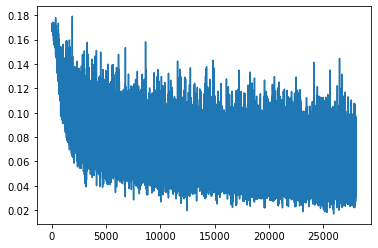

------
  
kernel: 32
  
*********
29459 3432
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.16905121505260468
Loss:  0.16023720800876617
Loss:  0.15403352677822113
0 **********
Epoch:  52.03786063194275  fold:  1  kers:  32
epoch:  1
29459 461
Loss:  0.1476772427558899
Loss:  0.11922048032283783
Loss:  0.16323991119861603
1 **********
Epoch:  91.77760481834412  fold:  1  kers:  32
epoch:  2
29459 461
Loss:  0.0996454581618309
Loss:  0.1056632474064827
Loss:  0.11052271723747253
2 **********
Epoch:  131.4783899784088  fold:  1  kers:  32
epoch:  3
Eval Loss:  0.3752261698246002
Eval Loss:  0.5860748291015625
Eval Loss:  0.2623479962348938
[[ 841  198]
 [ 754 1639]]
              

Loss:  0.07223112136125565
Loss:  0.07467764616012573
Loss:  0.10059429705142975
11 **********
Epoch:  626.8050389289856  fold:  1  kers:  32
epoch:  12
Eval Loss:  0.6734354496002197
Eval Loss:  0.5892624258995056
Eval Loss:  0.14825062453746796
[[ 840  199]
 [ 479 1914]]
              precision    recall  f1-score   support

           0       0.64      0.81      0.71      1039
           1       0.91      0.80      0.85      2393

    accuracy                           0.80      3432
   macro avg       0.77      0.80      0.78      3432
weighted avg       0.82      0.80      0.81      3432

acc:  0.8024475524475524
pre:  0.9058211074301941
rec:  0.7998328458002507
ma F1:  0.7810010740556274
mi F1:  0.8024475524475524
we F1:  0.8080388131083897
update!  Acc:  0.8024475524475524
Eval Loss:  0.395538866519928
Eval Loss:  0.28683826327323914
Eval Loss:  0.2529892325401306
Eval Loss:  0.40555840730667114
Eval Loss:  0.2647058665752411
Eval Loss:  0.379855215549469
Eval Loss:  0.306991010

Eval Loss:  0.40838614106178284
Eval Loss:  0.33850938081741333
Eval Loss:  0.2828342616558075
Eval Loss:  0.36112433671951294
Eval Loss:  0.34932947158813477
Eval Loss:  0.4135601222515106
Eval Loss:  0.32022982835769653
Eval Loss:  0.3109372556209564
Eval Loss:  0.3345527648925781
Eval Loss:  0.3897168040275574
Eval Loss:  0.286663293838501
Eval Loss:  0.3527791500091553
Eval Loss:  0.4280363917350769
Eval Loss:  0.37086424231529236
Eval Loss:  0.18696507811546326
Eval Loss:  0.4517827033996582
Eval Loss:  0.34405893087387085
Eval Loss:  0.41181862354278564
Eval Loss:  0.46128934621810913
Eval Loss:  0.37478744983673096
Eval Loss:  0.37578558921813965
Eval Loss:  0.3886120319366455
Eval Loss:  0.30345749855041504
Eval Loss:  0.31762439012527466
Eval Loss:  0.36165788769721985
Eval Loss:  0.39526280760765076
Eval Loss:  0.2903172969818115
Eval Loss:  0.374378502368927
[[18617   508]
 [ 3776  6558]]
              precision    recall  f1-score   support

           0       0.83      0.9

Eval Loss:  0.23890666663646698
Eval Loss:  0.22962749004364014
Eval Loss:  0.24510259926319122
Eval Loss:  0.35582536458969116
Eval Loss:  0.23792248964309692
Eval Loss:  0.2736618220806122
[[18097  1028]
 [ 2338  7996]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.91     19125
           1       0.89      0.77      0.83     10334

    accuracy                           0.89     29459
   macro avg       0.89      0.86      0.87     29459
weighted avg       0.89      0.89      0.88     29459

acc:  0.8857395023592111
pre:  0.8860815602836879
rec:  0.7737565318366557
ma F1:  0.8705162276309161
mi F1:  0.8857395023592112
we F1:  0.8837651938853901
29459 461
Loss:  0.05865882709622383
Loss:  0.06813722103834152
Loss:  0.09212396293878555
30 **********
Epoch:  1665.1138665676117  fold:  1  kers:  32
epoch:  31
29459 461
Loss:  0.06538484245538712
Loss:  0.09393419325351715
Loss:  0.09283647686243057
31 **********
Epoch:  1704.5773496627808

Loss:  0.05915338546037674
Loss:  0.06453579664230347
Loss:  0.08740328252315521
39 **********
Epoch:  2136.377802848816  fold:  1  kers:  32
epoch:  40
29459 461
Loss:  0.08099815249443054
Loss:  0.09387007355690002
Loss:  0.07542243599891663
40 **********
Epoch:  2175.8313121795654  fold:  1  kers:  32
epoch:  41
29459 461
Loss:  0.06705798208713531
Loss:  0.09361652284860611
Loss:  0.04430137574672699
41 **********
Epoch:  2215.3636107444763  fold:  1  kers:  32
epoch:  42
Eval Loss:  1.2472889423370361
Eval Loss:  0.4849618375301361
Eval Loss:  0.09149271249771118
[[ 836  203]
 [ 452 1941]]
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      1039
           1       0.91      0.81      0.86      2393

    accuracy                           0.81      3432
   macro avg       0.78      0.81      0.79      3432
weighted avg       0.83      0.81      0.81      3432

acc:  0.8091491841491841
pre:  0.9053171641791045
rec:  0.8111157542833

Eval Loss:  0.27749377489089966
Eval Loss:  0.2684538662433624
Eval Loss:  0.22361093759536743
Eval Loss:  0.2663585841655731
Eval Loss:  0.19265981018543243
Eval Loss:  0.30672457814216614
Eval Loss:  0.24780188500881195
Eval Loss:  0.20648972690105438
Eval Loss:  0.19194699823856354
Eval Loss:  0.2604232728481293
Eval Loss:  0.20687395334243774
Eval Loss:  0.2625592350959778
Eval Loss:  0.3143754005432129
Eval Loss:  0.253058522939682
Eval Loss:  0.13212813436985016
Eval Loss:  0.35503071546554565
Eval Loss:  0.2179740071296692
Eval Loss:  0.27753257751464844
Eval Loss:  0.3156399130821228
Eval Loss:  0.19908641278743744
Eval Loss:  0.25587642192840576
Eval Loss:  0.28321754932403564
Eval Loss:  0.25174760818481445
Eval Loss:  0.2139127254486084
Eval Loss:  0.2294805645942688
Eval Loss:  0.31982967257499695
Eval Loss:  0.23202940821647644
Eval Loss:  0.24383831024169922
[[18024  1101]
 [ 1862  8472]]
              precision    recall  f1-score   support

           0       0.91      

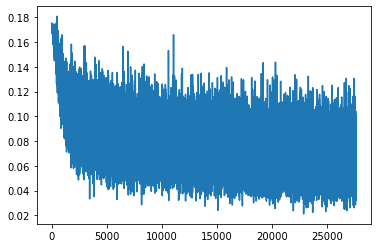

------
*********
29797 3094
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.1672477126121521
Loss:  0.16493839025497437
Loss:  0.15999853610992432
0 **********
Epoch:  52.59537076950073  fold:  2  kers:  32
epoch:  1
29797 466
Loss:  0.13577903807163239
Loss:  0.14645549654960632
Loss:  0.11564867198467255
1 **********
Epoch:  92.64528465270996  fold:  2  kers:  32
epoch:  2
29797 466
Loss:  0.10835767537355423
Loss:  0.09904933720827103
Loss:  0.09812802076339722
2 **********
Epoch:  132.66926908493042  fold:  2  kers:  32
epoch:  3
Eval Loss:  0.9498158693313599
Eval Loss:  0.1696321964263916
Eval Loss:  0.6065100431442261
[[1180  250]
 [ 647 1017]]
              precision    r

Loss:  0.0750994086265564
10 **********
Epoch:  568.7024049758911  fold:  2  kers:  32
epoch:  11
29797 466
Loss:  0.06765063107013702
Loss:  0.08398441225290298
Loss:  0.08959276974201202
11 **********
Epoch:  608.6057114601135  fold:  2  kers:  32
epoch:  12
Eval Loss:  0.818426251411438
Eval Loss:  0.17735761404037476
Eval Loss:  0.8368601202964783
[[1319  111]
 [ 793  871]]
              precision    recall  f1-score   support

           0       0.62      0.92      0.74      1430
           1       0.89      0.52      0.66      1664

    accuracy                           0.71      3094
   macro avg       0.76      0.72      0.70      3094
weighted avg       0.77      0.71      0.70      3094

acc:  0.7078215901745314
pre:  0.8869653767820774
rec:  0.5234375
ma F1:  0.7015645959745338
mi F1:  0.7078215901745314
we F1:  0.6982964338254278
Eval Loss:  0.3449804484844208
Eval Loss:  0.3979390561580658
Eval Loss:  0.26743224263191223
Eval Loss:  0.23906366527080536
Eval Loss:  0.34722

Eval Loss:  0.3142419457435608
Eval Loss:  0.3639634847640991
Eval Loss:  0.2606004774570465
Eval Loss:  0.2064504325389862
Eval Loss:  0.30991873145103455
Eval Loss:  0.27011245489120483
Eval Loss:  0.38752442598342896
Eval Loss:  0.29574453830718994
Eval Loss:  0.2683022618293762
Eval Loss:  0.16620662808418274
Eval Loss:  0.18771789968013763
Eval Loss:  0.22758837044239044
Eval Loss:  0.32727178931236267
Eval Loss:  0.37727969884872437
Eval Loss:  0.2652219533920288
Eval Loss:  0.3128533959388733
Eval Loss:  0.22758722305297852
Eval Loss:  0.2738991677761078
Eval Loss:  0.26467758417129517
Eval Loss:  0.21825405955314636
Eval Loss:  0.22709017992019653
Eval Loss:  0.25748175382614136
Eval Loss:  0.40087199211120605
Eval Loss:  0.24064795672893524
Eval Loss:  0.27684828639030457
Eval Loss:  0.27603453397750854
Eval Loss:  0.26441988348960876
Eval Loss:  0.2605656087398529
Eval Loss:  0.3959597647190094
[[17848   886]
 [ 2537  8526]]
              precision    recall  f1-score   suppo

Eval Loss:  0.18837694823741913
Eval Loss:  0.18976432085037231
Eval Loss:  0.24422195553779602
Eval Loss:  0.3579854667186737
Eval Loss:  0.19256484508514404
Eval Loss:  0.24903160333633423
Eval Loss:  0.2079666554927826
Eval Loss:  0.22414517402648926
Eval Loss:  0.21124491095542908
Eval Loss:  0.2935003340244293
[[17526  1208]
 [ 1745  9318]]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     18734
           1       0.89      0.84      0.86     11063

    accuracy                           0.90     29797
   macro avg       0.90      0.89      0.89     29797
weighted avg       0.90      0.90      0.90     29797

acc:  0.9008960633620834
pre:  0.8852365570967129
rec:  0.8422670161800596
ma F1:  0.8927585383145676
mi F1:  0.9008960633620833
we F1:  0.9003636741137262
29797 466
Loss:  0.09975837916135788
Loss:  0.065535768866539
Loss:  0.06498269736766815
30 **********
Epoch:  1636.589093208313  fold:  2  kers:  32
epoch:  31
29797 46

Loss:  0.05759352818131447
Loss:  0.08191176503896713
Loss:  0.08800855278968811
39 **********
Epoch:  2111.2718873023987  fold:  2  kers:  32
epoch:  40
29797 466
Loss:  0.045314397662878036
Loss:  0.10341235250234604
Loss:  0.08703925460577011
40 **********
Epoch:  2151.206111907959  fold:  2  kers:  32
epoch:  41
29797 466
Loss:  0.06426307559013367
Loss:  0.08176031708717346
Loss:  0.06592239439487457
41 **********
Epoch:  2191.09645318985  fold:  2  kers:  32
epoch:  42
Eval Loss:  0.35765838623046875
Eval Loss:  0.5228518843650818
Eval Loss:  0.5855181813240051
[[1207  223]
 [ 483 1181]]
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      1430
           1       0.84      0.71      0.77      1664

    accuracy                           0.77      3094
   macro avg       0.78      0.78      0.77      3094
weighted avg       0.78      0.77      0.77      3094

acc:  0.7718164188752424
pre:  0.8411680911680912
rec:  0.70973557692307

Eval Loss:  0.2852489948272705
Eval Loss:  0.2555358409881592
Eval Loss:  0.194553405046463
Eval Loss:  0.18658174574375153
Eval Loss:  0.24815396964550018
Eval Loss:  0.180317223072052
Eval Loss:  0.2831169366836548
Eval Loss:  0.21784508228302002
Eval Loss:  0.1848623901605606
Eval Loss:  0.15364272892475128
Eval Loss:  0.14804449677467346
Eval Loss:  0.2012699395418167
Eval Loss:  0.28630632162094116
Eval Loss:  0.27860787510871887
Eval Loss:  0.23572103679180145
Eval Loss:  0.2594199478626251
Eval Loss:  0.16146308183670044
Eval Loss:  0.19149939715862274
Eval Loss:  0.20210076868534088
Eval Loss:  0.154274120926857
Eval Loss:  0.1738673746585846
Eval Loss:  0.24254286289215088
Eval Loss:  0.3359665274620056
Eval Loss:  0.2050899863243103
Eval Loss:  0.18259453773498535
Eval Loss:  0.19353747367858887
Eval Loss:  0.1906016319990158
Eval Loss:  0.18661808967590332
Eval Loss:  0.27010518312454224
[[17724  1010]
 [ 1634  9429]]
              precision    recall  f1-score   support

  

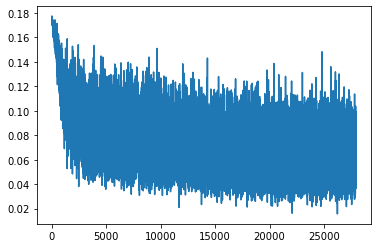

------
*********
29460 3431
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.17039696872234344
Loss:  0.16804258525371552
Loss:  0.16441810131072998
0 **********
Epoch:  51.99896478652954  fold:  3  kers:  32
epoch:  1
29460 461
Loss:  0.1446966975927353
Loss:  0.13954763114452362
Loss:  0.11688563227653503
1 **********
Epoch:  91.60207486152649  fold:  3  kers:  32
epoch:  2
29460 461
Loss:  0.11653286963701248
Loss:  0.11765041947364807
Loss:  0.09601900726556778
2 **********
Epoch:  131.0366349220276  fold:  3  kers:  32
epoch:  3
Eval Loss:  0.7299755215644836
Eval Loss:  0.6134582161903381
Eval Loss:  0.3783038556575775
[[1226  310]
 [ 435 1460]]
              precision    re

Loss:  0.12167184799909592
11 **********
Epoch:  603.085471868515  fold:  3  kers:  32
epoch:  12
Eval Loss:  0.7543255090713501
Eval Loss:  0.25799819827079773
Eval Loss:  0.5671979188919067
[[1318  218]
 [ 551 1344]]
              precision    recall  f1-score   support

           0       0.71      0.86      0.77      1536
           1       0.86      0.71      0.78      1895

    accuracy                           0.78      3431
   macro avg       0.78      0.78      0.78      3431
weighted avg       0.79      0.78      0.78      3431

acc:  0.7758670941416497
pre:  0.8604353393085787
rec:  0.7092348284960422
ma F1:  0.7758542224442352
mi F1:  0.7758670941416497
we F1:  0.7760319508816121
Eval Loss:  0.261760950088501
Eval Loss:  0.2758231461048126
Eval Loss:  0.305097758769989
Eval Loss:  0.3165473937988281
Eval Loss:  0.3352965712547302
Eval Loss:  0.33586037158966064
Eval Loss:  0.17833445966243744
Eval Loss:  0.3803712725639343
Eval Loss:  0.273124635219574
Eval Loss:  0.418236

Eval Loss:  0.2850475609302521
Eval Loss:  0.27049508690834045
Eval Loss:  0.30367228388786316
Eval Loss:  0.2764914333820343
Eval Loss:  0.17152856290340424
Eval Loss:  0.3332083523273468
Eval Loss:  0.1993357241153717
Eval Loss:  0.30883872509002686
Eval Loss:  0.23772136867046356
Eval Loss:  0.2229221910238266
Eval Loss:  0.2342519462108612
Eval Loss:  0.2580937445163727
Eval Loss:  0.27007076144218445
Eval Loss:  0.21729737520217896
Eval Loss:  0.29312968254089355
Eval Loss:  0.24268920719623566
Eval Loss:  0.3343413770198822
Eval Loss:  0.30681291222572327
Eval Loss:  0.2164311707019806
Eval Loss:  0.25535935163497925
Eval Loss:  0.2722706198692322
Eval Loss:  0.23538623750209808
Eval Loss:  0.25159338116645813
Eval Loss:  0.1685238778591156
Eval Loss:  0.26302260160446167
Eval Loss:  0.39474940299987793
[[17003  1625]
 [ 1522  9310]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     18628
           1       0.85      0.86      

Eval Loss:  0.1564932018518448
Eval Loss:  0.30090567469596863
Eval Loss:  0.38538867235183716
[[17874   754]
 [ 2317  8515]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     18628
           1       0.92      0.79      0.85     10832

    accuracy                           0.90     29460
   macro avg       0.90      0.87      0.88     29460
weighted avg       0.90      0.90      0.89     29460

acc:  0.8957569585879158
pre:  0.9186535764375876
rec:  0.7860967503692762
ma F1:  0.8840553932643499
mi F1:  0.8957569585879158
we F1:  0.8938027384147421
29460 461
Loss:  0.055291078984737396
Loss:  0.04352204501628876
Loss:  0.07019388675689697
30 **********
Epoch:  1625.015040397644  fold:  3  kers:  32
epoch:  31
29460 461
Loss:  0.04718278348445892
Loss:  0.05988747626543045
Loss:  0.05886327102780342
31 **********
Epoch:  1664.3977391719818  fold:  3  kers:  32
epoch:  32
29460 461
Loss:  0.09110234677791595
Loss:  0.06598089635372162

Loss:  0.053155411034822464
Loss:  0.043701764196157455
Loss:  0.0820370763540268
40 **********
Epoch:  2139.6190938949585  fold:  3  kers:  32
epoch:  41
29460 461
Loss:  0.06053447350859642
Loss:  0.04872416332364082
Loss:  0.05459003150463104
41 **********
Epoch:  2181.952901363373  fold:  3  kers:  32
epoch:  42
Eval Loss:  0.5070400834083557
Eval Loss:  0.15008151531219482
Eval Loss:  1.0261870622634888
[[1294  242]
 [ 560 1335]]
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      1536
           1       0.85      0.70      0.77      1895

    accuracy                           0.77      3431
   macro avg       0.77      0.77      0.77      3431
weighted avg       0.78      0.77      0.77      3431

acc:  0.7662489070241912
pre:  0.8465440710209258
rec:  0.7044854881266491
ma F1:  0.7662155227492082
mi F1:  0.7662489070241914
we F1:  0.7665078387179621
Eval Loss:  0.1934324949979782
Eval Loss:  0.16506926715373993
Eval Loss:  0.2

Eval Loss:  0.18168610334396362
Eval Loss:  0.14822229743003845
Eval Loss:  0.26362550258636475
Eval Loss:  0.20970216393470764
Eval Loss:  0.2890499234199524
Eval Loss:  0.19293494522571564
Eval Loss:  0.1372591108083725
Eval Loss:  0.3127385377883911
Eval Loss:  0.12809598445892334
Eval Loss:  0.20373426377773285
Eval Loss:  0.21432015299797058
Eval Loss:  0.17353394627571106
Eval Loss:  0.1999383121728897
Eval Loss:  0.21186292171478271
Eval Loss:  0.1624782830476761
Eval Loss:  0.21616654098033905
Eval Loss:  0.23462986946105957
Eval Loss:  0.1465379148721695
Eval Loss:  0.26549071073532104
Eval Loss:  0.24759571254253387
Eval Loss:  0.1985217034816742
Eval Loss:  0.21698233485221863
Eval Loss:  0.23427334427833557
Eval Loss:  0.23453205823898315
Eval Loss:  0.20643137395381927
Eval Loss:  0.1420568823814392
Eval Loss:  0.23690399527549744
Eval Loss:  0.3077504336833954
[[17663   965]
 [ 1551  9281]]
              precision    recall  f1-score   support

           0       0.92    

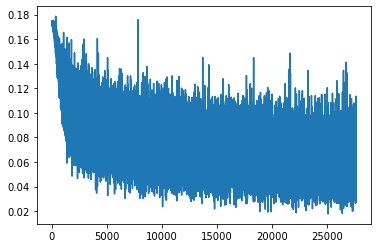

------
*********
29520 3371
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.1720971167087555
Loss:  0.17019689083099365
Loss:  0.16298234462738037
0 **********
Epoch:  52.13360595703125  fold:  4  kers:  32
epoch:  1
29520 462
Loss:  0.15267115831375122
Loss:  0.14776624739170074
Loss:  0.1402611881494522
1 **********
Epoch:  91.79256534576416  fold:  4  kers:  32
epoch:  2
29520 462
Loss:  0.12331906706094742
Loss:  0.14052338898181915
Loss:  0.10662020742893219
2 **********
Epoch:  131.42659258842468  fold:  4  kers:  32
epoch:  3
Eval Loss:  0.26893994212150574
Eval Loss:  0.3767274022102356
Eval Loss:  0.09401810169219971
[[2788  349]
 [ 164   70]]
              precision    

Loss:  0.1146848052740097
Loss:  0.10615004599094391
Loss:  0.07873478531837463
11 **********
Epoch:  604.8507521152496  fold:  4  kers:  32
epoch:  12
Eval Loss:  0.08572757989168167
Eval Loss:  0.1271970421075821
Eval Loss:  0.04590240865945816
[[3043   94]
 [ 200   34]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3137
           1       0.27      0.15      0.19       234

    accuracy                           0.91      3371
   macro avg       0.60      0.56      0.57      3371
weighted avg       0.89      0.91      0.90      3371

acc:  0.9127855235835064
pre:  0.265625
rec:  0.1452991452991453
ma F1:  0.5708818995826045
mi F1:  0.9127855235835064
we F1:  0.9007410622528
Eval Loss:  0.3289356827735901
Eval Loss:  0.37971895933151245
Eval Loss:  0.3176229000091553
Eval Loss:  0.3714480400085449
Eval Loss:  0.37288010120391846
Eval Loss:  0.2994799315929413
Eval Loss:  0.3185644745826721
Eval Loss:  0.32903003692626953
Eval 

Eval Loss:  0.32179969549179077
Eval Loss:  0.38129723072052
Eval Loss:  0.35900646448135376
Eval Loss:  0.37480854988098145
Eval Loss:  0.39729052782058716
Eval Loss:  0.31510844826698303
Eval Loss:  0.3327397406101227
Eval Loss:  0.3670545220375061
Eval Loss:  0.38319188356399536
Eval Loss:  0.28051507472991943
Eval Loss:  0.44903427362442017
Eval Loss:  0.374120831489563
Eval Loss:  0.3583630919456482
Eval Loss:  0.3056710660457611
Eval Loss:  0.3130699694156647
Eval Loss:  0.3422510325908661
Eval Loss:  0.29969120025634766
Eval Loss:  0.3762325942516327
Eval Loss:  0.30240774154663086
Eval Loss:  0.28742873668670654
Eval Loss:  0.42659318447113037
Eval Loss:  0.41386425495147705
Eval Loss:  0.39882707595825195
Eval Loss:  0.393785685300827
Eval Loss:  0.3935009837150574
Eval Loss:  0.34382084012031555
Eval Loss:  0.3543007969856262
Eval Loss:  0.38235509395599365
[[16368   659]
 [ 3748  8745]]
              precision    recall  f1-score   support

           0       0.81      0.96 

Eval Loss:  0.37339508533477783
Eval Loss:  0.29958969354629517
Eval Loss:  0.3213297724723816
Eval Loss:  0.29796940088272095
[[16083   944]
 [ 2837  9656]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     17027
           1       0.91      0.77      0.84     12493

    accuracy                           0.87     29520
   macro avg       0.88      0.86      0.87     29520
weighted avg       0.88      0.87      0.87     29520

acc:  0.8719173441734417
pre:  0.9109433962264151
rec:  0.7729128311854638
ma F1:  0.865544050703717
mi F1:  0.8719173441734417
we F1:  0.8700401628231712
29520 462
Loss:  0.09596004337072372
Loss:  0.05951796844601631
Loss:  0.08149358630180359
30 **********
Epoch:  1626.3793923854828  fold:  4  kers:  32
epoch:  31
29520 462
Loss:  0.06394180655479431
Loss:  0.08727667480707169
Loss:  0.06928202509880066
31 **********
Epoch:  1665.7531151771545  fold:  4  kers:  32
epoch:  32
29520 462
Loss:  0.0653005167841

39 **********
Epoch:  2097.7261068820953  fold:  4  kers:  32
epoch:  40
29520 462
Loss:  0.08352863788604736
Loss:  0.05514609441161156
Loss:  0.06624153256416321
40 **********
Epoch:  2137.2673819065094  fold:  4  kers:  32
epoch:  41
29520 462
Loss:  0.04943306744098663
Loss:  0.054346438497304916
Loss:  0.07276131212711334
41 **********
Epoch:  2176.951274871826  fold:  4  kers:  32
epoch:  42
Eval Loss:  0.08830081671476364
Eval Loss:  0.2575550973415375
Eval Loss:  0.02347809076309204
[[2975  162]
 [ 187   47]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      3137
           1       0.22      0.20      0.21       234

    accuracy                           0.90      3371
   macro avg       0.58      0.57      0.58      3371
weighted avg       0.89      0.90      0.89      3371

acc:  0.8964698902402848
pre:  0.22488038277511962
rec:  0.20085470085470086
ma F1:  0.5783919981565744
mi F1:  0.8964698902402848
we F1:  0.893754061

Eval Loss:  0.30302610993385315
Eval Loss:  0.2882487177848816
Eval Loss:  0.25374990701675415
Eval Loss:  0.27391427755355835
Eval Loss:  0.3043733239173889
Eval Loss:  0.2338688224554062
Eval Loss:  0.2677023410797119
Eval Loss:  0.27894026041030884
Eval Loss:  0.2831266522407532
Eval Loss:  0.21879400312900543
Eval Loss:  0.3103434145450592
Eval Loss:  0.24481087923049927
Eval Loss:  0.1907118260860443
Eval Loss:  0.2396334558725357
Eval Loss:  0.20474356412887573
Eval Loss:  0.3079630732536316
Eval Loss:  0.26814335584640503
Eval Loss:  0.23089911043643951
Eval Loss:  0.21815550327301025
Eval Loss:  0.2368314564228058
Eval Loss:  0.2990269362926483
Eval Loss:  0.2687201201915741
Eval Loss:  0.34299665689468384
Eval Loss:  0.21365654468536377
Eval Loss:  0.3592744767665863
Eval Loss:  0.2614425718784332
Eval Loss:  0.2937797009944916
Eval Loss:  0.23371466994285583
[[15605  1422]
 [ 1753 10740]]
              precision    recall  f1-score   support

           0       0.90      0.92

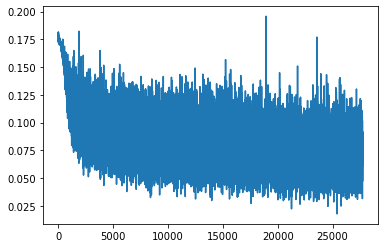

------
*********
29673 3218
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.1694105714559555
Loss:  0.16417965292930603
Loss:  0.15603557229042053
0 **********
Epoch:  52.13759398460388  fold:  5  kers:  32
epoch:  1
29673 464
Loss:  0.16762807965278625
Loss:  0.14318615198135376
Loss:  0.13071300089359283
1 **********
Epoch:  91.94914627075195  fold:  5  kers:  32
epoch:  2
29673 464
Loss:  0.12390215694904327
Loss:  0.10888584703207016
Loss:  0.12453432381153107
2 **********
Epoch:  131.71881008148193  fold:  5  kers:  32
epoch:  3
Eval Loss:  0.17071951925754547
Eval Loss:  0.32106927037239075
Eval Loss:  0.33403459191322327
[[2758  339]
 [  49   72]]
              precision  

Loss:  0.06931731849908829
10 **********
Epoch:  570.4218072891235  fold:  5  kers:  32
epoch:  11
29673 464
Loss:  0.10824084281921387
Loss:  0.1002480611205101
Loss:  0.10656630992889404
11 **********
Epoch:  609.5591623783112  fold:  5  kers:  32
epoch:  12
Eval Loss:  0.10478478670120239
Eval Loss:  0.2525576651096344
Eval Loss:  0.09840336441993713
[[3012   85]
 [  40   81]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3097
           1       0.49      0.67      0.56       121

    accuracy                           0.96      3218
   macro avg       0.74      0.82      0.77      3218
weighted avg       0.97      0.96      0.96      3218

acc:  0.9611559975139838
pre:  0.4879518072289157
rec:  0.6694214876033058
ma F1:  0.7720657108064936
mi F1:  0.961155997513984
we F1:  0.9640591237172718
update!  Acc:  0.9611559975139838
Eval Loss:  0.4363464415073395
Eval Loss:  0.32321396470069885
Eval Loss:  0.3810362219810486
Eval Lo


acc:  0.9580484773151026
pre:  0.45569620253164556
rec:  0.5950413223140496
ma F1:  0.7471013847338723
mi F1:  0.9580484773151025
we F1:  0.960704156942699
Eval Loss:  0.34493911266326904
Eval Loss:  0.2896522283554077
Eval Loss:  0.33661550283432007
Eval Loss:  0.34754788875579834
Eval Loss:  0.3688262104988098
Eval Loss:  0.3033488690853119
Eval Loss:  0.3080713152885437
Eval Loss:  0.27117669582366943
Eval Loss:  0.2763662338256836
Eval Loss:  0.3000776469707489
Eval Loss:  0.28643903136253357
Eval Loss:  0.2922128140926361
Eval Loss:  0.25245851278305054
Eval Loss:  0.29014796018600464
Eval Loss:  0.27129286527633667
Eval Loss:  0.3405294716358185
Eval Loss:  0.3725140690803528
Eval Loss:  0.44428202509880066
Eval Loss:  0.40820828080177307
Eval Loss:  0.2956852912902832
Eval Loss:  0.31298398971557617
Eval Loss:  0.351077139377594
Eval Loss:  0.33475741744041443
Eval Loss:  0.3849359452724457
Eval Loss:  0.39380061626434326
Eval Loss:  0.299578994512558
Eval Loss:  0.301632225513

Eval Loss:  0.28304579854011536
Eval Loss:  0.3143063485622406
Eval Loss:  0.3652321994304657
Eval Loss:  0.35986292362213135
Eval Loss:  0.2286471277475357
Eval Loss:  0.2689955234527588
Eval Loss:  0.3196524977684021
Eval Loss:  0.30011650919914246
Eval Loss:  0.3053399920463562
Eval Loss:  0.3751458525657654
Eval Loss:  0.28725361824035645
Eval Loss:  0.2775445580482483
Eval Loss:  0.28859734535217285
Eval Loss:  0.20646324753761292
[[15975  1092]
 [ 2483 10123]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     17067
           1       0.90      0.80      0.85     12606

    accuracy                           0.88     29673
   macro avg       0.88      0.87      0.87     29673
weighted avg       0.88      0.88      0.88     29673

acc:  0.8795201024500388
pre:  0.9026304057066429
rec:  0.803030303030303
ma F1:  0.8746444903211824
mi F1:  0.8795201024500388
we F1:  0.8783611864433335
29673 464
Loss:  0.057309672236442566
Loss:  0.

Loss:  0.060215938836336136
Loss:  0.10862819105386734
Loss:  0.05389530211687088
39 **********
Epoch:  2094.4408905506134  fold:  5  kers:  32
epoch:  40
29673 464
Loss:  0.07280439883470535
Loss:  0.09705989062786102
Loss:  0.10543610900640488
40 **********
Epoch:  2133.7368206977844  fold:  5  kers:  32
epoch:  41
29673 464
Loss:  0.049732740968465805
Loss:  0.07347477972507477
Loss:  0.09020958095788956
41 **********
Epoch:  2173.0876047611237  fold:  5  kers:  32
epoch:  42
Eval Loss:  0.06751997768878937
Eval Loss:  0.14107094705104828
Eval Loss:  0.04013582319021225
[[3049   48]
 [  38   83]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3097
           1       0.63      0.69      0.66       121

    accuracy                           0.97      3218
   macro avg       0.81      0.84      0.82      3218
weighted avg       0.97      0.97      0.97      3218

acc:  0.9732753262896209
pre:  0.6335877862595419
rec:  0.68595041


acc:  0.9723430702299565
pre:  0.6025641025641025
rec:  0.7768595041322314
ma F1:  0.8321249816094904
mi F1:  0.9723430702299565
we F1:  0.9740117656062627
Eval Loss:  0.28518491983413696
Eval Loss:  0.27179521322250366
Eval Loss:  0.26927679777145386
Eval Loss:  0.27511492371559143
Eval Loss:  0.22151601314544678
Eval Loss:  0.32626429200172424
Eval Loss:  0.24643199145793915
Eval Loss:  0.2369767129421234
Eval Loss:  0.23257777094841003
Eval Loss:  0.29029709100723267
Eval Loss:  0.2707040309906006
Eval Loss:  0.20552274584770203
Eval Loss:  0.21809838712215424
Eval Loss:  0.2090311199426651
Eval Loss:  0.17557339370250702
Eval Loss:  0.26700887084007263
Eval Loss:  0.2602114975452423
Eval Loss:  0.291672945022583
Eval Loss:  0.3571931719779968
Eval Loss:  0.1944354623556137
Eval Loss:  0.2415824681520462
Eval Loss:  0.28215324878692627
Eval Loss:  0.2692578434944153
Eval Loss:  0.24874725937843323
Eval Loss:  0.37983232736587524
Eval Loss:  0.2748733162879944
Eval Loss:  0.22805668

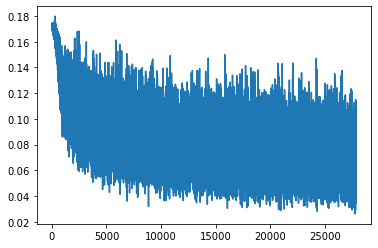

------
*********
29479 3412
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.16938753426074982
Loss:  0.16039413213729858
Loss:  0.1584862768650055
0 **********
Epoch:  51.79052233695984  fold:  6  kers:  32
epoch:  1
29479 461
Loss:  0.16137060523033142
Loss:  0.14760559797286987
Loss:  0.13826653361320496
1 **********
Epoch:  91.31683707237244  fold:  6  kers:  32
epoch:  2
29479 461
Loss:  0.12835142016410828
Loss:  0.13553188741207123
Loss:  0.11470334976911545
2 **********
Epoch:  130.88603711128235  fold:  6  kers:  32
epoch:  3
Eval Loss:  0.10033568739891052
Eval Loss:  0.2693008780479431
Eval Loss:  0.5427846312522888
[[1780  452]
 [ 112 1068]]
              precision    

Loss:  0.08834438025951385
Loss:  0.08126291632652283
Loss:  0.1520383656024933
11 **********
Epoch:  599.7643518447876  fold:  6  kers:  32
epoch:  12
Eval Loss:  0.04517477750778198
Eval Loss:  0.16450601816177368
Eval Loss:  0.391172856092453
[[2049  183]
 [ 177 1003]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2232
           1       0.85      0.85      0.85      1180

    accuracy                           0.89      3412
   macro avg       0.88      0.88      0.88      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8944900351699883
pre:  0.845699831365936
rec:  0.85
ma F1:  0.8835453810088866
mi F1:  0.8944900351699883
we F1:  0.8945528152129774
update!  Acc:  0.8944900351699883
Eval Loss:  0.42034709453582764
Eval Loss:  0.39791128039360046
Eval Loss:  0.3763459026813507
Eval Loss:  0.34663546085357666
Eval Loss:  0.4545668661594391
Eval Loss:  0.39493274688720703
Eval Loss:  0.4511752724647522
Eval

Eval Loss:  0.34269800782203674
Eval Loss:  0.3531549572944641
Eval Loss:  0.279299795627594
Eval Loss:  0.30300372838974
Eval Loss:  0.37413179874420166
Eval Loss:  0.3362451195716858
Eval Loss:  0.3664323091506958
Eval Loss:  0.30975157022476196
Eval Loss:  0.23885171115398407
Eval Loss:  0.27031874656677246
Eval Loss:  0.31078043580055237
Eval Loss:  0.36632537841796875
Eval Loss:  0.354761004447937
Eval Loss:  0.32684797048568726
Eval Loss:  0.29760831594467163
Eval Loss:  0.2969369888305664
Eval Loss:  0.30762654542922974
Eval Loss:  0.38151994347572327
Eval Loss:  0.42134109139442444
Eval Loss:  0.24955099821090698
Eval Loss:  0.25390541553497314
Eval Loss:  0.2789883613586426
Eval Loss:  0.35663947463035583
Eval Loss:  0.30412161350250244
Eval Loss:  0.36315613985061646
Eval Loss:  0.31745412945747375
Eval Loss:  0.24578872323036194
Eval Loss:  0.1806725114583969
[[16955   977]
 [ 2544  9003]]
              precision    recall  f1-score   support

           0       0.87      0.

Eval Loss:  0.250433087348938
Eval Loss:  0.2849022448062897
Eval Loss:  0.30895769596099854
Eval Loss:  0.3086431324481964
Eval Loss:  0.3045467436313629
Eval Loss:  0.21928611397743225
Eval Loss:  0.15582901239395142
[[16925  1007]
 [ 2211  9336]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     17932
           1       0.90      0.81      0.85     11547

    accuracy                           0.89     29479
   macro avg       0.89      0.88      0.88     29479
weighted avg       0.89      0.89      0.89     29479

acc:  0.8908375453712812
pre:  0.902639466305714
rec:  0.8085216939464797
ma F1:  0.8830894049596009
mi F1:  0.8908375453712811
we F1:  0.8896082976369731
29479 461
Loss:  0.11089470237493515
Loss:  0.1054868996143341
Loss:  0.034939929842948914
30 **********
Epoch:  1617.2617704868317  fold:  6  kers:  32
epoch:  31
29479 461
Loss:  0.07089527696371078
Loss:  0.09636145085096359
Loss:  0.07303735613822937
31 **********

Loss:  0.06649596989154816
Loss:  0.08378790318965912
Loss:  0.06343871355056763
39 **********
Epoch:  2084.1214826107025  fold:  6  kers:  32
epoch:  40
29479 461
Loss:  0.059246961027383804
Loss:  0.05068829655647278
Loss:  0.058022528886795044
40 **********
Epoch:  2123.5141541957855  fold:  6  kers:  32
epoch:  41
29479 461
Loss:  0.0672500729560852
Loss:  0.07197123020887375
Loss:  0.05179676041007042
41 **********
Epoch:  2162.7173330783844  fold:  6  kers:  32
epoch:  42
Eval Loss:  0.03715667501091957
Eval Loss:  0.11308419704437256
Eval Loss:  0.36110812425613403
[[2052  180]
 [ 157 1023]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2232
           1       0.85      0.87      0.86      1180

    accuracy                           0.90      3412
   macro avg       0.89      0.89      0.89      3412
weighted avg       0.90      0.90      0.90      3412

acc:  0.9012309495896834
pre:  0.8503740648379052
rec:  0.866949152

Eval Loss:  0.3083733916282654
Eval Loss:  0.3427794575691223
Eval Loss:  0.239132359623909
Eval Loss:  0.2741961181163788
Eval Loss:  0.30208632349967957
Eval Loss:  0.26416635513305664
Eval Loss:  0.29034656286239624
Eval Loss:  0.22132019698619843
Eval Loss:  0.20689894258975983
Eval Loss:  0.20997345447540283
Eval Loss:  0.2550550103187561
Eval Loss:  0.3304049074649811
Eval Loss:  0.3408195376396179
Eval Loss:  0.22280046343803406
Eval Loss:  0.2170603722333908
Eval Loss:  0.22552859783172607
Eval Loss:  0.24732740223407745
Eval Loss:  0.31488513946533203
Eval Loss:  0.36199039220809937
Eval Loss:  0.19805976748466492
Eval Loss:  0.22917325794696808
Eval Loss:  0.21783462166786194
Eval Loss:  0.23282545804977417
Eval Loss:  0.3007097542285919
Eval Loss:  0.27933213114738464
Eval Loss:  0.2486022263765335
Eval Loss:  0.19853748381137848
Eval Loss:  0.16095221042633057
[[17133   799]
 [ 2094  9453]]
              precision    recall  f1-score   support

           0       0.89      

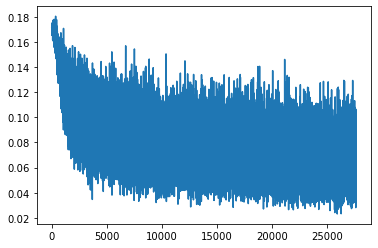

------
*********
29460 3431
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.17007353901863098
Loss:  0.1697433441877365
Loss:  0.14681164920330048
0 **********
Epoch:  51.62895464897156  fold:  7  kers:  32
epoch:  1
29460 461
Loss:  0.14224980771541595
Loss:  0.13575758039951324
Loss:  0.113980233669281
1 **********
Epoch:  90.82116270065308  fold:  7  kers:  32
epoch:  2
29460 461
Loss:  0.10311746597290039
Loss:  0.12177518755197525
Loss:  0.10741668194532394
2 **********
Epoch:  129.97846388816833  fold:  7  kers:  32
epoch:  3
Eval Loss:  0.7631404995918274
Eval Loss:  0.17624880373477936
Eval Loss:  1.7769185304641724
[[1632  495]
 [ 637  667]]
              precision    re

Loss:  0.09594330191612244
Loss:  0.10989762842655182
Loss:  0.08922775089740753
11 **********
Epoch:  599.2626931667328  fold:  7  kers:  32
epoch:  12
Eval Loss:  0.7963769435882568
Eval Loss:  0.08603618294000626
Eval Loss:  2.123976469039917
[[2041   86]
 [ 812  492]]
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      2127
           1       0.85      0.38      0.52      1304

    accuracy                           0.74      3431
   macro avg       0.78      0.67      0.67      3431
weighted avg       0.77      0.74      0.71      3431

acc:  0.7382687263188574
pre:  0.8512110726643599
rec:  0.3773006134969325
ma F1:  0.6712633744329071
mi F1:  0.7382687263188574
we F1:  0.7068640229817368
update!  Acc:  0.7382687263188574
Eval Loss:  0.4232909083366394
Eval Loss:  0.4127461910247803
Eval Loss:  0.32940173149108887
Eval Loss:  0.5560615658760071
Eval Loss:  0.3406442701816559
Eval Loss:  0.33709269762039185
Eval Loss:  0.24394650

Eval Loss:  0.3049350082874298
Eval Loss:  0.31790775060653687
Eval Loss:  0.2798464000225067
Eval Loss:  0.4025706350803375
Eval Loss:  0.26806560158729553
Eval Loss:  0.25774669647216797
Eval Loss:  0.1841423660516739
Eval Loss:  0.22579875588417053
Eval Loss:  0.32403746247291565
Eval Loss:  0.39953163266181946
Eval Loss:  0.3787703812122345
Eval Loss:  0.31644201278686523
Eval Loss:  0.26122698187828064
Eval Loss:  0.19345153868198395
Eval Loss:  0.23137760162353516
Eval Loss:  0.24509413540363312
Eval Loss:  0.3025157153606415
Eval Loss:  0.3717193603515625
Eval Loss:  0.20785842835903168
Eval Loss:  0.3442624807357788
Eval Loss:  0.200882226228714
Eval Loss:  0.3060224652290344
Eval Loss:  0.22750324010849
Eval Loss:  0.2748733162879944
Eval Loss:  0.16971638798713684
Eval Loss:  0.31488633155822754
Eval Loss:  0.23515988886356354
Eval Loss:  0.30360400676727295
[[17057   980]
 [ 2405  9018]]
              precision    recall  f1-score   support

           0       0.88      0.95

Eval Loss:  0.21522285044193268
Eval Loss:  0.23074498772621155
Eval Loss:  0.15673883259296417
Eval Loss:  0.32402870059013367
Eval Loss:  0.2766674757003784
Eval Loss:  0.29806622862815857
[[17289   748]
 [ 2428  8995]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     18037
           1       0.92      0.79      0.85     11423

    accuracy                           0.89     29460
   macro avg       0.90      0.87      0.88     29460
weighted avg       0.89      0.89      0.89     29460

acc:  0.8921928038017651
pre:  0.92322693215642
rec:  0.7874463801103038
ma F1:  0.8829122466401513
mi F1:  0.8921928038017651
we F1:  0.8903129706655809
29460 461
Loss:  0.0765376016497612
Loss:  0.07182435691356659
Loss:  0.09559184312820435
30 **********
Epoch:  1611.8721809387207  fold:  7  kers:  32
epoch:  31
29460 461
Loss:  0.04862122982740402
Loss:  0.07644357532262802
Loss:  0.08456353098154068
31 **********
Epoch:  1650.9127943515778  f

Loss:  0.0724390298128128
Loss:  0.08726541697978973
Loss:  0.05501728877425194
39 **********
Epoch:  2083.8432264328003  fold:  7  kers:  32
epoch:  40
29460 461
Loss:  0.05228940024971962
Loss:  0.07481817901134491
Loss:  0.03500869870185852
40 **********
Epoch:  2122.8379621505737  fold:  7  kers:  32
epoch:  41
29460 461
Loss:  0.06630709022283554
Loss:  0.05012905225157738
Loss:  0.05928464233875275
41 **********
Epoch:  2161.86261844635  fold:  7  kers:  32
epoch:  42
Eval Loss:  0.4695458710193634
Eval Loss:  0.13523989915847778
Eval Loss:  1.5214369297027588
[[1878  249]
 [ 572  732]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82      2127
           1       0.75      0.56      0.64      1304

    accuracy                           0.76      3431
   macro avg       0.76      0.72      0.73      3431
weighted avg       0.76      0.76      0.75      3431

acc:  0.7607111629262606
pre:  0.746177370030581
rec:  0.5613496932515337

Eval Loss:  0.19625622034072876
Eval Loss:  0.20587408542633057
Eval Loss:  0.25047779083251953
Eval Loss:  0.3131427466869354
Eval Loss:  0.19847379624843597
Eval Loss:  0.18030805885791779
Eval Loss:  0.1486353576183319
Eval Loss:  0.2249765247106552
Eval Loss:  0.30854350328445435
Eval Loss:  0.3381534218788147
Eval Loss:  0.3645152747631073
Eval Loss:  0.23886927962303162
Eval Loss:  0.18160435557365417
Eval Loss:  0.17152878642082214
Eval Loss:  0.20221339166164398
Eval Loss:  0.18847331404685974
Eval Loss:  0.25712913274765015
Eval Loss:  0.25923168659210205
Eval Loss:  0.1898067146539688
Eval Loss:  0.2541145086288452
Eval Loss:  0.19785961508750916
Eval Loss:  0.24798060953617096
Eval Loss:  0.192745640873909
Eval Loss:  0.2041907012462616
Eval Loss:  0.17645958065986633
Eval Loss:  0.28680726885795593
Eval Loss:  0.14019978046417236
Eval Loss:  0.2427998185157776
[[16788  1249]
 [ 1427  9996]]
              precision    recall  f1-score   support

           0       0.92      

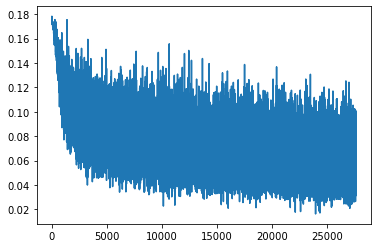

------
*********
29817 3074
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.17482487857341766
Loss:  0.16597215831279755
Loss:  0.15796232223510742
0 **********
Epoch:  52.01691746711731  fold:  8  kers:  32
epoch:  1
29817 466
Loss:  0.13096779584884644
Loss:  0.12152186036109924
Loss:  0.10698296129703522
1 **********
Epoch:  91.83245849609375  fold:  8  kers:  32
epoch:  2
29817 466
Loss:  0.12332809716463089
Loss:  0.11350422352552414
Loss:  0.0931958332657814
2 **********
Epoch:  131.66295981407166  fold:  8  kers:  32
epoch:  3
Eval Loss:  0.2549038827419281
Eval Loss:  0.8935518860816956
Eval Loss:  0.22321952879428864
[[1848  225]
 [ 436  565]]
              precision    

Loss:  0.08028199523687363
Loss:  0.06761498749256134
Loss:  0.06390775740146637
11 **********
Epoch:  602.7473757266998  fold:  8  kers:  32
epoch:  12
Eval Loss:  0.25353512167930603
Eval Loss:  1.7281920909881592
Eval Loss:  0.12149231880903244
[[1782  291]
 [ 504  497]]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2073
           1       0.63      0.50      0.56      1001

    accuracy                           0.74      3074
   macro avg       0.71      0.68      0.69      3074
weighted avg       0.73      0.74      0.73      3074

acc:  0.7413793103448276
pre:  0.6307106598984772
rec:  0.4965034965034965
ma F1:  0.6866181916945222
mi F1:  0.7413793103448276
we F1:  0.7323021755024033
Eval Loss:  0.3718351125717163
Eval Loss:  0.31779733300209045
Eval Loss:  0.32783693075180054
Eval Loss:  0.35508090257644653
Eval Loss:  0.35363948345184326
Eval Loss:  0.351014643907547
Eval Loss:  0.35186442732810974
Eval Loss:  0.3632366

Eval Loss:  0.3410671055316925
Eval Loss:  0.2883104681968689
Eval Loss:  0.308879017829895
Eval Loss:  0.33310332894325256
Eval Loss:  0.2714780569076538
Eval Loss:  0.33114340901374817
Eval Loss:  0.34887149930000305
Eval Loss:  0.34018048644065857
Eval Loss:  0.3105807602405548
Eval Loss:  0.29403331875801086
Eval Loss:  0.33104151487350464
Eval Loss:  0.3149416148662567
Eval Loss:  0.3543030619621277
Eval Loss:  0.301952987909317
Eval Loss:  0.3231186270713806
Eval Loss:  0.30143994092941284
Eval Loss:  0.30546835064888
Eval Loss:  0.32632938027381897
Eval Loss:  0.3507090210914612
Eval Loss:  0.3301381766796112
Eval Loss:  0.21324273943901062
Eval Loss:  0.3889404535293579
Eval Loss:  0.37769725918769836
Eval Loss:  0.17048221826553345
Eval Loss:  0.28495147824287415
Eval Loss:  0.3129497766494751
Eval Loss:  0.230597123503685
Eval Loss:  0.32490405440330505
Eval Loss:  0.30735528469085693
[[17272   819]
 [ 3034  8692]]
              precision    recall  f1-score   support

      

Eval Loss:  0.36017948389053345
Eval Loss:  0.3860722780227661
Eval Loss:  0.14847517013549805
Eval Loss:  0.2872522175312042
Eval Loss:  0.33388352394104004
Eval Loss:  0.1994677484035492
Eval Loss:  0.2857036292552948
Eval Loss:  0.29013779759407043
[[17064  1027]
 [ 2626  9100]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     18091
           1       0.90      0.78      0.83     11726

    accuracy                           0.88     29817
   macro avg       0.88      0.86      0.87     29817
weighted avg       0.88      0.88      0.88     29817

acc:  0.8774859979206493
pre:  0.8985879332477535
rec:  0.7760532150776053
ma F1:  0.868074392416006
mi F1:  0.8774859979206493
we F1:  0.8755963498541093
29817 466
Loss:  0.05692484229803085
Loss:  0.06759025901556015
Loss:  0.09498418867588043
30 **********
Epoch:  1623.5569386482239  fold:  8  kers:  32
epoch:  31
29817 466
Loss:  0.06849751621484756
Loss:  0.08273786306381226
Loss:  

Loss:  0.06584801524877548
Loss:  0.07710839062929153
Loss:  0.09029657393693924
39 **********
Epoch:  2094.658310174942  fold:  8  kers:  32
epoch:  40
29817 466
Loss:  0.09155257791280746
Loss:  0.0652807429432869
Loss:  0.06780286878347397
40 **********
Epoch:  2134.2045702934265  fold:  8  kers:  32
epoch:  41
29817 466
Loss:  0.05620608478784561
Loss:  0.08442839235067368
Loss:  0.06525071710348129
41 **********
Epoch:  2173.660074710846  fold:  8  kers:  32
epoch:  42
Eval Loss:  0.8134298920631409
Eval Loss:  1.1949512958526611
Eval Loss:  0.1497189849615097
[[1575  498]
 [ 311  690]]
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      2073
           1       0.58      0.69      0.63      1001

    accuracy                           0.74      3074
   macro avg       0.71      0.72      0.71      3074
weighted avg       0.75      0.74      0.74      3074

acc:  0.7368249837345479
pre:  0.5808080808080808
rec:  0.6893106893106893

Eval Loss:  0.27875420451164246
Eval Loss:  0.24409113824367523
Eval Loss:  0.22244146466255188
Eval Loss:  0.2573786973953247
Eval Loss:  0.24658910930156708
Eval Loss:  0.26199087500572205
Eval Loss:  0.2682860791683197
Eval Loss:  0.26107776165008545
Eval Loss:  0.280918687582016
Eval Loss:  0.21667683124542236
Eval Loss:  0.19496145844459534
Eval Loss:  0.19595184922218323
Eval Loss:  0.22573170065879822
Eval Loss:  0.1901896893978119
Eval Loss:  0.21891744434833527
Eval Loss:  0.16128677129745483
Eval Loss:  0.2851863503456116
Eval Loss:  0.27638596296310425
Eval Loss:  0.28448665142059326
Eval Loss:  0.25558507442474365
Eval Loss:  0.15883773565292358
Eval Loss:  0.2768727242946625
Eval Loss:  0.3318236470222473
Eval Loss:  0.14336763322353363
Eval Loss:  0.19496290385723114
Eval Loss:  0.2708492577075958
Eval Loss:  0.16276757419109344
Eval Loss:  0.22461716830730438
Eval Loss:  0.2237754911184311
[[16563  1528]
 [ 1458 10268]]
              precision    recall  f1-score   suppo

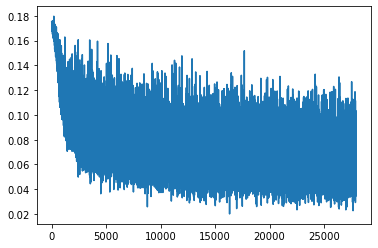

------
*********
29483 3408
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.1729867309331894
Loss:  0.16749541461467743
Loss:  0.152712881565094
0 **********
Epoch:  51.83141279220581  fold:  9  kers:  32
epoch:  1
29483 461
Loss:  0.13898399472236633
Loss:  0.13864967226982117
Loss:  0.12876984477043152
1 **********
Epoch:  91.17721009254456  fold:  9  kers:  32
epoch:  2
29483 461
Loss:  0.1040862649679184
Loss:  0.10925779491662979
Loss:  0.15262502431869507
2 **********
Epoch:  130.40033531188965  fold:  9  kers:  32
epoch:  3
Eval Loss:  0.21747927367687225
Eval Loss:  1.0295259952545166
Eval Loss:  0.3924970030784607
[[1516  226]
 [ 434 1232]]
              precision    rec

Loss:  0.06927871704101562
Loss:  0.08269970864057541
Loss:  0.08753316104412079
11 **********
Epoch:  600.0615568161011  fold:  9  kers:  32
epoch:  12
Eval Loss:  0.05644943192601204
Eval Loss:  1.6699005365371704
Eval Loss:  0.2636141777038574
[[1663   79]
 [ 555 1111]]
              precision    recall  f1-score   support

           0       0.75      0.95      0.84      1742
           1       0.93      0.67      0.78      1666

    accuracy                           0.81      3408
   macro avg       0.84      0.81      0.81      3408
weighted avg       0.84      0.81      0.81      3408

acc:  0.8139671361502347
pre:  0.9336134453781513
rec:  0.6668667466986795
ma F1:  0.8089550971903914
mi F1:  0.8139671361502347
we F1:  0.8096451605254423
Eval Loss:  0.27662840485572815
Eval Loss:  0.3749701678752899
Eval Loss:  0.3847482204437256
Eval Loss:  0.41926413774490356
Eval Loss:  0.373776912689209
Eval Loss:  0.420382559299469
Eval Loss:  0.32945406436920166
Eval Loss:  0.38911822438

Eval Loss:  0.2590915262699127
Eval Loss:  0.3086788058280945
Eval Loss:  0.3205941617488861
Eval Loss:  0.3514724373817444
Eval Loss:  0.32262682914733887
Eval Loss:  0.3285233676433563
Eval Loss:  0.27271613478660583
Eval Loss:  0.3288836181163788
Eval Loss:  0.2714002728462219
Eval Loss:  0.2160329967737198
Eval Loss:  0.27149954438209534
Eval Loss:  0.30032333731651306
Eval Loss:  0.24204140901565552
Eval Loss:  0.3086027204990387
Eval Loss:  0.2777440845966339
Eval Loss:  0.32133936882019043
Eval Loss:  0.2613300681114197
Eval Loss:  0.26948681473731995
Eval Loss:  0.2579856812953949
Eval Loss:  0.2918562889099121
Eval Loss:  0.32176992297172546
Eval Loss:  0.36661583185195923
Eval Loss:  0.2771390974521637
Eval Loss:  0.1900300830602646
Eval Loss:  0.2963205575942993
Eval Loss:  0.2636232376098633
Eval Loss:  0.26657912135124207
Eval Loss:  0.31989341974258423
[[17506   916]
 [ 2624  8437]]
              precision    recall  f1-score   support

           0       0.87      0.95  

Eval Loss:  0.28656482696533203
Eval Loss:  0.2415975034236908
Eval Loss:  0.2552894651889801
Eval Loss:  0.3003911077976227
[[17601   821]
 [ 2424  8637]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     18422
           1       0.91      0.78      0.84     11061

    accuracy                           0.89     29483
   macro avg       0.90      0.87      0.88     29483
weighted avg       0.89      0.89      0.89     29483

acc:  0.8899365736186955
pre:  0.9131951786847113
rec:  0.7808516409004611
ma F1:  0.8787259937977496
mi F1:  0.8899365736186955
we F1:  0.8879318257993094
29483 461
Loss:  0.08930827677249908
Loss:  0.06662056595087051
Loss:  0.044317495077848434
30 **********
Epoch:  1613.142783164978  fold:  9  kers:  32
epoch:  31
29483 461
Loss:  0.07287780195474625
Loss:  0.08435332030057907
Loss:  0.07131784409284592
31 **********
Epoch:  1652.2282769680023  fold:  9  kers:  32
epoch:  32
29483 461
Loss:  0.08514856547117

Loss:  0.043569862842559814
39 **********
Epoch:  2079.7102768421173  fold:  9  kers:  32
epoch:  40
29483 461
Loss:  0.0837000384926796
Loss:  0.09854719787836075
Loss:  0.07733464986085892
40 **********
Epoch:  2118.7987625598907  fold:  9  kers:  32
epoch:  41
29483 461
Loss:  0.05948668718338013
Loss:  0.06735893338918686
Loss:  0.05975104868412018
41 **********
Epoch:  2157.8663036823273  fold:  9  kers:  32
epoch:  42
Eval Loss:  0.031536515802145004
Eval Loss:  1.387575387954712
Eval Loss:  0.13665375113487244
[[1661   81]
 [ 499 1167]]
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1742
           1       0.94      0.70      0.80      1666

    accuracy                           0.83      3408
   macro avg       0.85      0.83      0.83      3408
weighted avg       0.85      0.83      0.83      3408

acc:  0.82981220657277
pre:  0.9350961538461539
rec:  0.7004801920768308
ma F1:  0.8261595781618776
mi F1:  0.8298122065727

Eval Loss:  0.2777025103569031
Eval Loss:  0.23206067085266113
Eval Loss:  0.29039788246154785
Eval Loss:  0.2627592086791992
Eval Loss:  0.2638469934463501
Eval Loss:  0.24738435447216034
Eval Loss:  0.27907487750053406
Eval Loss:  0.287504106760025
Eval Loss:  0.20969727635383606
Eval Loss:  0.18597187101840973
Eval Loss:  0.1636505424976349
Eval Loss:  0.25048238039016724
Eval Loss:  0.19660663604736328
Eval Loss:  0.21924859285354614
Eval Loss:  0.20595334470272064
Eval Loss:  0.2938074767589569
Eval Loss:  0.19350478053092957
Eval Loss:  0.24407824873924255
Eval Loss:  0.201751708984375
Eval Loss:  0.2363315373659134
Eval Loss:  0.2568804919719696
Eval Loss:  0.3162560760974884
Eval Loss:  0.246867835521698
Eval Loss:  0.1648314744234085
Eval Loss:  0.26843735575675964
Eval Loss:  0.2104196548461914
Eval Loss:  0.21964922547340393
Eval Loss:  0.25795453786849976
[[17509   913]
 [ 1955  9106]]
              precision    recall  f1-score   support

           0       0.90      0.95 

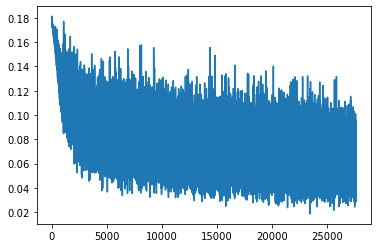

------
*********
29871 3020
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.16751937568187714
Loss:  0.1659240871667862
Loss:  0.16921573877334595
0 **********
Epoch:  52.07875180244446  fold:  10  kers:  32
epoch:  1
29871 467
Loss:  0.13078826665878296
Loss:  0.13242802023887634
Loss:  0.1268257051706314
1 **********
Epoch:  92.08179211616516  fold:  10  kers:  32
epoch:  2
29871 467
Loss:  0.12668336927890778
Loss:  0.11101389676332474
Loss:  0.10185381025075912
2 **********
Epoch:  131.80956840515137  fold:  10  kers:  32
epoch:  3
Eval Loss:  0.5076748728752136
Eval Loss:  0.32066118717193604
Eval Loss:  0.14308279752731323
[[1472  279]
 [ 162 1107]]
              precision 

Loss:  0.08517464995384216
10 **********
Epoch:  564.4487791061401  fold:  10  kers:  32
epoch:  11
29871 467
Loss:  0.11254209280014038
Loss:  0.09814788401126862
Loss:  0.08646339178085327
11 **********
Epoch:  603.9930455684662  fold:  10  kers:  32
epoch:  12
Eval Loss:  0.485920250415802
Eval Loss:  0.16466611623764038
Eval Loss:  0.15357640385627747
[[1603  148]
 [ 181 1088]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1751
           1       0.88      0.86      0.87      1269

    accuracy                           0.89      3020
   macro avg       0.89      0.89      0.89      3020
weighted avg       0.89      0.89      0.89      3020

acc:  0.8910596026490066
pre:  0.8802588996763754
rec:  0.8573680063041765
ma F1:  0.8877966838600027
mi F1:  0.8910596026490066
we F1:  0.8908505224159248
update!  Acc:  0.8910596026490066
Eval Loss:  0.3672671318054199
Eval Loss:  0.3237600028514862
Eval Loss:  0.3306562900543213
Eval 

Eval Loss:  0.3497443199157715
Eval Loss:  0.2921624183654785
Eval Loss:  0.38027679920196533
Eval Loss:  0.29653218388557434
Eval Loss:  0.28553906083106995
Eval Loss:  0.30335307121276855
Eval Loss:  0.3821483850479126
Eval Loss:  0.3717162609100342
Eval Loss:  0.4473816156387329
Eval Loss:  0.2577405571937561
Eval Loss:  0.3128097653388977
Eval Loss:  0.3033272922039032
Eval Loss:  0.2398490607738495
Eval Loss:  0.3246442675590515
Eval Loss:  0.2957316040992737
Eval Loss:  0.2972263991832733
Eval Loss:  0.36909395456314087
Eval Loss:  0.25220656394958496
Eval Loss:  0.2898397147655487
Eval Loss:  0.39882826805114746
Eval Loss:  0.3305627107620239
Eval Loss:  0.4128150939941406
Eval Loss:  0.37023067474365234
Eval Loss:  0.31621253490448
Eval Loss:  0.41012755036354065
Eval Loss:  0.24249646067619324
Eval Loss:  0.34939831495285034
Eval Loss:  0.39954641461372375
Eval Loss:  0.3417803943157196
[[17669   744]
 [ 3445  8013]]
              precision    recall  f1-score   support

     

Eval Loss:  0.36710286140441895
Eval Loss:  0.3147123456001282
Eval Loss:  0.3933536112308502
Eval Loss:  0.3616689443588257
Eval Loss:  0.2882269024848938
Eval Loss:  0.3754023313522339
Eval Loss:  0.22544455528259277
Eval Loss:  0.33594974875450134
Eval Loss:  0.35389140248298645
Eval Loss:  0.2870205044746399
[[17690   723]
 [ 3147  8311]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     18413
           1       0.92      0.73      0.81     11458

    accuracy                           0.87     29871
   macro avg       0.88      0.84      0.86     29871
weighted avg       0.88      0.87      0.87     29871

acc:  0.8704429044893041
pre:  0.9199690059774186
rec:  0.7253447373014488
ma F1:  0.8562735434427727
mi F1:  0.8704429044893041
we F1:  0.8667808369792505
29871 467
Loss:  0.07091591507196426
Loss:  0.06353817135095596
Loss:  0.09497825801372528
30 **********
Epoch:  1626.0223472118378  fold:  10  kers:  32
epoch:  31
29871 4

Loss:  0.06050632521510124
Loss:  0.06063065305352211
Loss:  0.0719342976808548
39 **********
Epoch:  2097.921583890915  fold:  10  kers:  32
epoch:  40
29871 467
Loss:  0.050677064806222916
Loss:  0.07389943301677704
Loss:  0.05570918694138527
40 **********
Epoch:  2137.554613351822  fold:  10  kers:  32
epoch:  41
29871 467
Loss:  0.07718376815319061
Loss:  0.0832846388220787
Loss:  0.0576559416949749
41 **********
Epoch:  2177.108853340149  fold:  10  kers:  32
epoch:  42
Eval Loss:  0.4281952679157257
Eval Loss:  0.11946528404951096
Eval Loss:  0.06839382648468018
[[1634  117]
 [ 179 1090]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1751
           1       0.90      0.86      0.88      1269

    accuracy                           0.90      3020
   macro avg       0.90      0.90      0.90      3020
weighted avg       0.90      0.90      0.90      3020

acc:  0.9019867549668874
pre:  0.9030654515327258
rec:  0.8589440504334

Eval Loss:  0.2169077843427658
Eval Loss:  0.27631062269210815
Eval Loss:  0.35478919744491577
Eval Loss:  0.2686784565448761
Eval Loss:  0.21162205934524536
Eval Loss:  0.25964000821113586
Eval Loss:  0.2818957567214966
Eval Loss:  0.23737046122550964
Eval Loss:  0.3134908378124237
Eval Loss:  0.22147566080093384
Eval Loss:  0.17583875358104706
Eval Loss:  0.1937117725610733
Eval Loss:  0.2564413547515869
Eval Loss:  0.203629732131958
Eval Loss:  0.23305152356624603
Eval Loss:  0.23574812710285187
Eval Loss:  0.26763156056404114
Eval Loss:  0.17134802043437958
Eval Loss:  0.23370429873466492
Eval Loss:  0.306948721408844
Eval Loss:  0.26806819438934326
Eval Loss:  0.3320852518081665
Eval Loss:  0.32087501883506775
Eval Loss:  0.2669469118118286
Eval Loss:  0.3203216791152954
Eval Loss:  0.22983410954475403
Eval Loss:  0.29739314317703247
Eval Loss:  0.24498701095581055
Eval Loss:  0.22953130304813385
[[16954  1459]
 [ 1615  9843]]
              precision    recall  f1-score   support


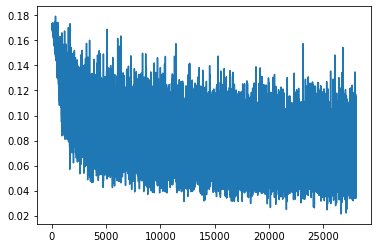

------


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from time import time
for kers in [128,64,32]:
    print("  ")
    print("kernel:",kers)
    print("  ")
    for fold in range(1,11):
        begin=time()
        #train_rec,test_rec=reclist[train_idx],reclist[test_idx]
        train_dtlist,test_dtlist=getTrainTestList(reclist,opt='kfold',fold = fold)#fold 1-10   
        print('*********')

        train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
        np.random.shuffle(train_dtlist)
        test_dtlist=[file for file in test_dtlist if dtclean(file)==0]
        print(len(train_dtlist),len(test_dtlist))
        model = MyLSTM(2,kers).to(device)

        #model.features[0]=nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                if(m.in_channels!=m.out_channels or m.out_channels!=m.groups or m.bias is not None):
                    # don't want to reinitialize downsample layers, code assuming normal conv layers will not have these characteristics
                    #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    print(m,'init')
                else:
                    print('Not initializing')
        criterion=nn.CrossEntropyLoss().to(device)#weight=torch.FloatTensor([1,1.5])
        #criterion = CircleLoss(m=0.25, gamma=256)
        opt=torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
        loss_list=[]

        opt.zero_grad()
        epoch_flag=0
        best_acc=0
        for epoch in range(60):
            print('epoch: ', epoch)
            if epoch_flag%3==0 and epoch_flag!=0:
                model.eval()
                prob_file,lab_file,tmp_acc,seg_file=eval(model,test_dtlist,criterion,device)
                if tmp_acc>best_acc:
                    best_acc=tmp_acc                   
                    res_file_name="./weights/fold_%.0f_w_%.0f_fs_%.0f.csv"%(fold,kers,28)
                    res_file=pd.DataFrame({"prob":prob_file,'label':lab_file,'seg':seg_file})
                    res_file.to_csv(res_file_name,index=False)
                    torch.save(model.state_dict(), "./weights/fold_%.0f_w_%.0f_fs_%.0f.pkl"%(fold,kers,28))
                    print("update! ",'Acc: ',best_acc)
                #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)
                _,_,_,_=eval(model,train_dtlist,criterion,device)
                model.train()
            train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
            #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
            train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True, sampler=None, num_workers=0)

            #test_loader=DataLoader(test_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
            print(len(train_dataset),len(train_loader)) #,len(test_dataset)
            flag=0
            accum_flag=0
            for fe, label,seg_id in train_loader:
                del seg_id
                fe=fe.float().to(device)
                #fe=(fe-fe_mean)/fe_std
                #fe=torch.stft(fe,100,hop_length=50,onesided=True)

                label=label.long().to(device)
                pred_prob_no_softmax=model(fe)
                loss=criterion(pred_prob_no_softmax,label)/4#/256
                del label
                del fe
                #inp_sp, inp_sn = convert_label_to_similarity(pred_prob_no_softmax,label)
                #loss = criterion(inp_sp, inp_sn)/256
                
                loss_list.append(loss.item())
                loss.backward()
                accum_flag+=1
                if accum_flag%4==0:
                    opt.step()
                    accum_flag=0
                    opt.zero_grad()
                flag+=1
                if flag%128==0:
                    print("Loss: ", loss.item())
                #print('step')
            print(epoch_flag,'*'*10)
            epoch_flag+=1
            #scheduler.step()
            print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
            
        model.eval()

        prob_file,lab_file,tmp_acc,seg_file=eval(model,test_dtlist,criterion,device)
        if tmp_acc>best_acc:
            best_acc=tmp_acc                   
            res_file_name="./weights/fold_%.0f_w_%.0f_fs_%.0f.csv"%(fold,kers,28)
            res_file=pd.DataFrame({"prob":prob_file,'label':lab_file,'seg':seg_file})
            res_file.to_csv(res_file_name,index=False)
            torch.save(model.state_dict(), "./weights/fold_%.0f_w_%.0f_fs_%.0f.pkl"%(fold,kers,28))
        print("update! ",'Acc: ',best_acc)
        #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)

        print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
        plt.plot(loss_list)
        plt.show()
        plt.close('all')
        print('------')

In [9]:
print('blind val','^^^^^^^^^^^^^^^^^^^^')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from time import time
for kers in [128,64,32]:
    print("  ")
    print("kernel:",kers)
    print("  ")
    for fold in range(1,11):
        begin=time()
        #train_rec,test_rec=reclist[train_idx],reclist[test_idx]
        train_dtlist,test_dtlist=getTrainTestList(reclist,opt='blind',fold = fold)#fold 1-10   
        print('*********')

        train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
        np.random.shuffle(train_dtlist)
        test_dtlist=[file for file in test_dtlist if dtclean(file)==0]
        print(len(train_dtlist),len(test_dtlist))
        model = MyLSTM(2,kers).to(device)

        #model.features[0]=nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                if(m.in_channels!=m.out_channels or m.out_channels!=m.groups or m.bias is not None):
                    # don't want to reinitialize downsample layers, code assuming normal conv layers will not have these characteristics
                    #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    print(m,'init')
                else:
                    print('Not initializing')
        criterion=nn.CrossEntropyLoss().to(device)#weight=torch.FloatTensor([1,1.5])
        #criterion = CircleLoss(m=0.25, gamma=256)
        opt=torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
        loss_list=[]

        opt.zero_grad()
        epoch_flag=0
        for epoch in range(60):
            print('epoch: ', epoch)
            if epoch_flag%3==0 and epoch_flag!=0:
                model.eval()
                eval(model,test_dtlist,criterion,device)
                #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)
                eval(model,train_dtlist,criterion,device)
                model.train()
            train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
            #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
            train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)

            #test_loader=DataLoader(test_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
            print(len(train_dataset),len(train_loader)) #,len(test_dataset)
            flag=0
            for fe, label in train_loader:
                fe=fe.float().to(device)
                #fe=(fe-fe_mean)/fe_std
                #fe=torch.stft(fe,100,hop_length=50,onesided=True)

                label=label.long().to(device)
                pred_prob_no_softmax=model(fe)
                loss=criterion(pred_prob_no_softmax,label)#/256

                #inp_sp, inp_sn = convert_label_to_similarity(pred_prob_no_softmax,label)
                #loss = criterion(inp_sp, inp_sn)/256

                loss_list.append(loss.item())
                loss.backward()
                opt.step()
                opt.zero_grad()
                flag+=1
                if flag%4==0:
                    print("Loss: ", loss.item())

                #print('step')
            print(epoch_flag,'*'*10)
            epoch_flag+=1
            #scheduler.step()
            
        model.eval()
        eval(model,test_dtlist,criterion,device)
        print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
        plt.plot(loss_list)
        plt.show()
        plt.close('all')
        print('------')

blind val ^^^^^^^^^^^^^^^^^^^^
  
kernel: 128
  
70 0 []
*********
32891 0
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
32891 129


ValueError: too many values to unpack (expected 2)